In [2]:
import params
from google.cloud import datastore, storage, logging
import time
import pickle
import hashlib
import sys
import time
import multiprocessing as mp
import sys
import dataAck
import curveTreeDB

def getValidModelsByTicker(db, ticker):
    while True:
        try:
            datastore_client = datastore.Client('money-maker-1236')
            query = datastore_client.query(kind=db)
            
            query.add_filter("ticker", '=', ticker)
            query.add_filter("IS_SHARPE DIFFERENCE SLIPPAGE", '>', 0.0)
            retrievedModels = list(query.fetch())
            return retrievedModels
        except:
            print("DATA SOURCE RETRIEVAL ERROR:", str(sys.exc_info()))
            return 


In [153]:
import params
import curveTreeDB
allModels = curveTreeDB.getValidModels(params.treeModels, returnEntireObject = True)

In [31]:
allValidModels = getValidModelsByTicker(params.treeModels, "USO")
# allValidModels = curveTreeDB.getValidModels(params.treeModels, returnEntireObject = True)

In [40]:
def getPertinentDataModels(db):
    while True:
        try:
            datastore_client = datastore.Client('money-maker-1236')
            query = datastore_client.query(kind=db)
#             query.add_filter("numberOfPredictors", "=", 2)
            query.add_filter("IS_PROFITABILITY DIFFERENCE", '>', -0.05) #-0.05
            retrievedModels = list(query.fetch())
            return retrievedModels
        except:
            print("DATA SOURCE RETRIEVAL ERROR:", str(sys.exc_info()))
            return 

In [41]:
allValidModels = getPertinentDataModels(params.averageTreeModels)

In [42]:
quickModels = []
predLength = {}
for mod in allValidModels:
#     if mod["predictionLength"] < 10:
#         continue
    if mod["predictionLength"] not in predLength:
        predLength[mod["predictionLength"]] = []
    predLength[mod["predictionLength"]].append(abs(mod["OOS_BETA"] - mod["IS_BETA"]))
#     print(mod["IS_BETA"], mod["OOS_BETA"], mod["predictionLength"])
    quickModels.append(mod)

# for item in sorted(predLength):
#     print(item, sum(predLength[item])/len(predLength[item]))

In [43]:
len(quickModels)

55024

In [39]:
import pandas as pd
cleanedModels = []
seenTickers = {}
seenPredictors = {}
seenAlpha = {}
tickerSharpe = {}

for item in quickModels:
#     del item["model"]
#     try:
#         del item["series"]
#     except:
#         pass
#     try:
#         print(item["IS_PROFITABILITY"], item["lastXDays"], item["IS_BETA"], item["OOS_BETA"])
#     except:
#         continue
#     if item["IS_SHARPE DIFFERENCE SLIPPAGE"] < 0.0:
#         continue
    
#     del item["ticker"]
#     if item["IS_PROFITABILITY"] < 0.51 or item["IS_BETA"] > 0.1 or item["IS_ACTIVITY"] < 0.8 or item["IS_SHARPE"] < 1.0:
#         continue

#     if item["OOS_ALPHA"] > 0:
#         continue

#     if item["maxDistance"] > 1.0:
#         continue
    
    if item["IS_25TH PROFITABILITY 45"] < 0.43:
        continue
    
#     if item["lookbackDistance"] < 22:
#         continue
        
#     if item["minConfidence"] <= 0.01:
#         continue

    if "series" in item:
        item["DAYS BACK"] = int(item["series"].split(",")[1])
        item["SMOOTHING"] = int(item["series"].split(",")[4][:-1])
        print(item["SMOOTHING"])
    
    if "numberOfPredictors" not in item:
        item["numberOfPredictors"] = 0
        
    item["DISTANCE PER POINT"] = item["maxDistance"]/ item["lookbackDistance"]
    
    if item["numberOfPredictors"] not in seenPredictors:
        seenPredictors[item["numberOfPredictors"]] = {"better":0, "greaterThanZero":0, "bad":0, "total":0}
        seenAlpha[item["numberOfPredictors"]] = {"greaterThanZero":0, "total":0}
    
    seenPredictors[item["numberOfPredictors"]]["total"] += 1
    seenAlpha[item["numberOfPredictors"]]["total"] += 1
    if item["OOS_SHARPE"] > item["OOS_FACTOR SHARPE"]:
#         print(item["ticker"], item["OOS_SHARPE"], item["OOS_FACTOR SHARPE"] )
        seenPredictors[item["numberOfPredictors"]]["better"] += 1
    if item["OOS_SHARPE"] > 0:
        seenPredictors[item["numberOfPredictors"]]["greaterThanZero"] += 1
    if item["OOS_SHARPE"] < 0 and item["OOS_FACTOR SHARPE"] > 0:
        seenPredictors[item["numberOfPredictors"]]["bad"] += 1
    if item["OOS_ALPHA"] > 0:
        seenAlpha[item["numberOfPredictors"]]["greaterThanZero"] += 1
    
    print(item["series"])
    print("NUMBER OF PREDICTORS", item["numberOfPredictors"])
    print("SHARPE", item["IS_SHARPE"], item["OOS_SHARPE"], item["OOS_FACTOR SHARPE"])
    print("RAW BETA", item["IS_RAW BETA"], item["OOS_RAW BETA"])
    print("BETA", item["IS_BETA"], item["OOS_BETA"])
    print("ALPHA", item["IS_ALPHA"], item["OOS_ALPHA"])
    print("PROFITABILITY DIFFERENCE", item["IS_PROFITABILITY DIFFERENCE"])
    print("DISTANCE PER POINT", item["lookbackDistance"], item["DISTANCE PER POINT"])
    print("**********")
        
        
        
    if item["ticker"] not in seenTickers:
        seenTickers[item["ticker"]] = 0
    if item["ticker"] not in tickerSharpe:
        tickerSharpe[item["ticker"]] = item["OOS_FACTOR SHARPE"]
    seenTickers[item["ticker"]] += 1
    itemKeys= list(item.keys())
    for key in itemKeys:
        if key.startswith("OOS") and key != "OOS_ALPHA" and key != "OOS_PROFITABILITY DIFFERENCE" and key != "OOS_FACTOR SHARPE" and key != "OOS_RAW BETA" and key != "OOS_PROFITABILITY" and key != "OOS_SHARPE DIFFERENCE SLIPPAGE" and key != "OOS_SHARPE" and key != "OOS_BETA" and key != "OOS_ANNUALIZED RETURN":
            del item[key]
    cleanedModels.append(item)
print(seenTickers)
print(tickerSharpe)
for predictors in sorted(seenPredictors):
    print(predictors, seenPredictors[predictors]["total"],\
          1.0 - seenPredictors[predictors]["bad"]/seenPredictors[predictors]["total"],\
          seenPredictors[predictors]["better"]/seenPredictors[predictors]["total"],\
          seenPredictors[predictors]["greaterThanZero"]/seenPredictors[predictors]["total"])
    
    print("ALPHA", predictors, seenAlpha[predictors]["greaterThanZero"]/seenAlpha[predictors]["total"])
    
    
    
    
    

5
('KRE', 14, None, None, 5)
NUMBER OF PREDICTORS 0
SHARPE 1.0723763126324897 -0.18540703095563144 0.8600299743458575
RAW BETA 0.24033657885922766 0.09625600809511763
BETA 0.16506422765190518 0.02180239667771141
ALPHA 0.09173636198325039 -0.011539539808235553
PROFITABILITY DIFFERENCE -0.06749460043196537
DISTANCE PER POINT 22 0.045454545454545456
**********
4
('XME', 15, None, None, 4)
NUMBER OF PREDICTORS 0
SHARPE 0.6802458096129652 -0.3325744614813658 1.6359607718654239
RAW BETA 0.1813363146900473 0.31632073686202855
BETA 0.1495922299010589 0.25720595670245794
ALPHA 0.05011271295571948 -0.05171867220068888
PROFITABILITY DIFFERENCE -0.06418554476806898
DISTANCE PER POINT 22 0.045454545454545456
**********
5
('XOP', 4, None, None, 5)
NUMBER OF PREDICTORS 0
SHARPE 0.6301798366707286 0.520269642799311 0.8792210837157359
RAW BETA 0.5454776209771314 0.46552706552706363
BETA 0.37159337042987545 0.26574315643270124
ALPHA -0.0011261403951450346 0.004231801935411875
PROFITABILITY DIFFERENCE -0

In [38]:
len(cleanedModels)

31

DAYS BACK OOS_PROFITABILITY


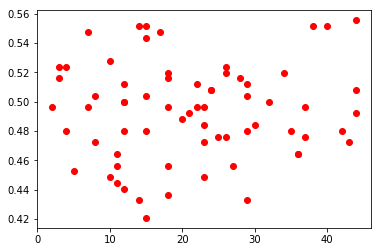

DAYS BACK OOS_SHARPE DIFFERENCE SLIPPAGE


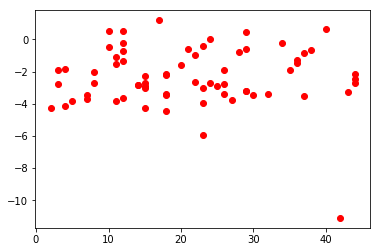

DAYS BACK OOS_SHARPE


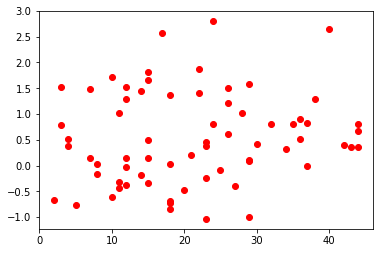

DAYS BACK OOS_ALPHA


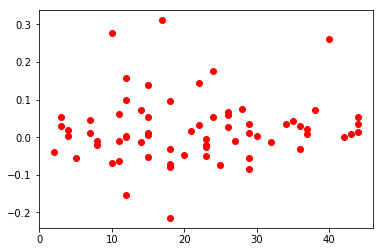

DAYS BACK OOS_PROFITABILITY DIFFERENCE


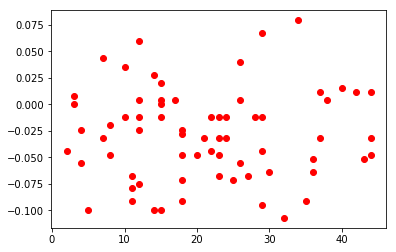

DAYS BACK OOS_BETA


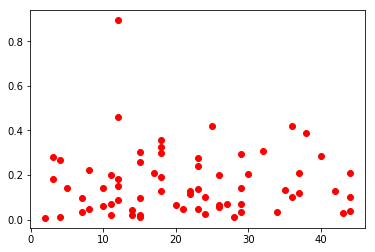

DAYS BACK OOS_ANNUALIZED RETURN


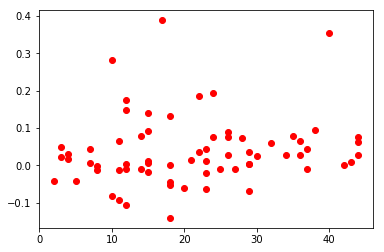

DAYS BACK OOS_FACTOR SHARPE


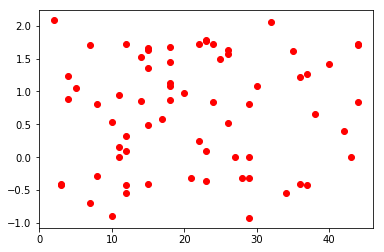

DISTANCE PER POINT
0.005682    0.503968
0.011364    0.510462
0.017045    0.499008
0.022727    0.500794
0.034091    0.481481
0.045455    0.486855
Name: OOS_PROFITABILITY, dtype: float64
DISTANCE PER POINT
0.005682   -4.382972
0.011364   -1.624563
0.017045   -1.483007
0.022727   -3.144798
0.034091   -1.971109
0.045455   -2.430454
Name: OOS_SHARPE DIFFERENCE SLIPPAGE, dtype: float64
DISTANCE PER POINT
0.005682    0.248569
0.011364    0.940325
0.017045    0.359634
0.022727    0.518094
0.034091    0.665562
0.045455    0.390884
Name: OOS_SHARPE, dtype: float64
DISTANCE PER POINT
0.005682    0.015803
0.011364    0.056991
0.017045   -0.013434
0.022727    0.012728
0.034091    0.023801
0.045455    0.015578
Name: OOS_ALPHA, dtype: float64
DISTANCE PER POINT OOS_PROFITABILITY


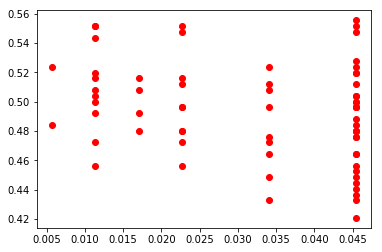

DISTANCE PER POINT OOS_SHARPE DIFFERENCE SLIPPAGE


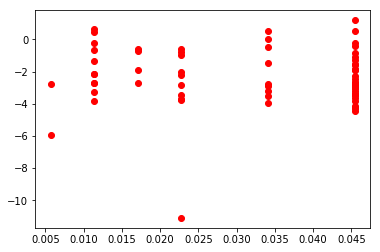

DISTANCE PER POINT OOS_SHARPE


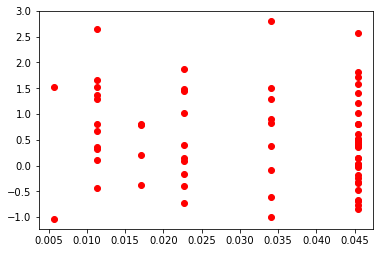

DISTANCE PER POINT OOS_ALPHA


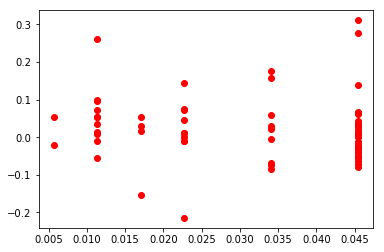

DISTANCE PER POINT OOS_PROFITABILITY DIFFERENCE


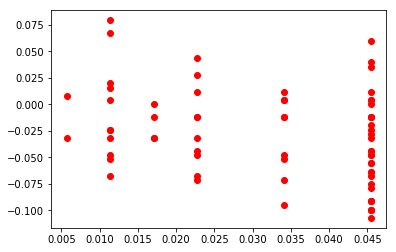

DISTANCE PER POINT OOS_BETA


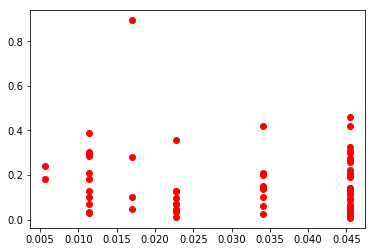

DISTANCE PER POINT OOS_ANNUALIZED RETURN


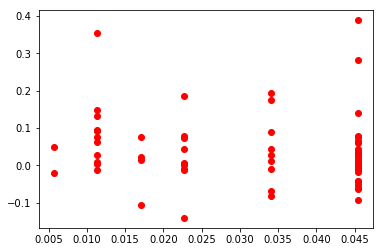

DISTANCE PER POINT OOS_FACTOR SHARPE


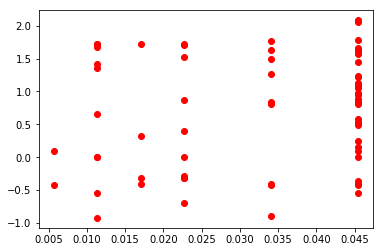

IS_25TH PERCENTILE RELATIVE SHARPE DIFFERENCE OOS_PROFITABILITY


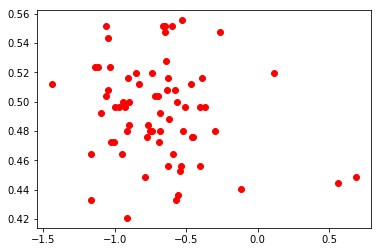

IS_25TH PERCENTILE RELATIVE SHARPE DIFFERENCE OOS_SHARPE DIFFERENCE SLIPPAGE


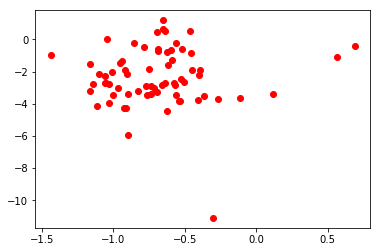

IS_25TH PERCENTILE RELATIVE SHARPE DIFFERENCE OOS_SHARPE


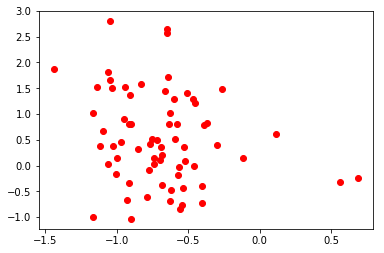

IS_25TH PERCENTILE RELATIVE SHARPE DIFFERENCE OOS_ALPHA


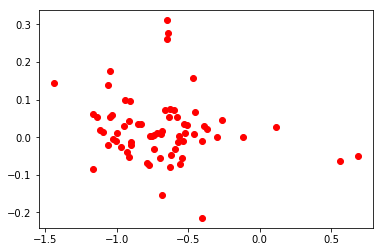

IS_25TH PERCENTILE RELATIVE SHARPE DIFFERENCE OOS_PROFITABILITY DIFFERENCE


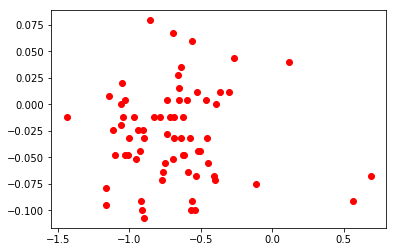

IS_25TH PERCENTILE RELATIVE SHARPE DIFFERENCE OOS_BETA


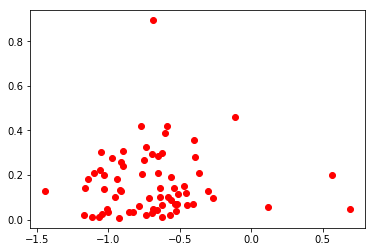

IS_25TH PERCENTILE RELATIVE SHARPE DIFFERENCE OOS_ANNUALIZED RETURN


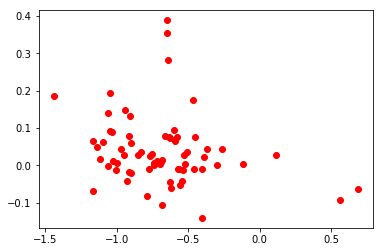

IS_25TH PERCENTILE RELATIVE SHARPE DIFFERENCE OOS_FACTOR SHARPE


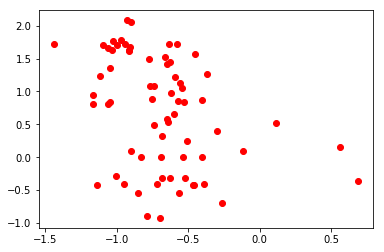

IS_25TH PERCENTILE SHARPE OOS_PROFITABILITY


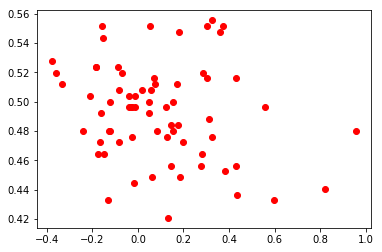

IS_25TH PERCENTILE SHARPE OOS_SHARPE DIFFERENCE SLIPPAGE


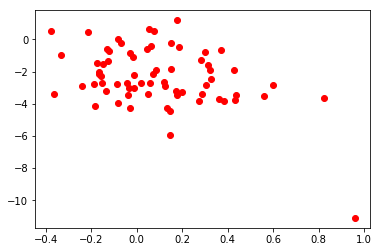

IS_25TH PERCENTILE SHARPE OOS_SHARPE


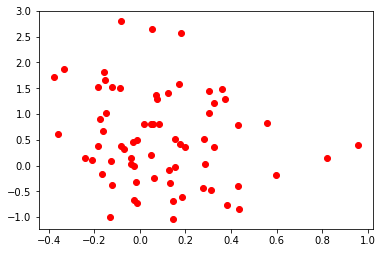

IS_25TH PERCENTILE SHARPE OOS_ALPHA


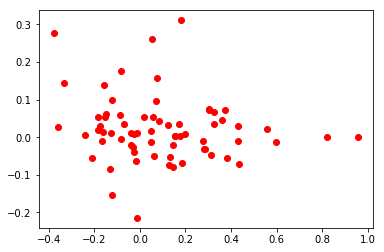

IS_25TH PERCENTILE SHARPE OOS_PROFITABILITY DIFFERENCE


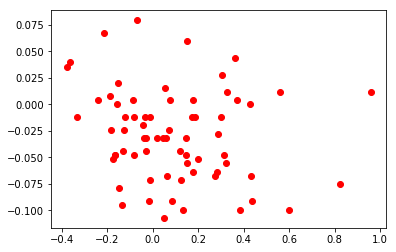

IS_25TH PERCENTILE SHARPE OOS_BETA


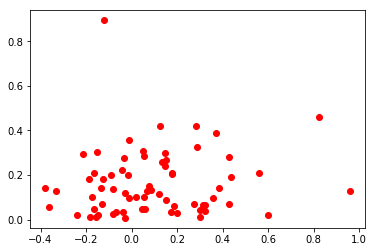

IS_25TH PERCENTILE SHARPE OOS_ANNUALIZED RETURN


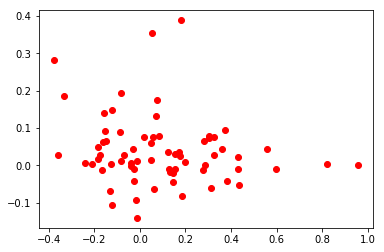

IS_25TH PERCENTILE SHARPE OOS_FACTOR SHARPE


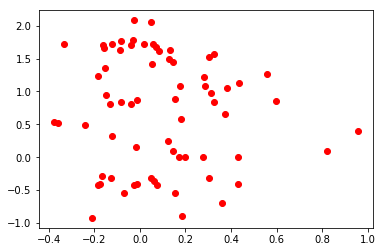

IS_25TH PERCENTILE SHARPE 45 OOS_PROFITABILITY


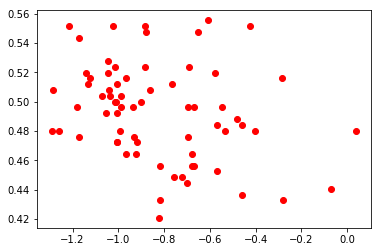

IS_25TH PERCENTILE SHARPE 45 OOS_SHARPE DIFFERENCE SLIPPAGE


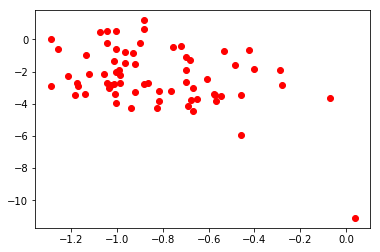

IS_25TH PERCENTILE SHARPE 45 OOS_SHARPE


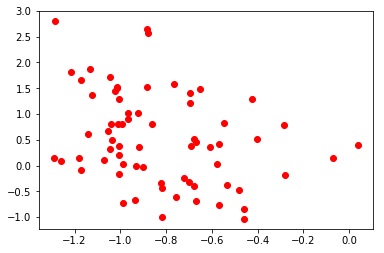

IS_25TH PERCENTILE SHARPE 45 OOS_ALPHA


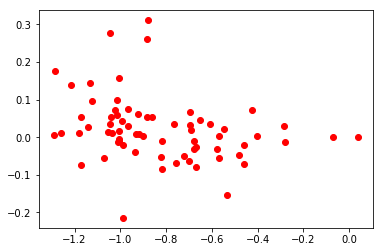

IS_25TH PERCENTILE SHARPE 45 OOS_PROFITABILITY DIFFERENCE


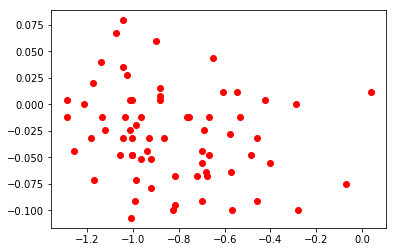

IS_25TH PERCENTILE SHARPE 45 OOS_BETA


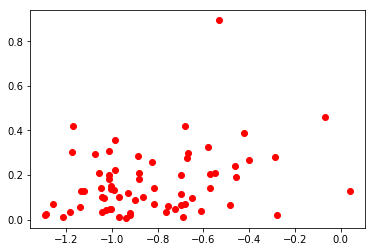

IS_25TH PERCENTILE SHARPE 45 OOS_ANNUALIZED RETURN


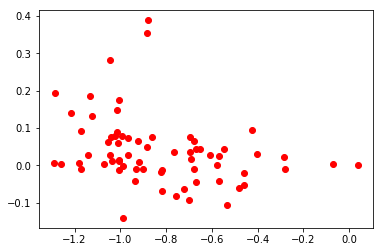

IS_25TH PERCENTILE SHARPE 45 OOS_FACTOR SHARPE


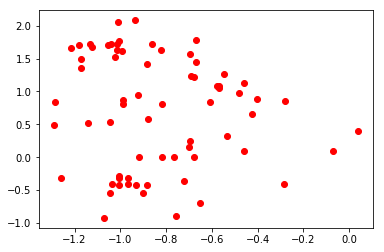

IS_25TH PERCENTILE SHARPE 90 OOS_PROFITABILITY


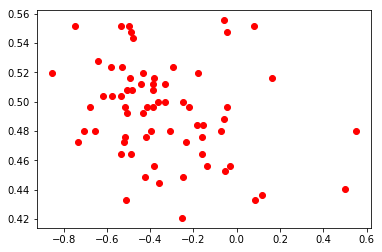

IS_25TH PERCENTILE SHARPE 90 OOS_SHARPE DIFFERENCE SLIPPAGE


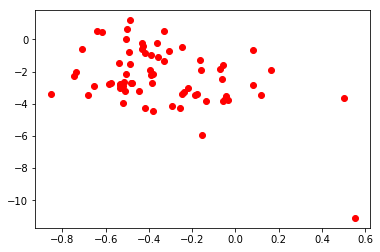

IS_25TH PERCENTILE SHARPE 90 OOS_SHARPE


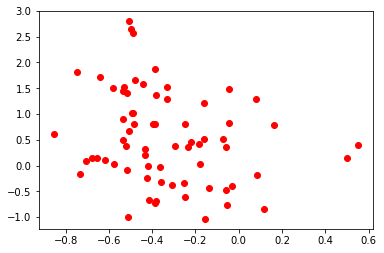

IS_25TH PERCENTILE SHARPE 90 OOS_ALPHA


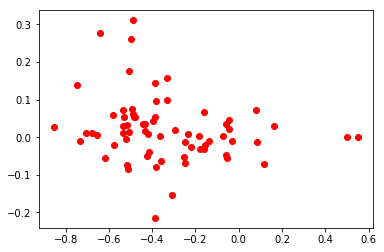

IS_25TH PERCENTILE SHARPE 90 OOS_PROFITABILITY DIFFERENCE


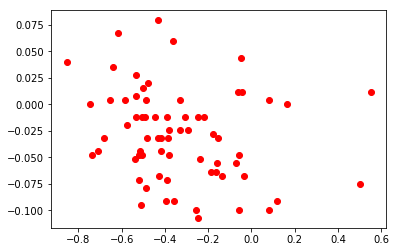

IS_25TH PERCENTILE SHARPE 90 OOS_BETA


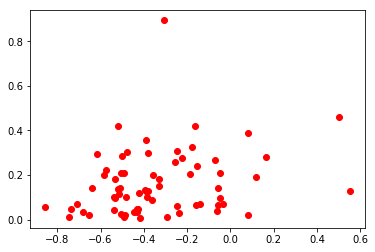

IS_25TH PERCENTILE SHARPE 90 OOS_ANNUALIZED RETURN


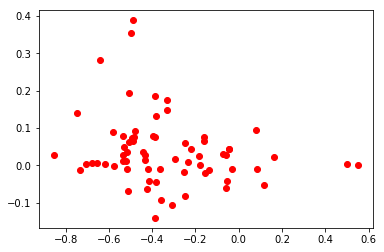

IS_25TH PERCENTILE SHARPE 90 OOS_FACTOR SHARPE


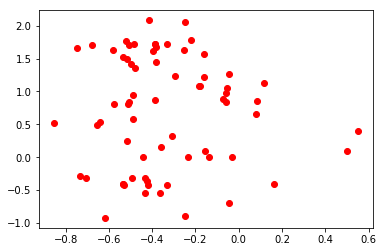

IS_25TH PERCENTILE SHARPE DIFFERENCE OOS_PROFITABILITY


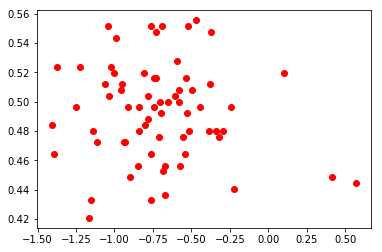

IS_25TH PERCENTILE SHARPE DIFFERENCE OOS_SHARPE DIFFERENCE SLIPPAGE


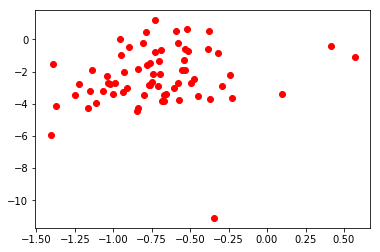

IS_25TH PERCENTILE SHARPE DIFFERENCE OOS_SHARPE


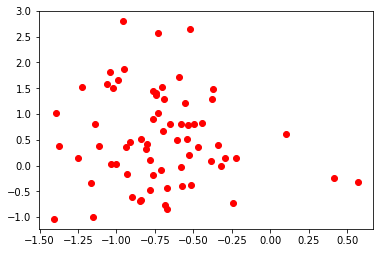

IS_25TH PERCENTILE SHARPE DIFFERENCE OOS_ALPHA


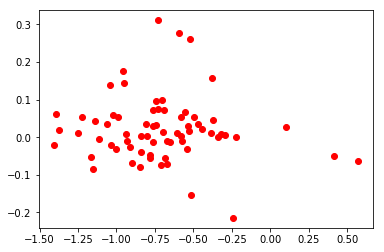

IS_25TH PERCENTILE SHARPE DIFFERENCE OOS_PROFITABILITY DIFFERENCE


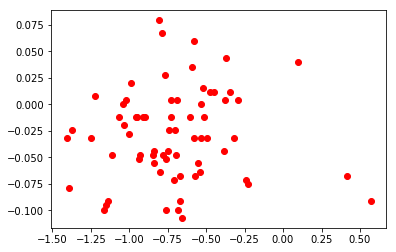

IS_25TH PERCENTILE SHARPE DIFFERENCE OOS_BETA


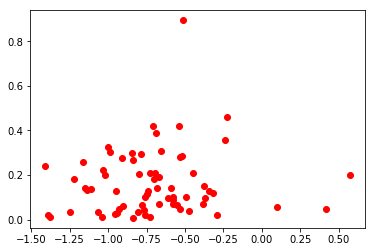

IS_25TH PERCENTILE SHARPE DIFFERENCE OOS_ANNUALIZED RETURN


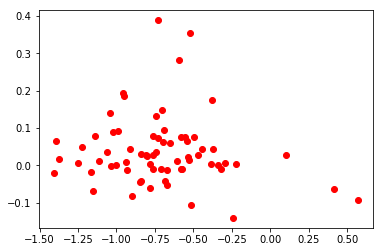

IS_25TH PERCENTILE SHARPE DIFFERENCE OOS_FACTOR SHARPE


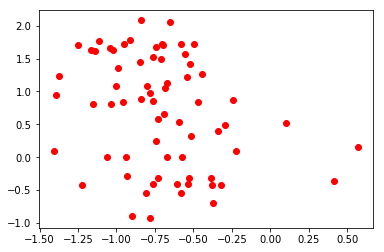

IS_25TH PROFITABILITY 45
0.444444    0.490884
0.466667    0.494312
0.488889    0.547619
Name: OOS_PROFITABILITY, dtype: float64
IS_25TH PROFITABILITY 45
0.444444   -2.320827
0.466667   -2.332402
0.488889   -3.687975
Name: OOS_SHARPE DIFFERENCE SLIPPAGE, dtype: float64
IS_25TH PROFITABILITY 45
0.444444    0.537253
0.466667    0.486399
0.488889    1.488230
Name: OOS_SHARPE, dtype: float64
IS_25TH PROFITABILITY 45
0.444444    0.026510
0.466667    0.013912
0.488889    0.046501
Name: OOS_ALPHA, dtype: float64
IS_25TH PROFITABILITY 45 OOS_PROFITABILITY


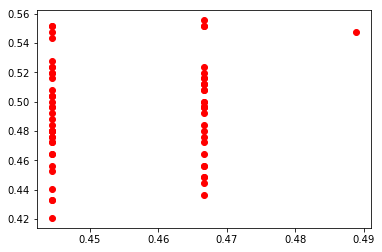

IS_25TH PROFITABILITY 45 OOS_SHARPE DIFFERENCE SLIPPAGE


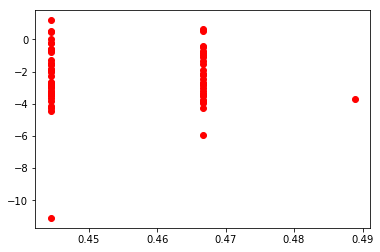

IS_25TH PROFITABILITY 45 OOS_SHARPE


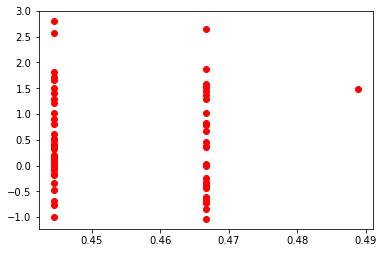

IS_25TH PROFITABILITY 45 OOS_ALPHA


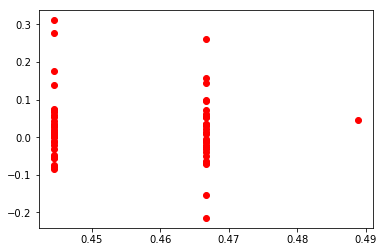

IS_25TH PROFITABILITY 45 OOS_PROFITABILITY DIFFERENCE


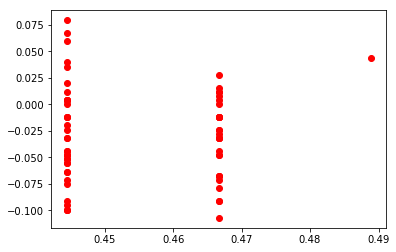

IS_25TH PROFITABILITY 45 OOS_BETA


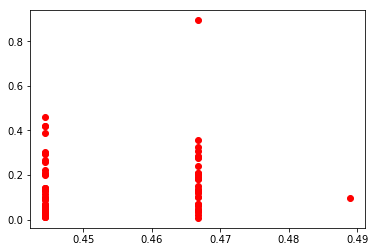

IS_25TH PROFITABILITY 45 OOS_ANNUALIZED RETURN


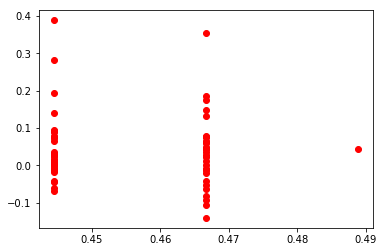

IS_25TH PROFITABILITY 45 OOS_FACTOR SHARPE


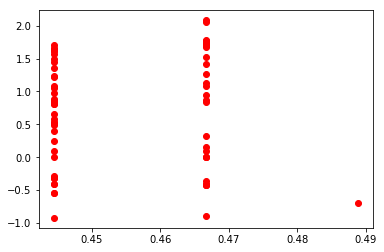

IS_25TH PROFITABILITY 90
0.444444    0.515873
0.455556    0.483938
0.466667    0.491686
0.477778    0.499433
0.488889    0.497795
0.500000    0.547619
Name: OOS_PROFITABILITY, dtype: float64
IS_25TH PROFITABILITY 90
0.444444   -2.056718
0.455556   -2.496291
0.466667   -1.935191
0.477778   -2.801092
0.488889   -2.161425
0.500000   -3.687975
Name: OOS_SHARPE DIFFERENCE SLIPPAGE, dtype: float64
IS_25TH PROFITABILITY 90
0.444444    1.589750
0.455556    0.295697
0.466667    0.643355
0.477778    0.496304
0.488889    0.513606
0.500000    1.488230
Name: OOS_SHARPE, dtype: float64
IS_25TH PROFITABILITY 90
0.444444    0.098105
0.455556    0.005560
0.466667    0.039381
0.477778    0.016459
0.488889    0.003094
0.500000    0.046501
Name: OOS_ALPHA, dtype: float64
IS_25TH PROFITABILITY 90 OOS_PROFITABILITY


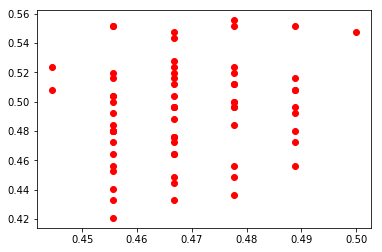

IS_25TH PROFITABILITY 90 OOS_SHARPE DIFFERENCE SLIPPAGE


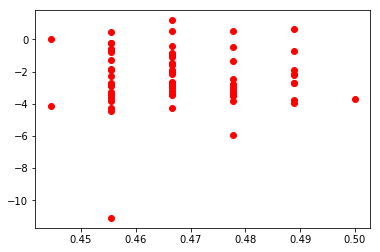

IS_25TH PROFITABILITY 90 OOS_SHARPE


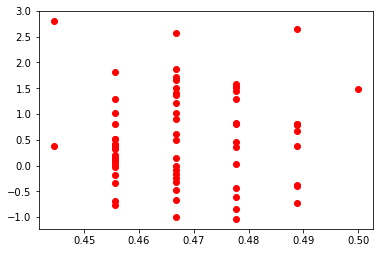

IS_25TH PROFITABILITY 90 OOS_ALPHA


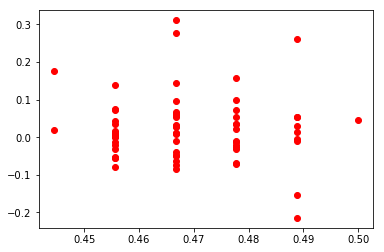

IS_25TH PROFITABILITY 90 OOS_PROFITABILITY DIFFERENCE


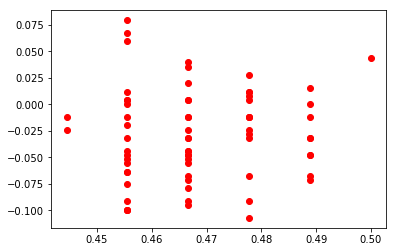

IS_25TH PROFITABILITY 90 OOS_BETA


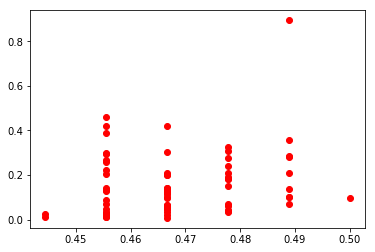

IS_25TH PROFITABILITY 90 OOS_ANNUALIZED RETURN


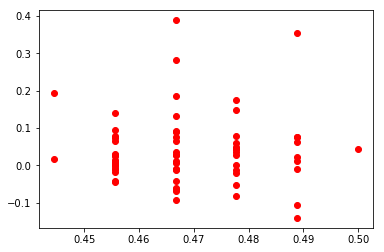

IS_25TH PROFITABILITY 90 OOS_FACTOR SHARPE


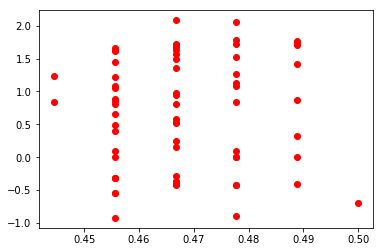

IS_ACTIVE PROFITABILITY OOS_PROFITABILITY


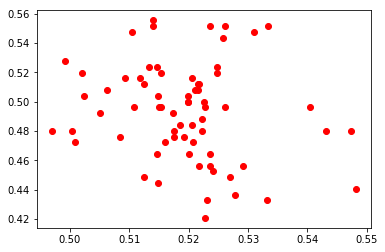

IS_ACTIVE PROFITABILITY OOS_SHARPE DIFFERENCE SLIPPAGE


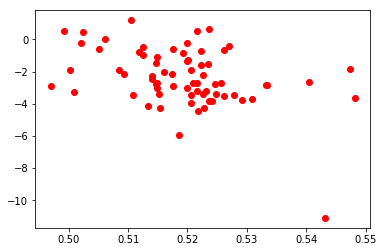

IS_ACTIVE PROFITABILITY OOS_SHARPE


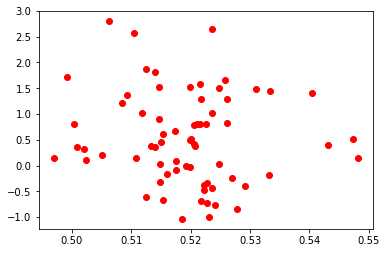

IS_ACTIVE PROFITABILITY OOS_ALPHA


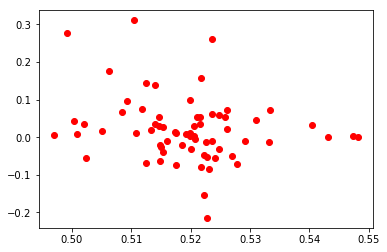

IS_ACTIVE PROFITABILITY OOS_PROFITABILITY DIFFERENCE


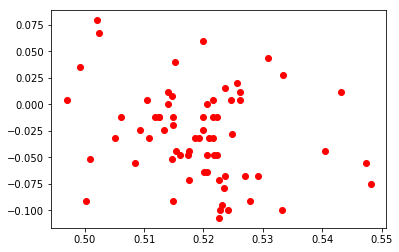

IS_ACTIVE PROFITABILITY OOS_BETA


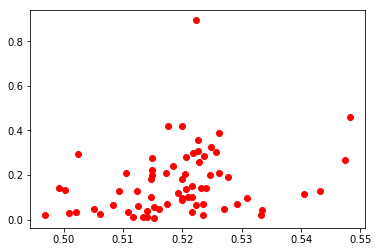

IS_ACTIVE PROFITABILITY OOS_ANNUALIZED RETURN


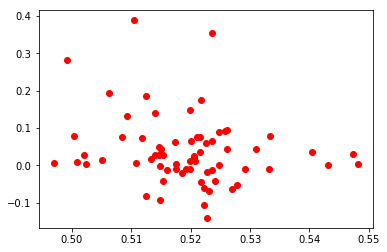

IS_ACTIVE PROFITABILITY OOS_FACTOR SHARPE


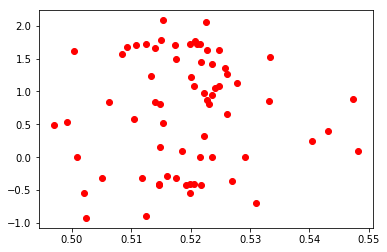

IS_ACTIVE PROFITABILITY SLIPPAGE OOS_PROFITABILITY


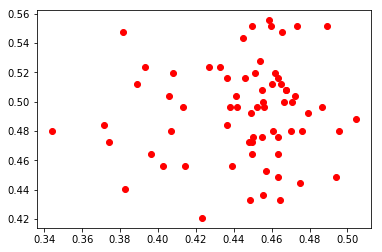

IS_ACTIVE PROFITABILITY SLIPPAGE OOS_SHARPE DIFFERENCE SLIPPAGE


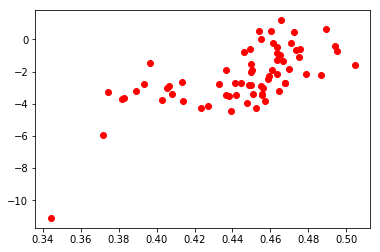

IS_ACTIVE PROFITABILITY SLIPPAGE OOS_SHARPE


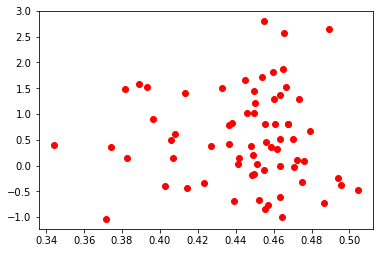

IS_ACTIVE PROFITABILITY SLIPPAGE OOS_ALPHA


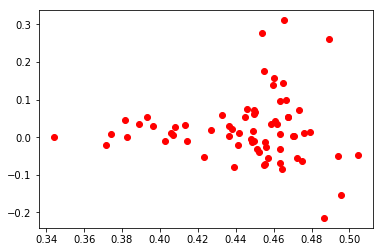

IS_ACTIVE PROFITABILITY SLIPPAGE OOS_PROFITABILITY DIFFERENCE


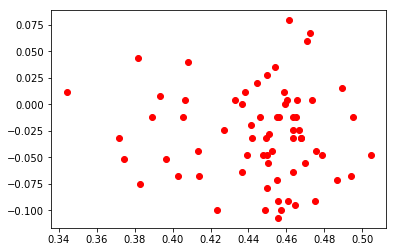

IS_ACTIVE PROFITABILITY SLIPPAGE OOS_BETA


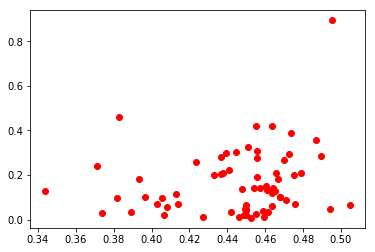

IS_ACTIVE PROFITABILITY SLIPPAGE OOS_ANNUALIZED RETURN


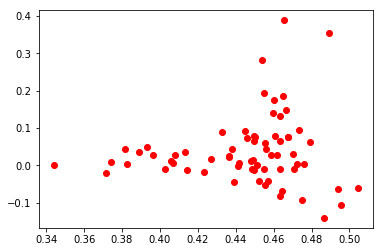

IS_ACTIVE PROFITABILITY SLIPPAGE OOS_FACTOR SHARPE


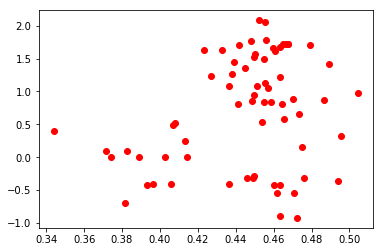

IS_ACTIVITY OOS_PROFITABILITY


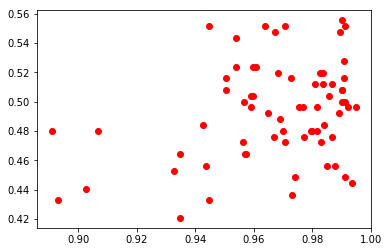

IS_ACTIVITY OOS_SHARPE DIFFERENCE SLIPPAGE


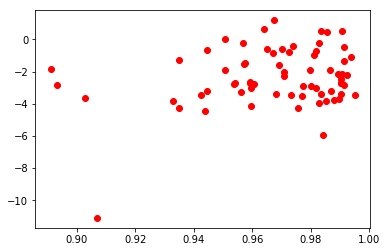

IS_ACTIVITY OOS_SHARPE


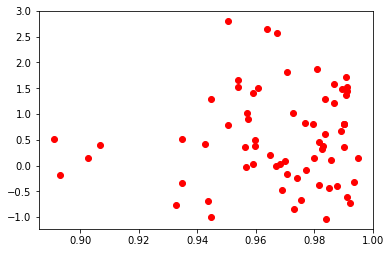

IS_ACTIVITY OOS_ALPHA


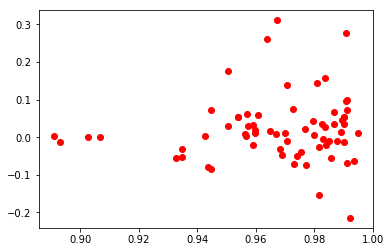

IS_ACTIVITY OOS_PROFITABILITY DIFFERENCE


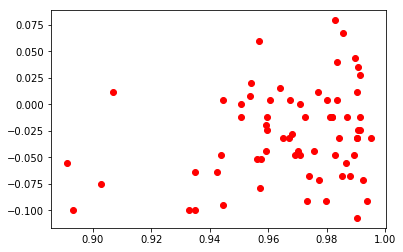

IS_ACTIVITY OOS_BETA


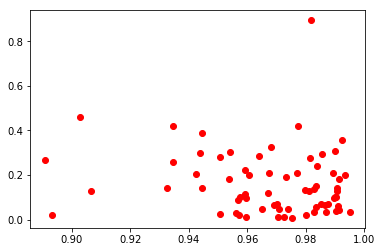

IS_ACTIVITY OOS_ANNUALIZED RETURN


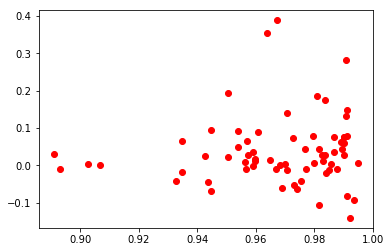

IS_ACTIVITY OOS_FACTOR SHARPE


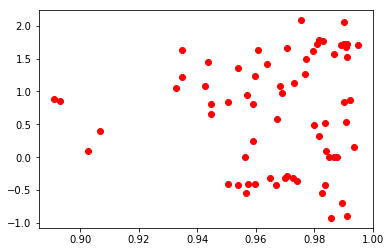

IS_ALPHA OOS_PROFITABILITY


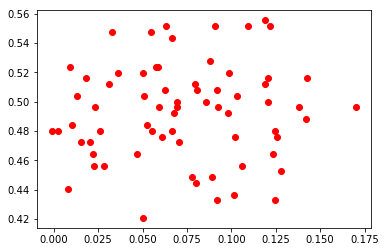

IS_ALPHA OOS_SHARPE DIFFERENCE SLIPPAGE


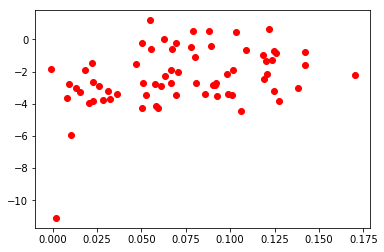

IS_ALPHA OOS_SHARPE


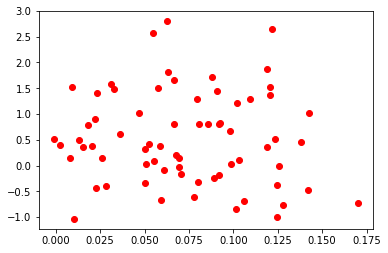

IS_ALPHA OOS_ALPHA


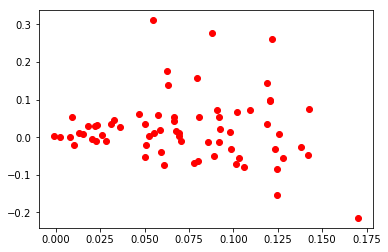

IS_ALPHA OOS_PROFITABILITY DIFFERENCE


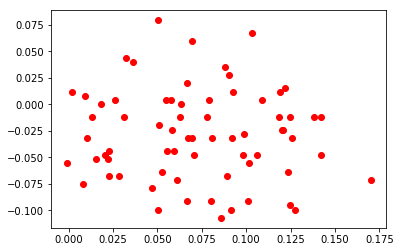

IS_ALPHA OOS_BETA


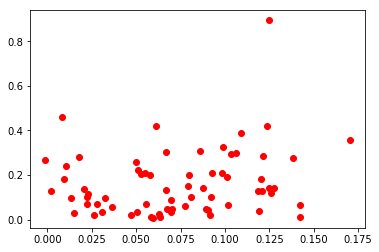

IS_ALPHA OOS_ANNUALIZED RETURN


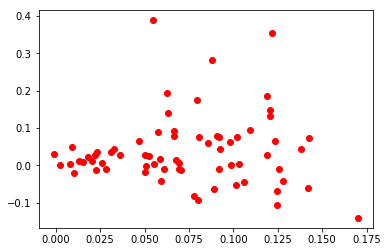

IS_ALPHA OOS_FACTOR SHARPE


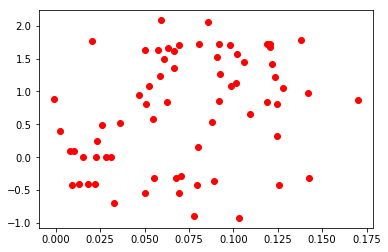

IS_ALPHA SLIPPAGE OOS_PROFITABILITY


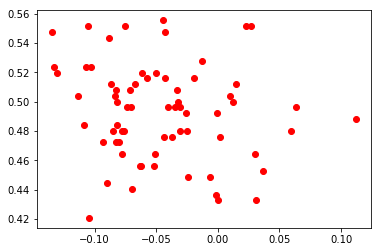

IS_ALPHA SLIPPAGE OOS_SHARPE DIFFERENCE SLIPPAGE


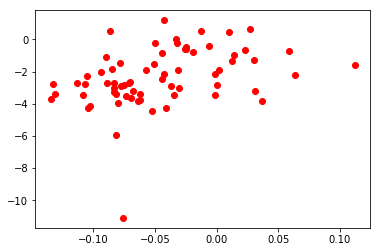

IS_ALPHA SLIPPAGE OOS_SHARPE


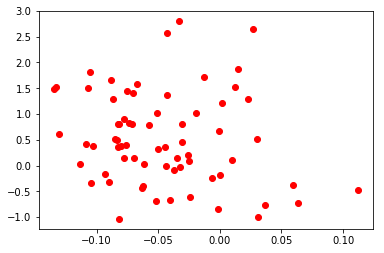

IS_ALPHA SLIPPAGE OOS_ALPHA


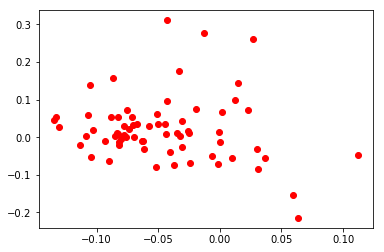

IS_ALPHA SLIPPAGE OOS_PROFITABILITY DIFFERENCE


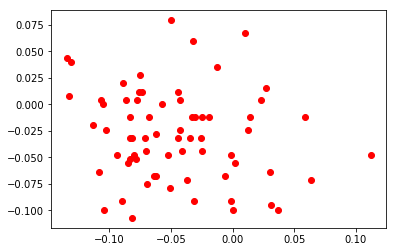

IS_ALPHA SLIPPAGE OOS_BETA


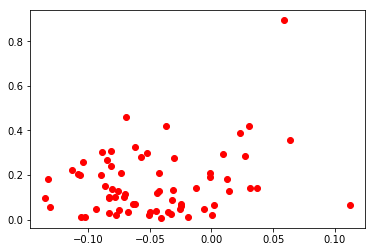

IS_ALPHA SLIPPAGE OOS_ANNUALIZED RETURN


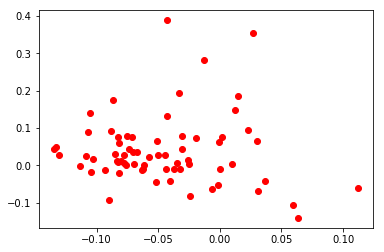

IS_ALPHA SLIPPAGE OOS_FACTOR SHARPE


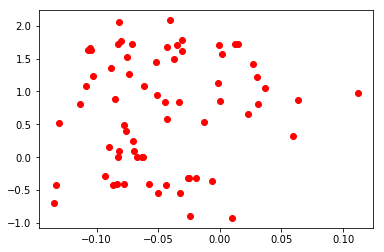

IS_ANNUALIZED RETURN OOS_PROFITABILITY


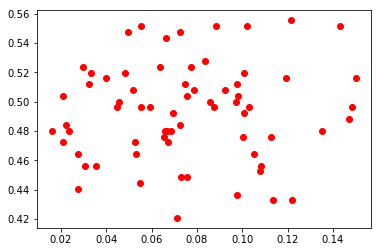

IS_ANNUALIZED RETURN OOS_SHARPE DIFFERENCE SLIPPAGE


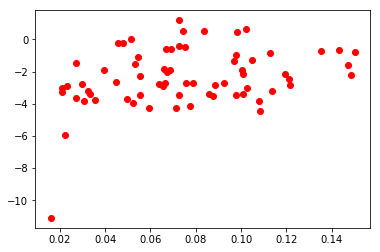

IS_ANNUALIZED RETURN OOS_SHARPE


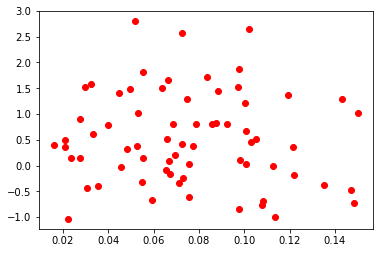

IS_ANNUALIZED RETURN OOS_ALPHA


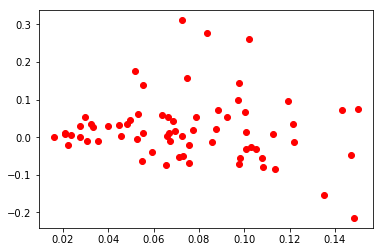

IS_ANNUALIZED RETURN OOS_PROFITABILITY DIFFERENCE


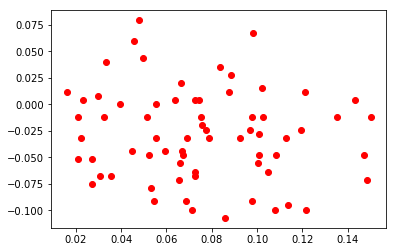

IS_ANNUALIZED RETURN OOS_BETA


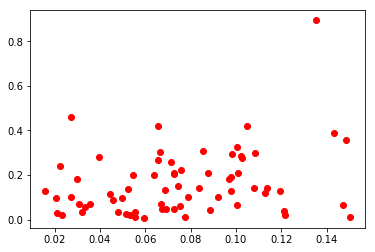

IS_ANNUALIZED RETURN OOS_ANNUALIZED RETURN


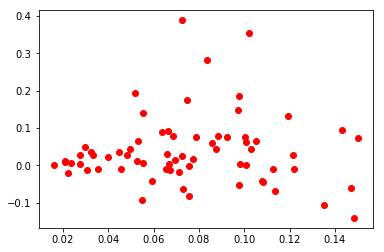

IS_ANNUALIZED RETURN OOS_FACTOR SHARPE


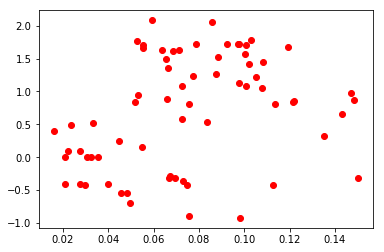

IS_BETA OOS_PROFITABILITY


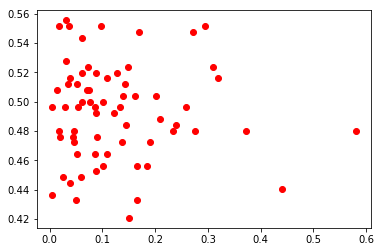

IS_BETA OOS_SHARPE DIFFERENCE SLIPPAGE


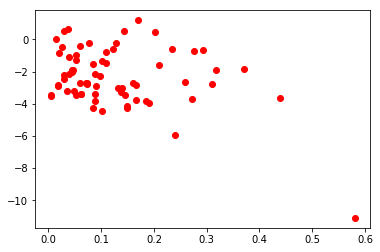

IS_BETA OOS_SHARPE


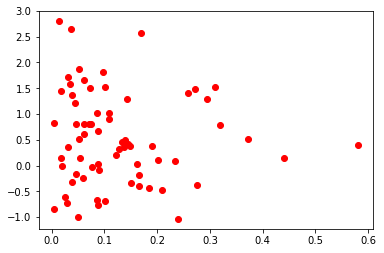

IS_BETA OOS_ALPHA


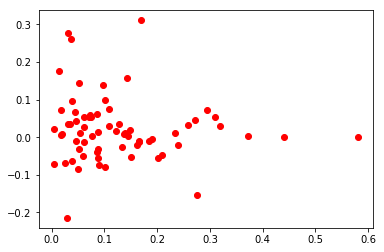

IS_BETA OOS_PROFITABILITY DIFFERENCE


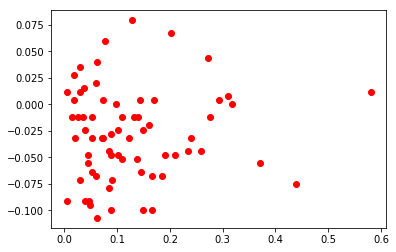

IS_BETA OOS_BETA


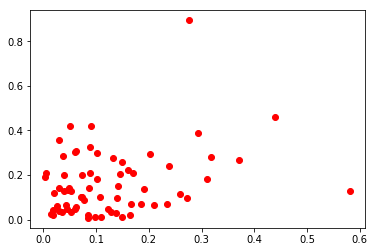

IS_BETA OOS_ANNUALIZED RETURN


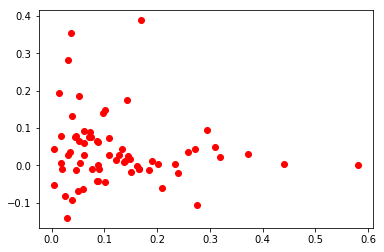

IS_BETA OOS_FACTOR SHARPE


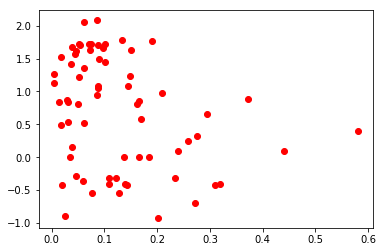

IS_EXTREME STABILITY OOS_PROFITABILITY


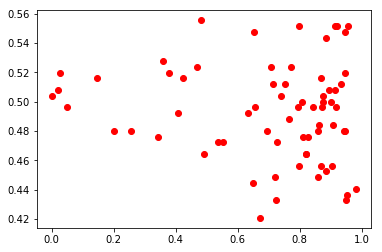

IS_EXTREME STABILITY OOS_SHARPE DIFFERENCE SLIPPAGE


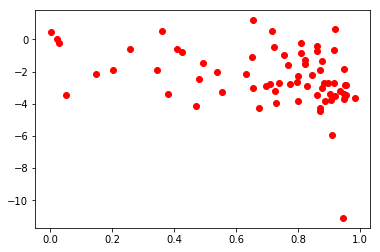

IS_EXTREME STABILITY OOS_SHARPE


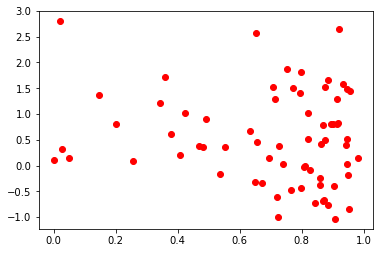

IS_EXTREME STABILITY OOS_ALPHA


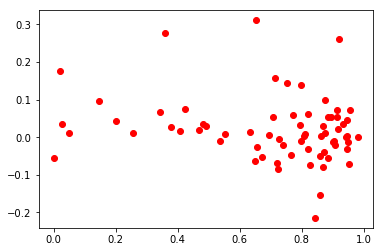

IS_EXTREME STABILITY OOS_PROFITABILITY DIFFERENCE


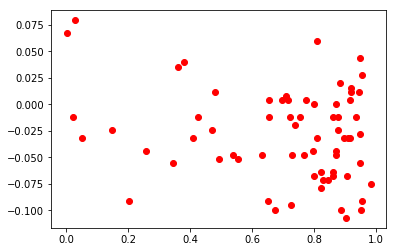

IS_EXTREME STABILITY OOS_BETA


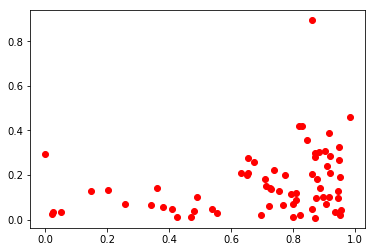

IS_EXTREME STABILITY OOS_ANNUALIZED RETURN


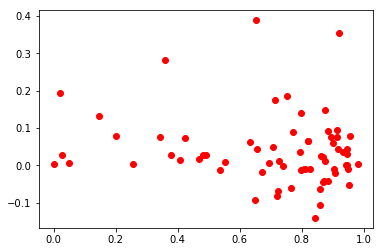

IS_EXTREME STABILITY OOS_FACTOR SHARPE


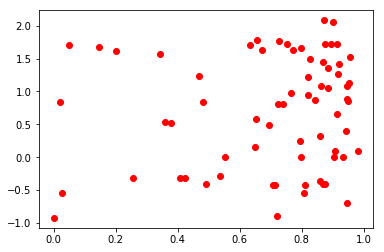

IS_EXTREME STABILITY ROLLING 600 OOS_PROFITABILITY


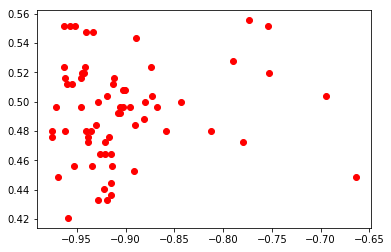

IS_EXTREME STABILITY ROLLING 600 OOS_SHARPE DIFFERENCE SLIPPAGE


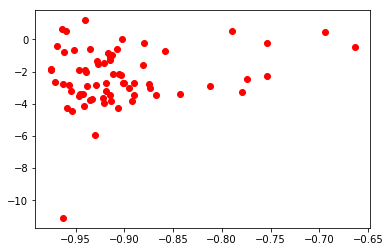

IS_EXTREME STABILITY ROLLING 600 OOS_SHARPE


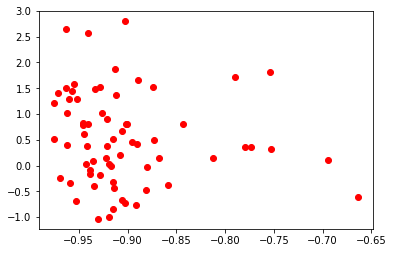

IS_EXTREME STABILITY ROLLING 600 OOS_ALPHA


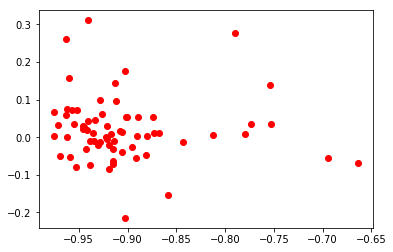

IS_EXTREME STABILITY ROLLING 600 OOS_PROFITABILITY DIFFERENCE


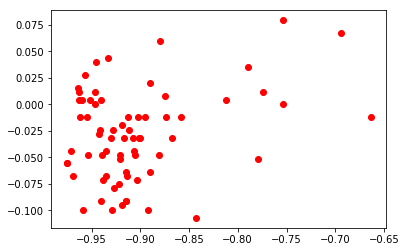

IS_EXTREME STABILITY ROLLING 600 OOS_BETA


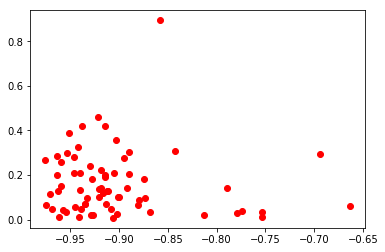

IS_EXTREME STABILITY ROLLING 600 OOS_ANNUALIZED RETURN


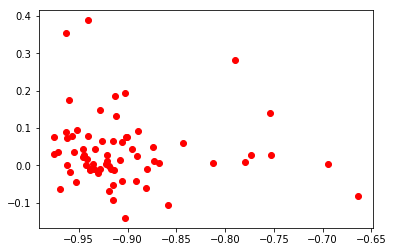

IS_EXTREME STABILITY ROLLING 600 OOS_FACTOR SHARPE


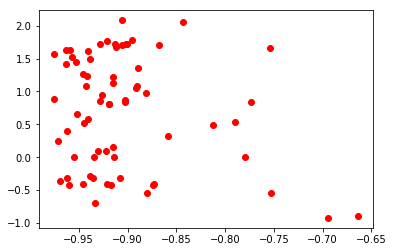

IS_FACTOR PROFITABILITY OOS_PROFITABILITY


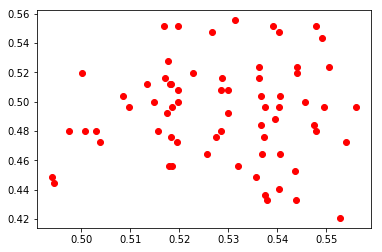

IS_FACTOR PROFITABILITY OOS_SHARPE DIFFERENCE SLIPPAGE


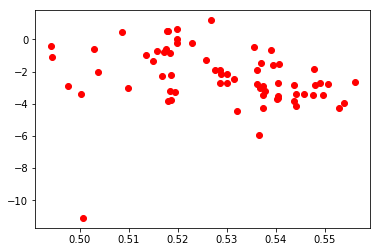

IS_FACTOR PROFITABILITY OOS_SHARPE


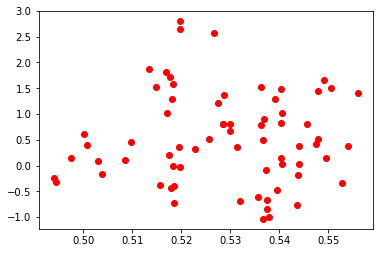

IS_FACTOR PROFITABILITY OOS_ALPHA


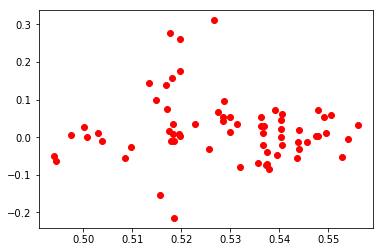

IS_FACTOR PROFITABILITY OOS_PROFITABILITY DIFFERENCE


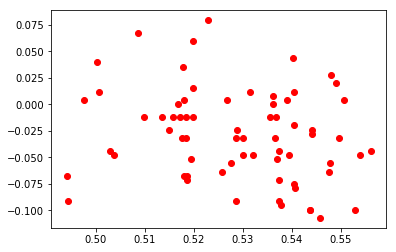

IS_FACTOR PROFITABILITY OOS_BETA


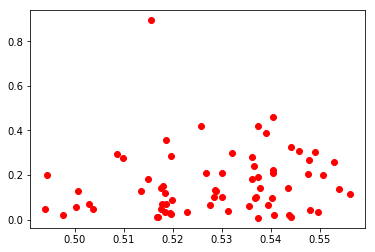

IS_FACTOR PROFITABILITY OOS_ANNUALIZED RETURN


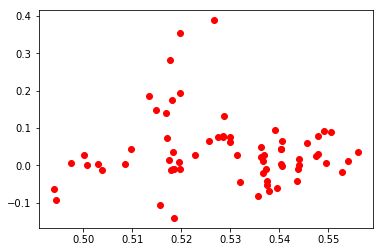

IS_FACTOR PROFITABILITY OOS_FACTOR SHARPE


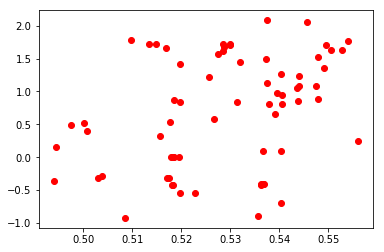

IS_FACTOR SHARPE OOS_PROFITABILITY


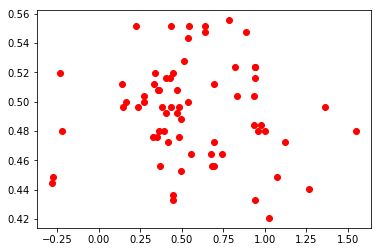

IS_FACTOR SHARPE OOS_SHARPE DIFFERENCE SLIPPAGE


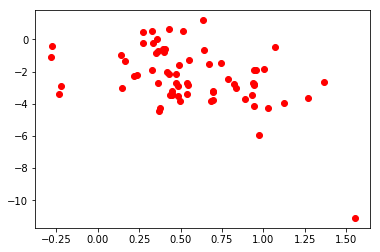

IS_FACTOR SHARPE OOS_SHARPE


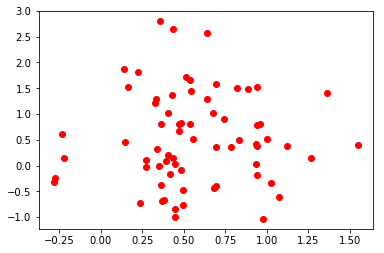

IS_FACTOR SHARPE OOS_ALPHA


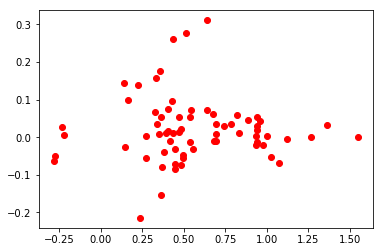

IS_FACTOR SHARPE OOS_PROFITABILITY DIFFERENCE


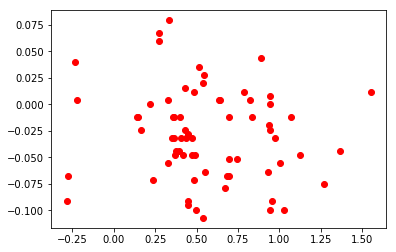

IS_FACTOR SHARPE OOS_BETA


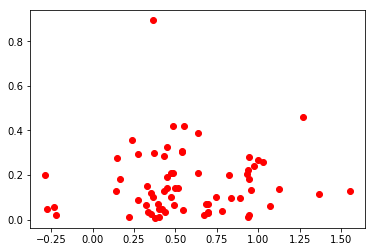

IS_FACTOR SHARPE OOS_ANNUALIZED RETURN


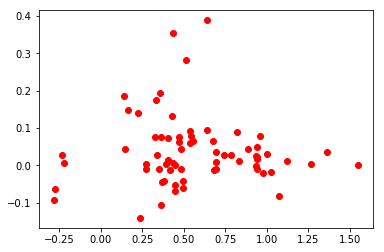

IS_FACTOR SHARPE OOS_FACTOR SHARPE


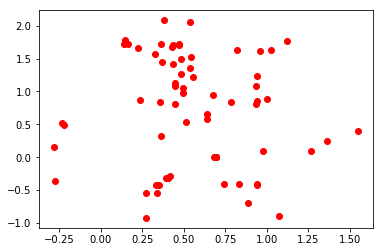

IS_MIN FACTOR PROFITABILITY 45
0.311111    0.501984
0.315111    0.444444
0.328000    0.448413
0.333333    0.485119
0.345778    0.551587
0.355556    0.482143
0.355556    0.502480
0.355556    0.511905
0.377778    0.496265
0.395778    0.507937
0.400000    0.486461
0.422222    0.472222
Name: OOS_PROFITABILITY, dtype: float64
IS_MIN FACTOR PROFITABILITY 45
0.311111   -1.629920
0.315111   -1.105553
0.328000   -0.437196
0.333333   -3.019674
0.345778    0.677710
0.355556   -1.297822
0.355556   -1.780279
0.355556   -0.943795
0.377778   -2.683473
0.395778   -2.704935
0.400000   -2.867482
0.422222   -3.657382
Name: OOS_SHARPE DIFFERENCE SLIPPAGE, dtype: float64
IS_MIN FACTOR PROFITABILITY 45
0.311111    0.526449
0.315111   -0.313140
0.328000   -0.232236
0.333333    0.150531
0.345778    2.651352
0.355556    0.023811
0.355556    0.898696
0.355556    1.864443
0.377778    0.352614
0.395778    0.811542
0.400000    0.382554
0.422222    0.514682
Name: OOS_SHARPE, dtype: float64
IS_MIN FACTOR PROFITABILI

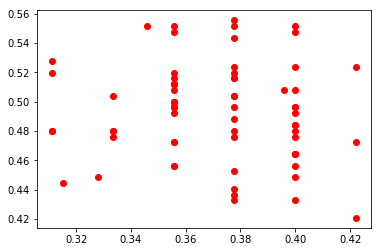

IS_MIN FACTOR PROFITABILITY 45 OOS_SHARPE DIFFERENCE SLIPPAGE


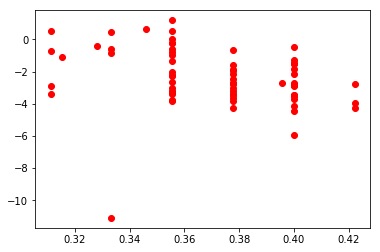

IS_MIN FACTOR PROFITABILITY 45 OOS_SHARPE


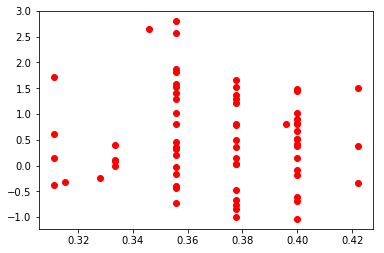

IS_MIN FACTOR PROFITABILITY 45 OOS_ALPHA


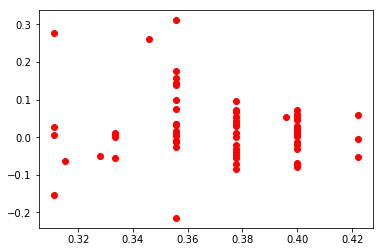

IS_MIN FACTOR PROFITABILITY 45 OOS_PROFITABILITY DIFFERENCE


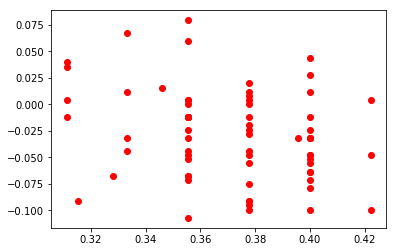

IS_MIN FACTOR PROFITABILITY 45 OOS_BETA


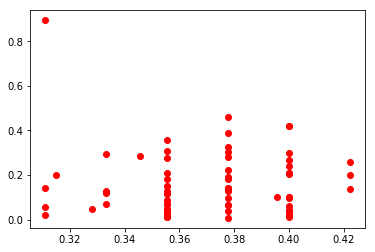

IS_MIN FACTOR PROFITABILITY 45 OOS_ANNUALIZED RETURN


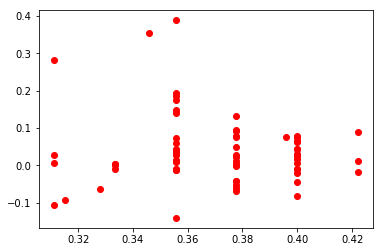

IS_MIN FACTOR PROFITABILITY 45 OOS_FACTOR SHARPE


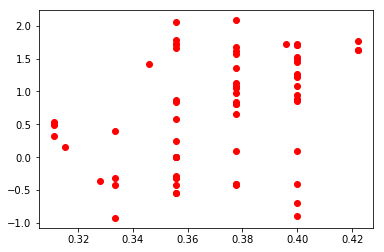

IS_MIN FACTOR PROFITABILITY 90 OOS_PROFITABILITY


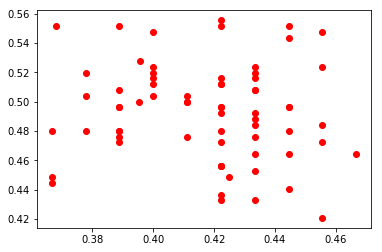

IS_MIN FACTOR PROFITABILITY 90 OOS_SHARPE DIFFERENCE SLIPPAGE


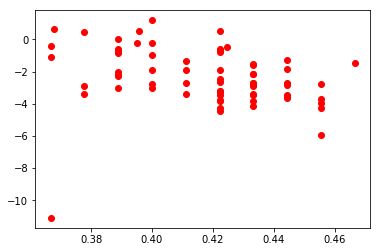

IS_MIN FACTOR PROFITABILITY 90 OOS_SHARPE


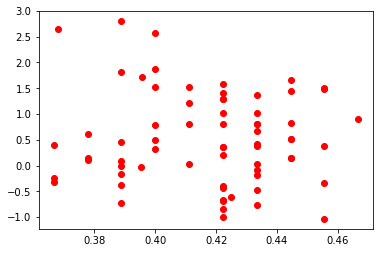

IS_MIN FACTOR PROFITABILITY 90 OOS_ALPHA


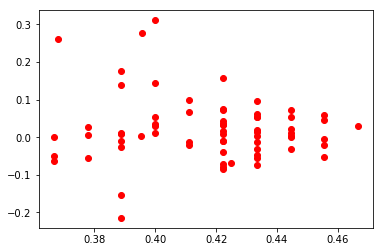

IS_MIN FACTOR PROFITABILITY 90 OOS_PROFITABILITY DIFFERENCE


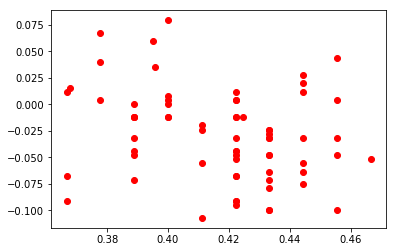

IS_MIN FACTOR PROFITABILITY 90 OOS_BETA


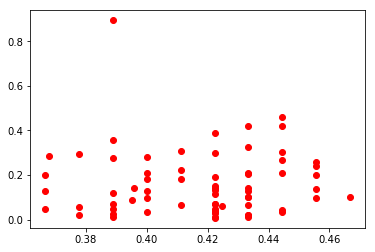

IS_MIN FACTOR PROFITABILITY 90 OOS_ANNUALIZED RETURN


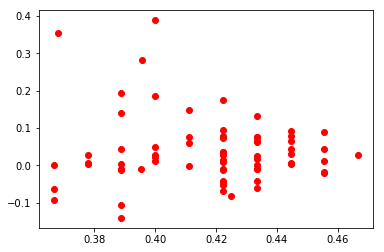

IS_MIN FACTOR PROFITABILITY 90 OOS_FACTOR SHARPE


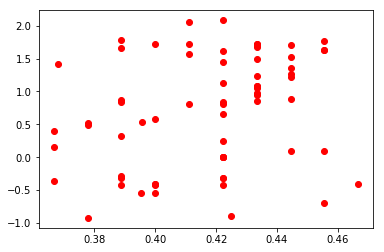

IS_MIN PROFITABILITY 45 OOS_PROFITABILITY


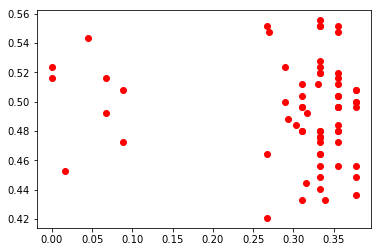

IS_MIN PROFITABILITY 45 OOS_SHARPE DIFFERENCE SLIPPAGE


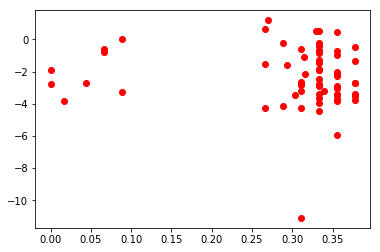

IS_MIN PROFITABILITY 45 OOS_SHARPE


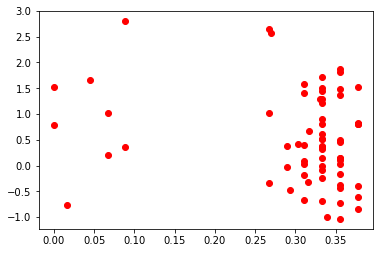

IS_MIN PROFITABILITY 45 OOS_ALPHA


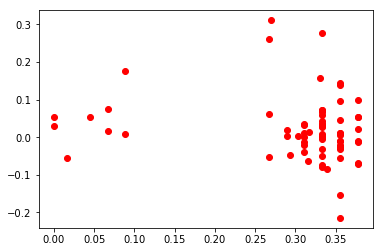

IS_MIN PROFITABILITY 45 OOS_PROFITABILITY DIFFERENCE


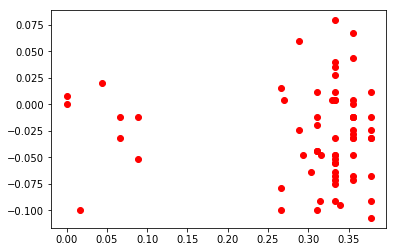

IS_MIN PROFITABILITY 45 OOS_BETA


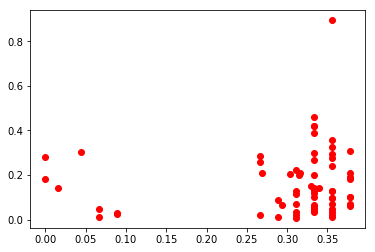

IS_MIN PROFITABILITY 45 OOS_ANNUALIZED RETURN


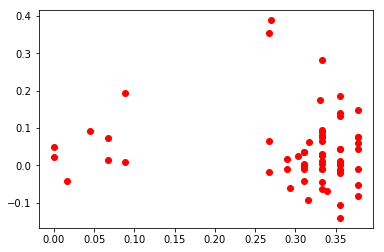

IS_MIN PROFITABILITY 45 OOS_FACTOR SHARPE


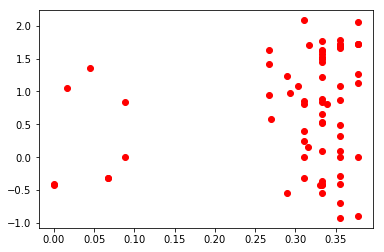

IS_MIN PROFITABILITY 90 OOS_PROFITABILITY


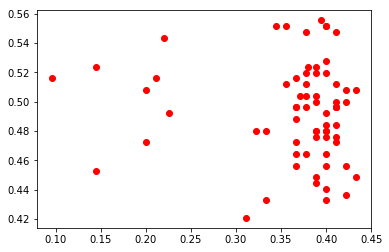

IS_MIN PROFITABILITY 90 OOS_SHARPE DIFFERENCE SLIPPAGE


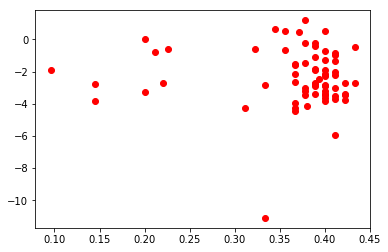

IS_MIN PROFITABILITY 90 OOS_SHARPE


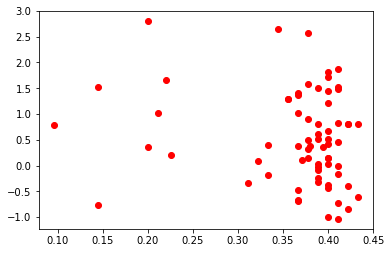

IS_MIN PROFITABILITY 90 OOS_ALPHA


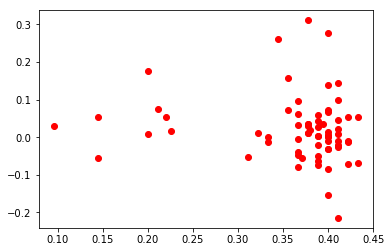

IS_MIN PROFITABILITY 90 OOS_PROFITABILITY DIFFERENCE


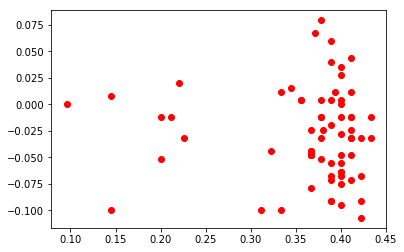

IS_MIN PROFITABILITY 90 OOS_BETA


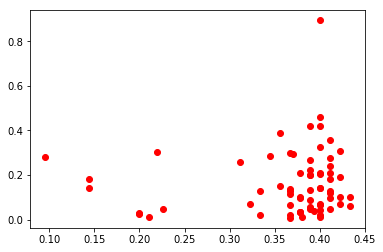

IS_MIN PROFITABILITY 90 OOS_ANNUALIZED RETURN


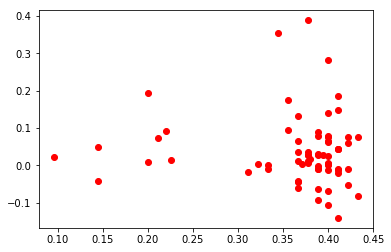

IS_MIN PROFITABILITY 90 OOS_FACTOR SHARPE


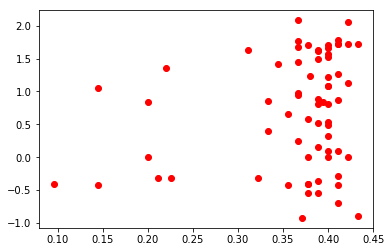

IS_MIN PROFITABILITY DIFFERENCE 45 OOS_PROFITABILITY


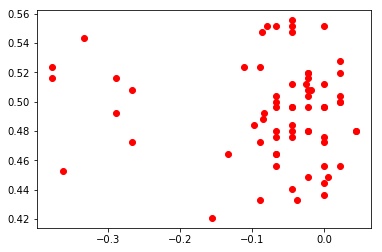

IS_MIN PROFITABILITY DIFFERENCE 45 OOS_SHARPE DIFFERENCE SLIPPAGE


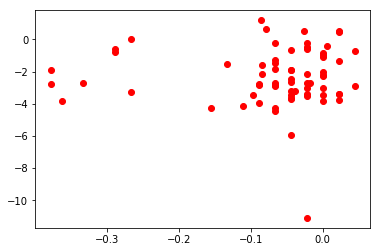

IS_MIN PROFITABILITY DIFFERENCE 45 OOS_SHARPE


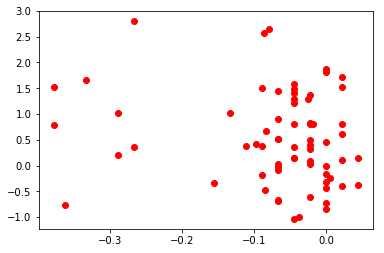

IS_MIN PROFITABILITY DIFFERENCE 45 OOS_ALPHA


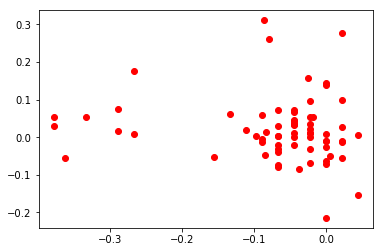

IS_MIN PROFITABILITY DIFFERENCE 45 OOS_PROFITABILITY DIFFERENCE


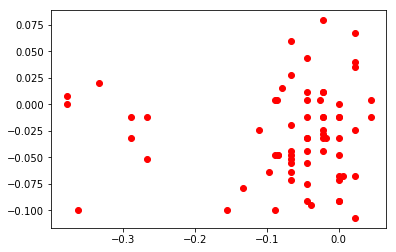

IS_MIN PROFITABILITY DIFFERENCE 45 OOS_BETA


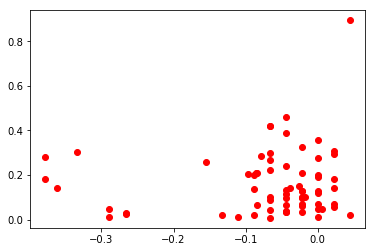

IS_MIN PROFITABILITY DIFFERENCE 45 OOS_ANNUALIZED RETURN


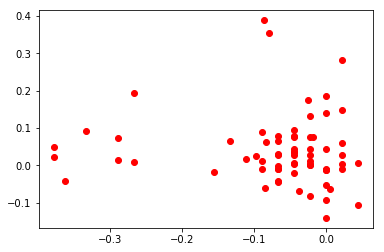

IS_MIN PROFITABILITY DIFFERENCE 45 OOS_FACTOR SHARPE


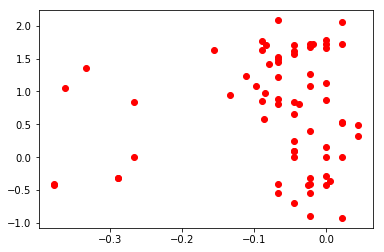

IS_MIN PROFITABILITY DIFFERENCE 90 OOS_PROFITABILITY


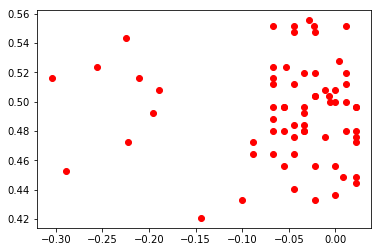

IS_MIN PROFITABILITY DIFFERENCE 90 OOS_SHARPE DIFFERENCE SLIPPAGE


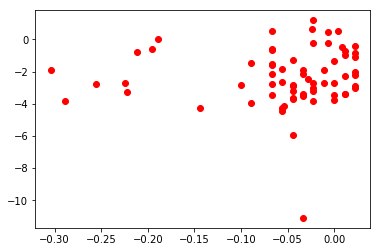

IS_MIN PROFITABILITY DIFFERENCE 90 OOS_SHARPE


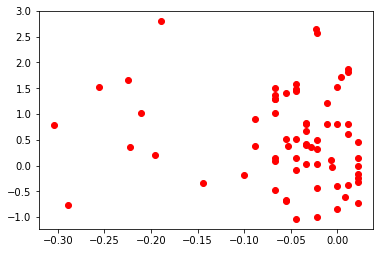

IS_MIN PROFITABILITY DIFFERENCE 90 OOS_ALPHA


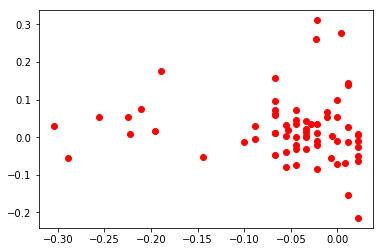

IS_MIN PROFITABILITY DIFFERENCE 90 OOS_PROFITABILITY DIFFERENCE


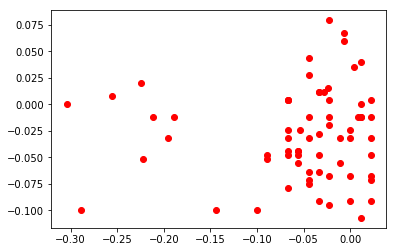

IS_MIN PROFITABILITY DIFFERENCE 90 OOS_BETA


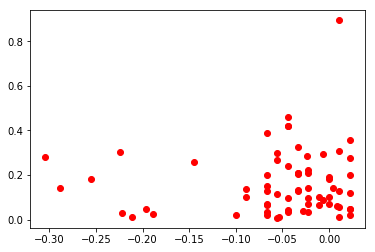

IS_MIN PROFITABILITY DIFFERENCE 90 OOS_ANNUALIZED RETURN


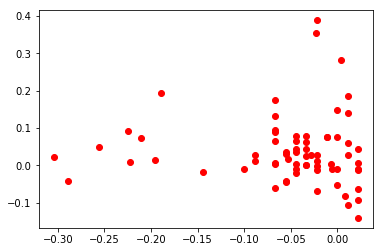

IS_MIN PROFITABILITY DIFFERENCE 90 OOS_FACTOR SHARPE


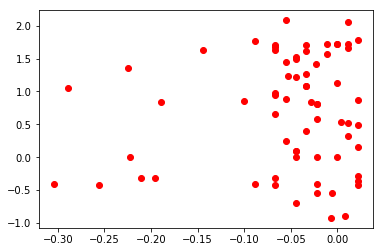

IS_MIN ROLLING SHARPE OOS_PROFITABILITY


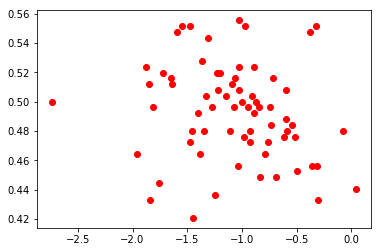

IS_MIN ROLLING SHARPE OOS_SHARPE DIFFERENCE SLIPPAGE


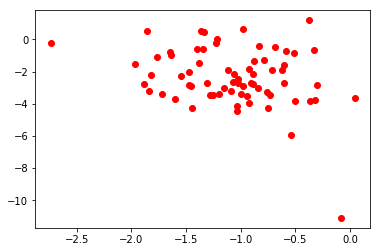

IS_MIN ROLLING SHARPE OOS_SHARPE


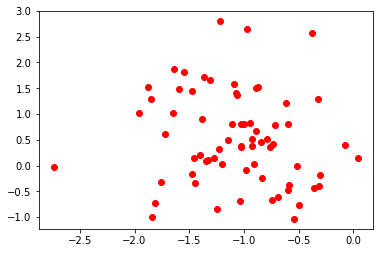

IS_MIN ROLLING SHARPE OOS_ALPHA


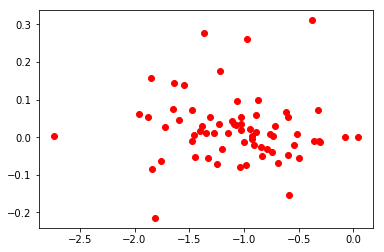

IS_MIN ROLLING SHARPE OOS_PROFITABILITY DIFFERENCE


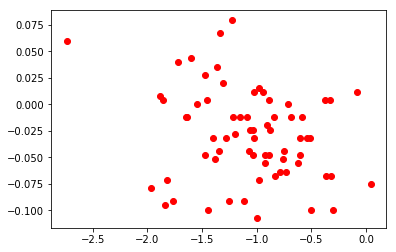

IS_MIN ROLLING SHARPE OOS_BETA


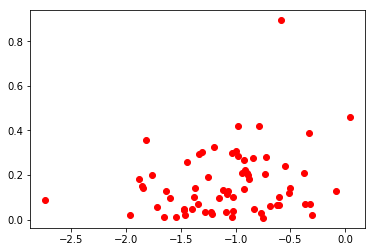

IS_MIN ROLLING SHARPE OOS_ANNUALIZED RETURN


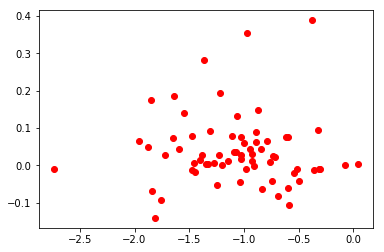

IS_MIN ROLLING SHARPE OOS_FACTOR SHARPE


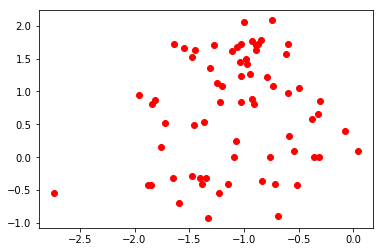

IS_MIN ROLLING SHARPE 45 OOS_PROFITABILITY


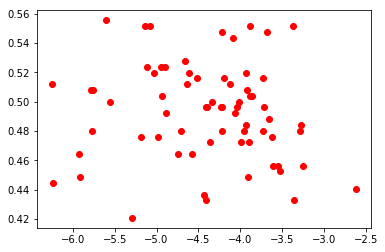

IS_MIN ROLLING SHARPE 45 OOS_SHARPE DIFFERENCE SLIPPAGE


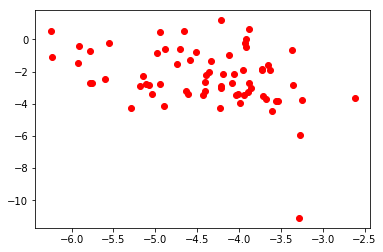

IS_MIN ROLLING SHARPE 45 OOS_SHARPE


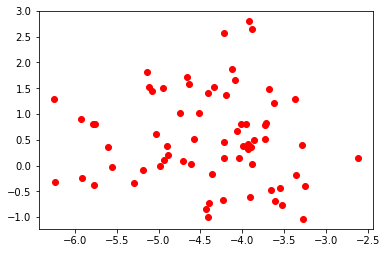

IS_MIN ROLLING SHARPE 45 OOS_ALPHA


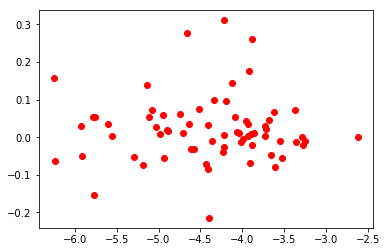

IS_MIN ROLLING SHARPE 45 OOS_PROFITABILITY DIFFERENCE


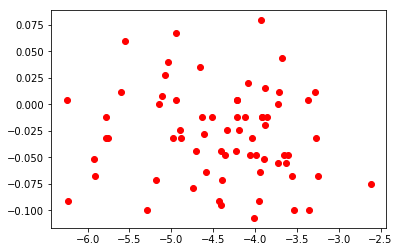

IS_MIN ROLLING SHARPE 45 OOS_BETA


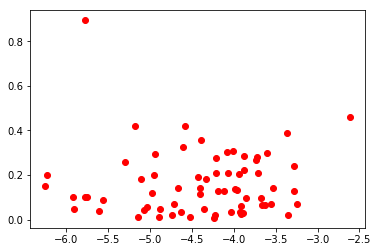

IS_MIN ROLLING SHARPE 45 OOS_ANNUALIZED RETURN


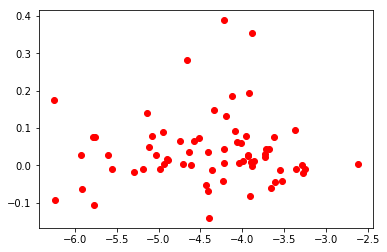

IS_MIN ROLLING SHARPE 45 OOS_FACTOR SHARPE


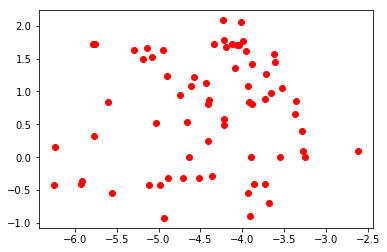

IS_MIN ROLLING SHARPE 90 OOS_PROFITABILITY


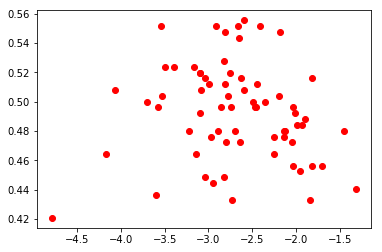

IS_MIN ROLLING SHARPE 90 OOS_SHARPE DIFFERENCE SLIPPAGE


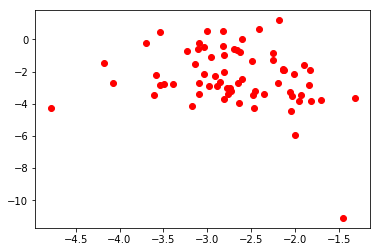

IS_MIN ROLLING SHARPE 90 OOS_SHARPE


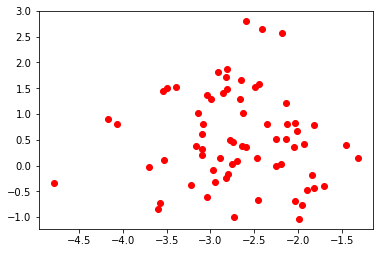

IS_MIN ROLLING SHARPE 90 OOS_ALPHA


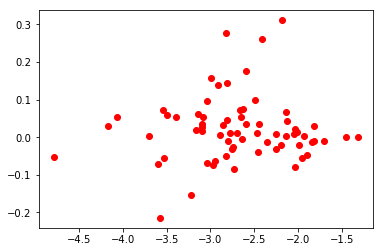

IS_MIN ROLLING SHARPE 90 OOS_PROFITABILITY DIFFERENCE


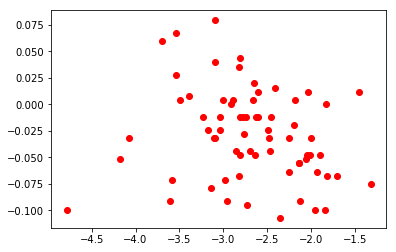

IS_MIN ROLLING SHARPE 90 OOS_BETA


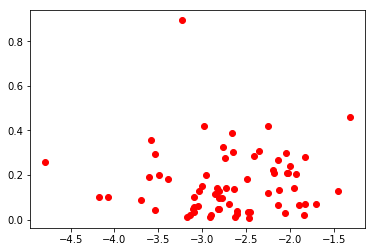

IS_MIN ROLLING SHARPE 90 OOS_ANNUALIZED RETURN


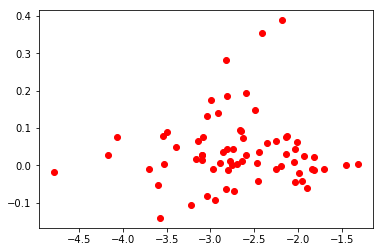

IS_MIN ROLLING SHARPE 90 OOS_FACTOR SHARPE


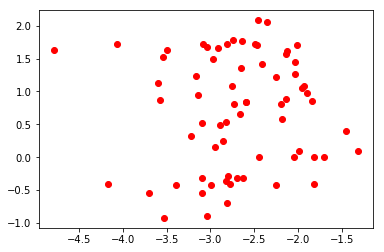

IS_ONE STD SHARPE OOS_PROFITABILITY


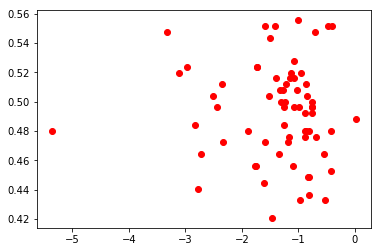

IS_ONE STD SHARPE OOS_SHARPE DIFFERENCE SLIPPAGE


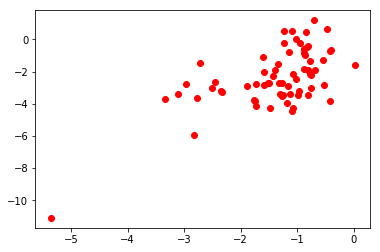

IS_ONE STD SHARPE OOS_SHARPE


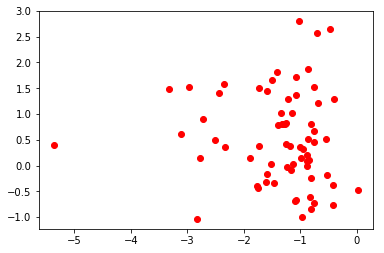

IS_ONE STD SHARPE OOS_ALPHA


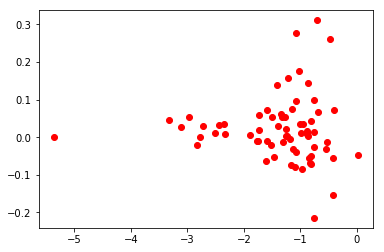

IS_ONE STD SHARPE OOS_PROFITABILITY DIFFERENCE


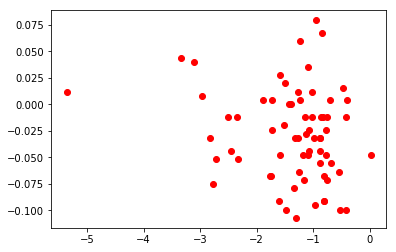

IS_ONE STD SHARPE OOS_BETA


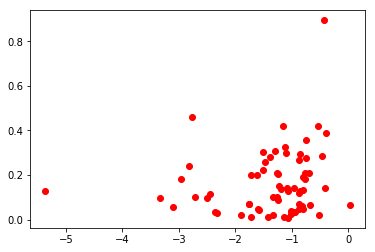

IS_ONE STD SHARPE OOS_ANNUALIZED RETURN


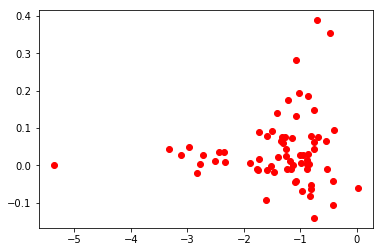

IS_ONE STD SHARPE OOS_FACTOR SHARPE


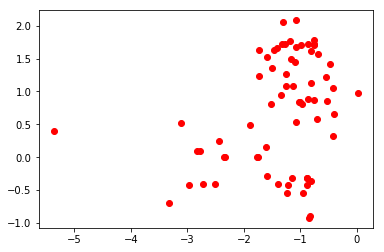

IS_PROFITABILITY OOS_PROFITABILITY


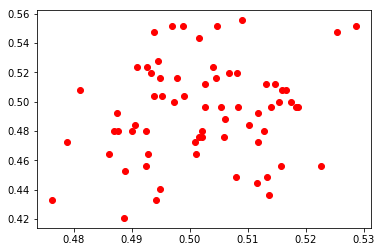

IS_PROFITABILITY OOS_SHARPE DIFFERENCE SLIPPAGE


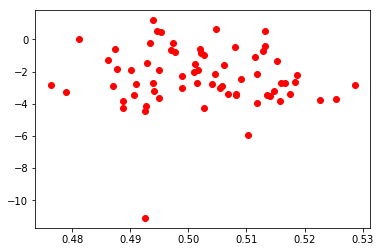

IS_PROFITABILITY OOS_SHARPE


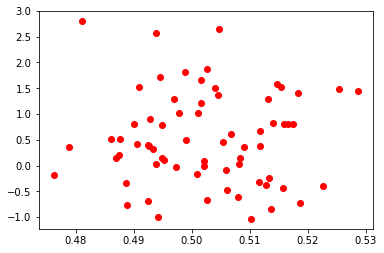

IS_PROFITABILITY OOS_ALPHA


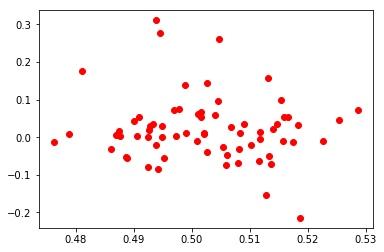

IS_PROFITABILITY OOS_PROFITABILITY DIFFERENCE


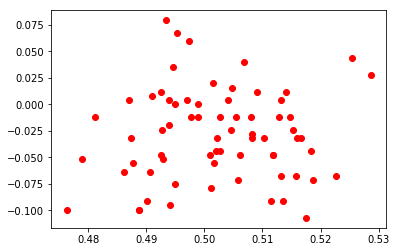

IS_PROFITABILITY OOS_BETA


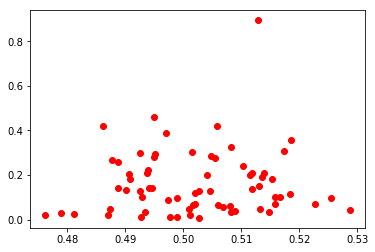

IS_PROFITABILITY OOS_ANNUALIZED RETURN


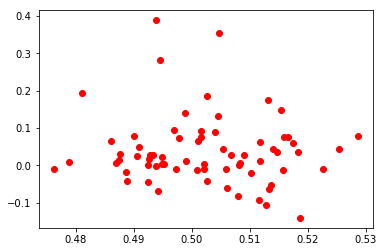

IS_PROFITABILITY OOS_FACTOR SHARPE


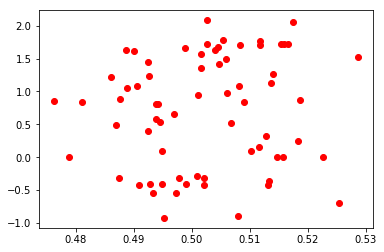

IS_PROFITABILITY DIFFERENCE OOS_PROFITABILITY


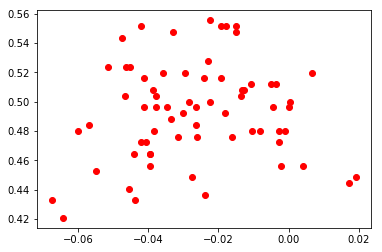

IS_PROFITABILITY DIFFERENCE OOS_SHARPE DIFFERENCE SLIPPAGE


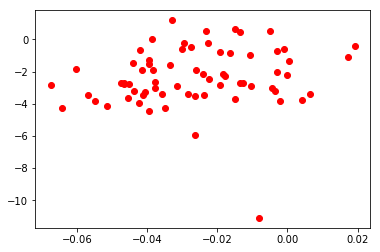

IS_PROFITABILITY DIFFERENCE OOS_SHARPE


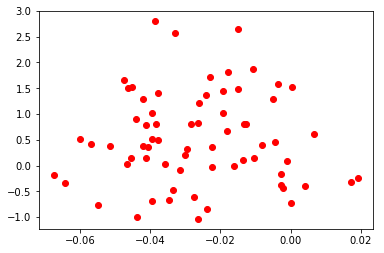

IS_PROFITABILITY DIFFERENCE OOS_ALPHA


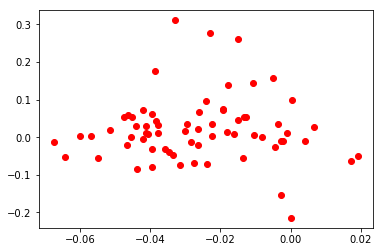

IS_PROFITABILITY DIFFERENCE OOS_PROFITABILITY DIFFERENCE


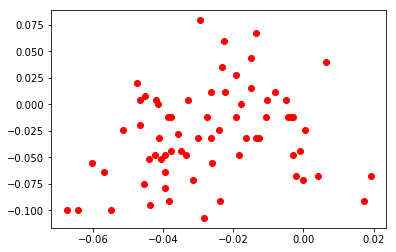

IS_PROFITABILITY DIFFERENCE OOS_BETA


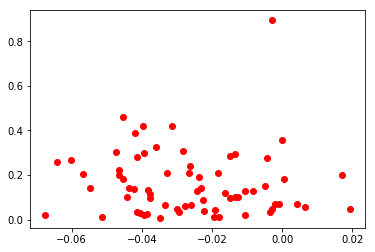

IS_PROFITABILITY DIFFERENCE OOS_ANNUALIZED RETURN


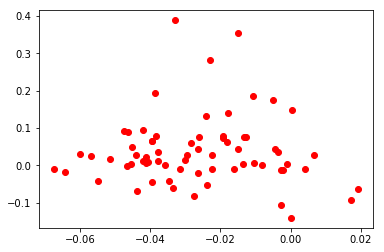

IS_PROFITABILITY DIFFERENCE OOS_FACTOR SHARPE


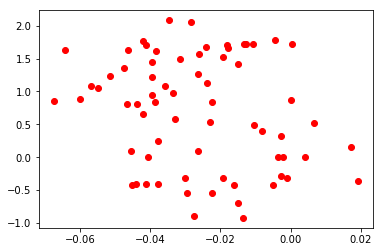

IS_PROFITABILITY DROP 45 OOS_PROFITABILITY


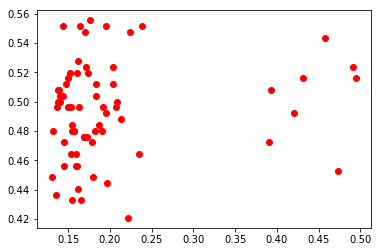

IS_PROFITABILITY DROP 45 OOS_SHARPE DIFFERENCE SLIPPAGE


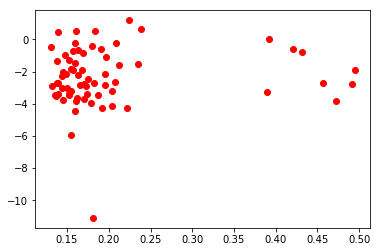

IS_PROFITABILITY DROP 45 OOS_SHARPE


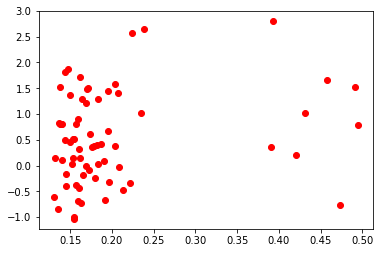

IS_PROFITABILITY DROP 45 OOS_ALPHA


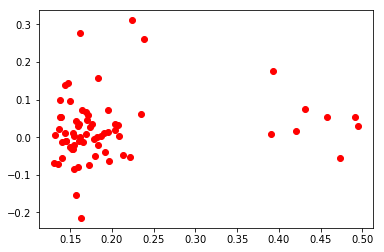

IS_PROFITABILITY DROP 45 OOS_PROFITABILITY DIFFERENCE


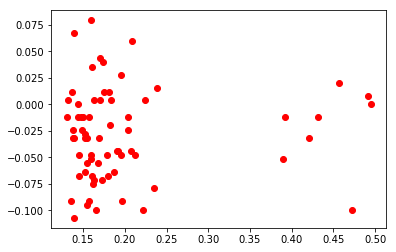

IS_PROFITABILITY DROP 45 OOS_BETA


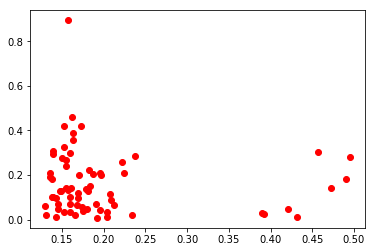

IS_PROFITABILITY DROP 45 OOS_ANNUALIZED RETURN


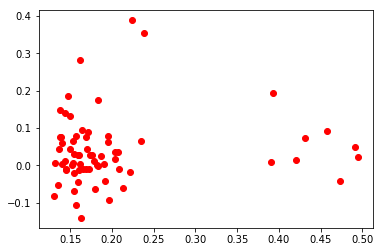

IS_PROFITABILITY DROP 45 OOS_FACTOR SHARPE


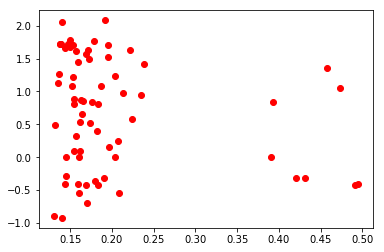

IS_PROFITABILITY DROP 90 OOS_PROFITABILITY


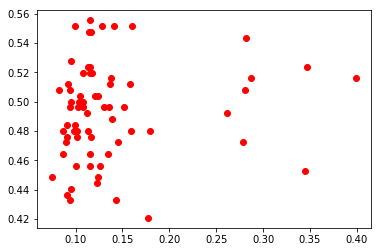

IS_PROFITABILITY DROP 90 OOS_SHARPE DIFFERENCE SLIPPAGE


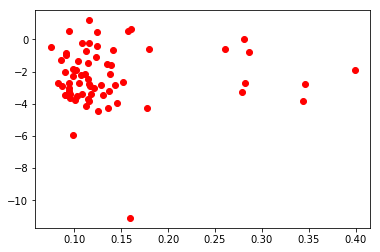

IS_PROFITABILITY DROP 90 OOS_SHARPE


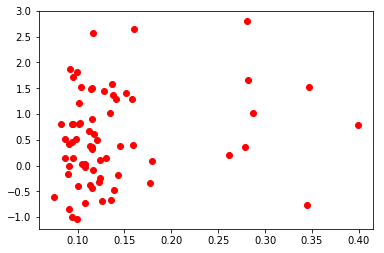

IS_PROFITABILITY DROP 90 OOS_ALPHA


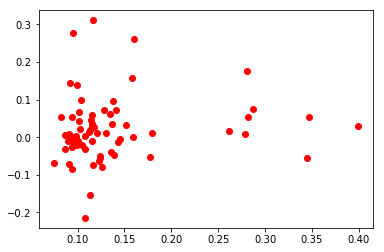

IS_PROFITABILITY DROP 90 OOS_PROFITABILITY DIFFERENCE


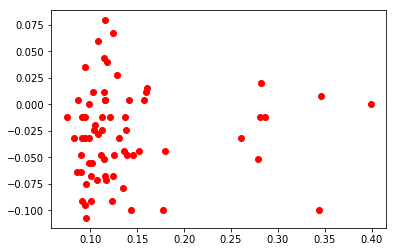

IS_PROFITABILITY DROP 90 OOS_BETA


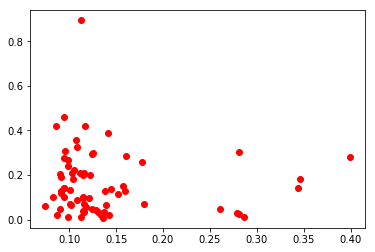

IS_PROFITABILITY DROP 90 OOS_ANNUALIZED RETURN


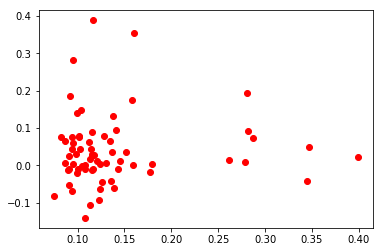

IS_PROFITABILITY DROP 90 OOS_FACTOR SHARPE


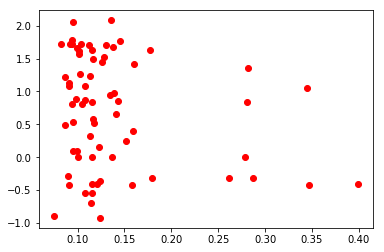

IS_PROFITABILITY SLIPPAGE OOS_PROFITABILITY


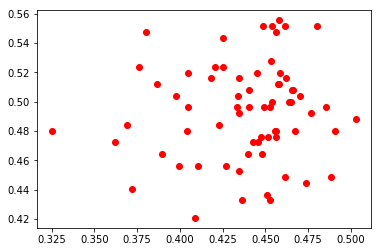

IS_PROFITABILITY SLIPPAGE OOS_SHARPE DIFFERENCE SLIPPAGE


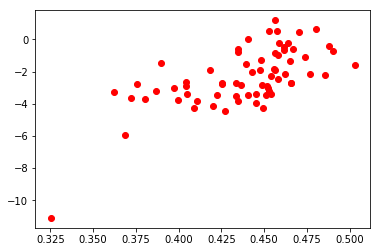

IS_PROFITABILITY SLIPPAGE OOS_SHARPE


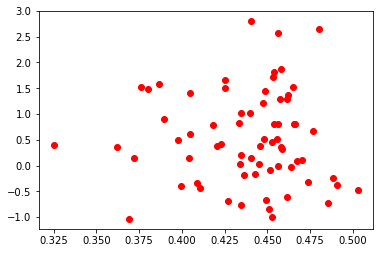

IS_PROFITABILITY SLIPPAGE OOS_ALPHA


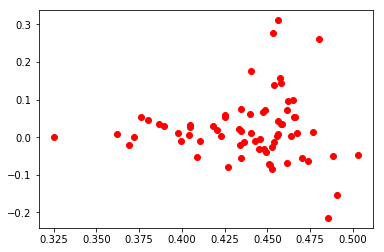

IS_PROFITABILITY SLIPPAGE OOS_PROFITABILITY DIFFERENCE


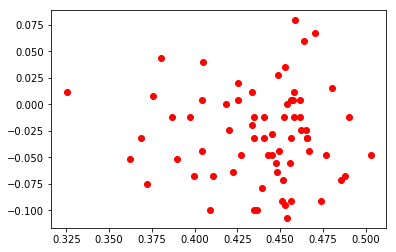

IS_PROFITABILITY SLIPPAGE OOS_BETA


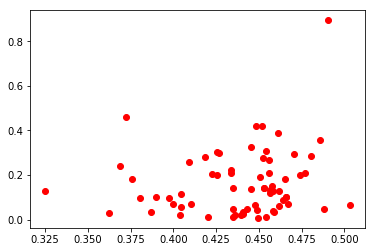

IS_PROFITABILITY SLIPPAGE OOS_ANNUALIZED RETURN


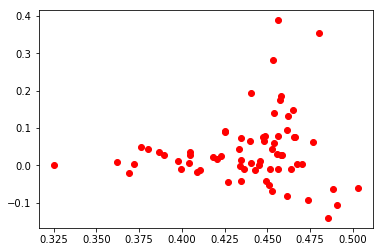

IS_PROFITABILITY SLIPPAGE OOS_FACTOR SHARPE


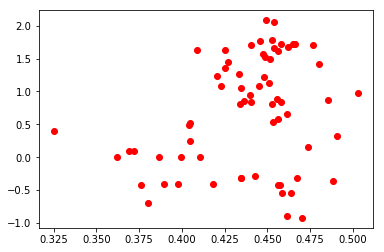

IS_RAW BETA OOS_PROFITABILITY


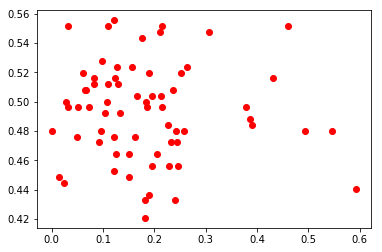

IS_RAW BETA OOS_SHARPE DIFFERENCE SLIPPAGE


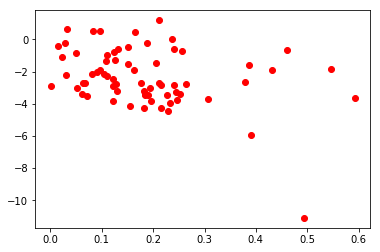

IS_RAW BETA OOS_SHARPE


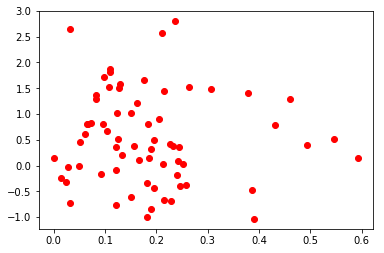

IS_RAW BETA OOS_ALPHA


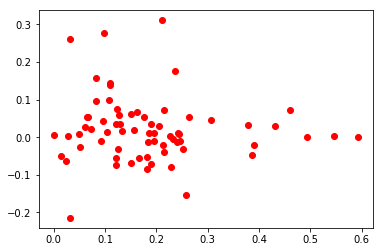

IS_RAW BETA OOS_PROFITABILITY DIFFERENCE


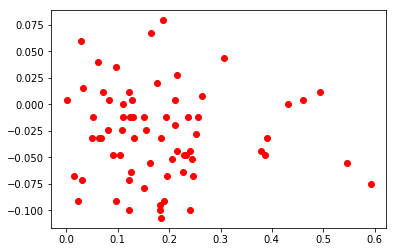

IS_RAW BETA OOS_BETA


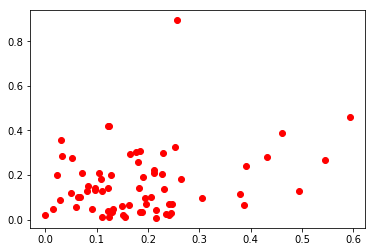

IS_RAW BETA OOS_ANNUALIZED RETURN


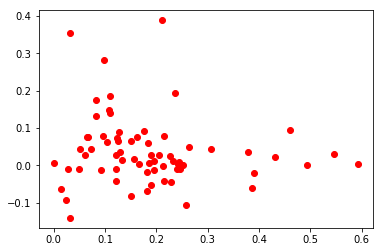

IS_RAW BETA OOS_FACTOR SHARPE


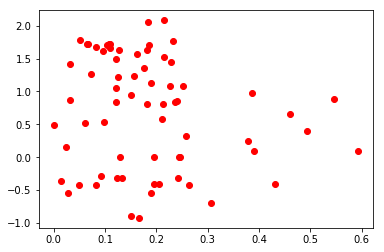

IS_RELATIVE SHARPE OOS_PROFITABILITY


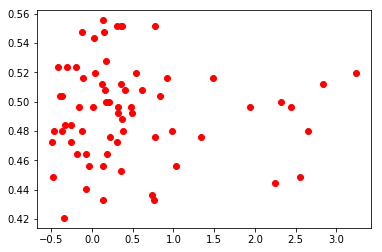

IS_RELATIVE SHARPE OOS_SHARPE DIFFERENCE SLIPPAGE


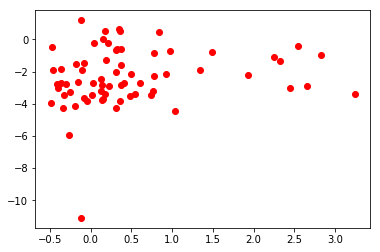

IS_RELATIVE SHARPE OOS_SHARPE


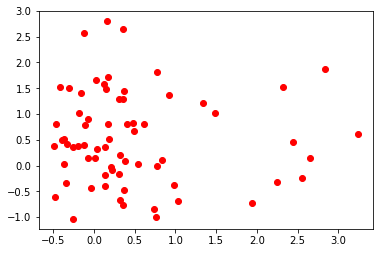

IS_RELATIVE SHARPE OOS_ALPHA


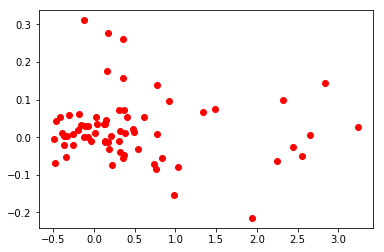

IS_RELATIVE SHARPE OOS_PROFITABILITY DIFFERENCE


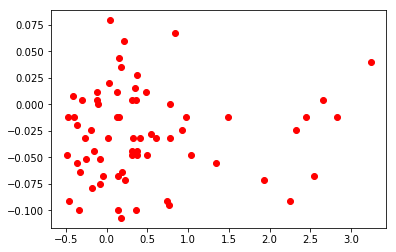

IS_RELATIVE SHARPE OOS_BETA


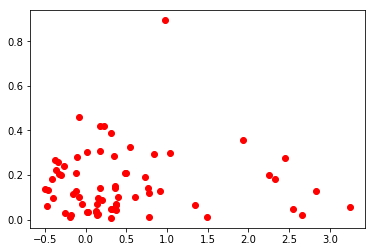

IS_RELATIVE SHARPE OOS_ANNUALIZED RETURN


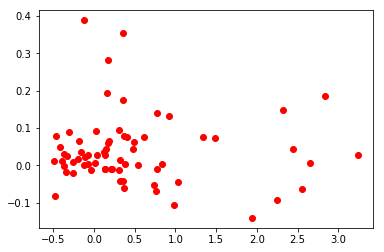

IS_RELATIVE SHARPE OOS_FACTOR SHARPE


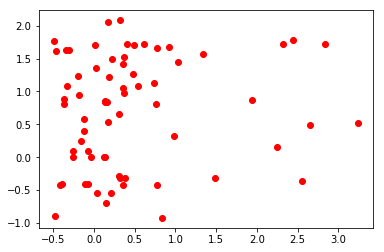

IS_RELATIVE SHARPE DIFFERENCE AVERAGE OOS_PROFITABILITY


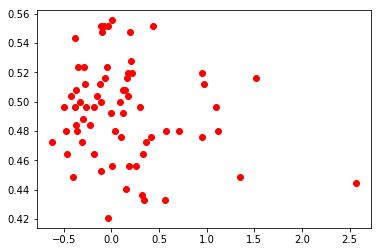

IS_RELATIVE SHARPE DIFFERENCE AVERAGE OOS_SHARPE DIFFERENCE SLIPPAGE


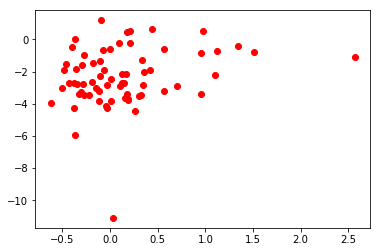

IS_RELATIVE SHARPE DIFFERENCE AVERAGE OOS_SHARPE


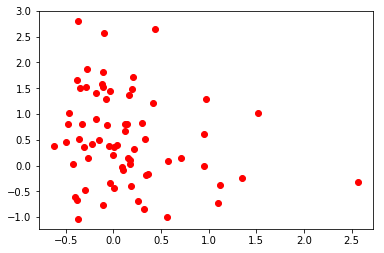

IS_RELATIVE SHARPE DIFFERENCE AVERAGE OOS_ALPHA


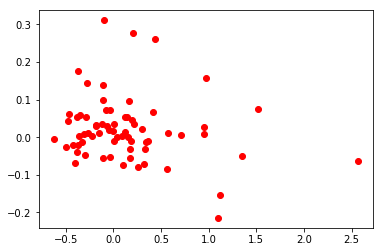

IS_RELATIVE SHARPE DIFFERENCE AVERAGE OOS_PROFITABILITY DIFFERENCE


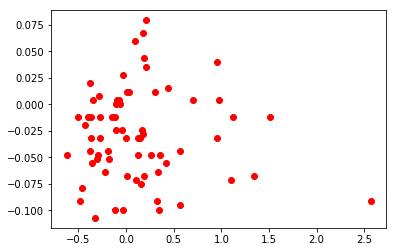

IS_RELATIVE SHARPE DIFFERENCE AVERAGE OOS_BETA


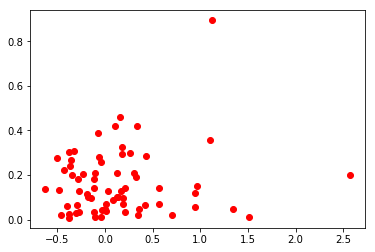

IS_RELATIVE SHARPE DIFFERENCE AVERAGE OOS_ANNUALIZED RETURN


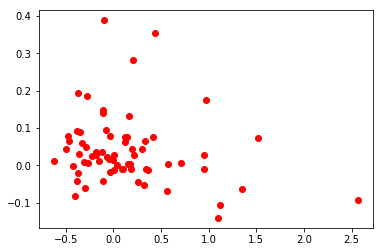

IS_RELATIVE SHARPE DIFFERENCE AVERAGE OOS_FACTOR SHARPE


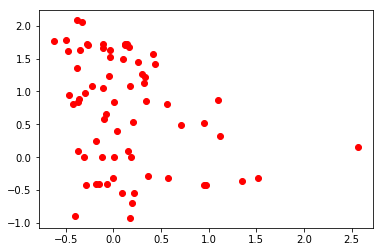

IS_RELATIVE SHARPE DIFFERENCE GREATER THAN 0 OOS_PROFITABILITY


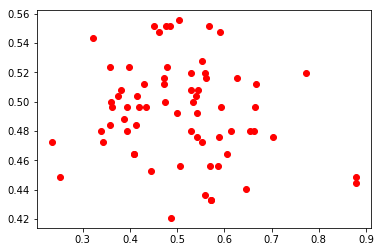

IS_RELATIVE SHARPE DIFFERENCE GREATER THAN 0 OOS_SHARPE DIFFERENCE SLIPPAGE


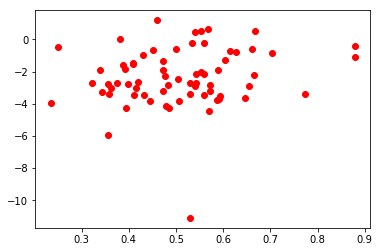

IS_RELATIVE SHARPE DIFFERENCE GREATER THAN 0 OOS_SHARPE


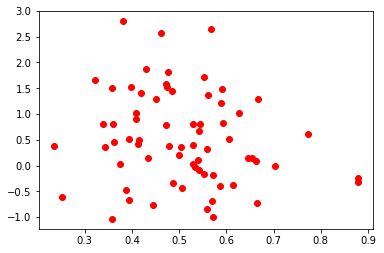

IS_RELATIVE SHARPE DIFFERENCE GREATER THAN 0 OOS_ALPHA


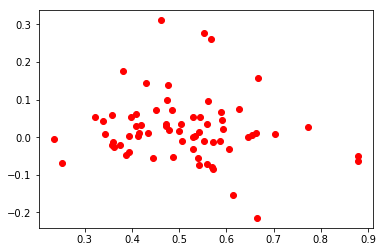

IS_RELATIVE SHARPE DIFFERENCE GREATER THAN 0 OOS_PROFITABILITY DIFFERENCE


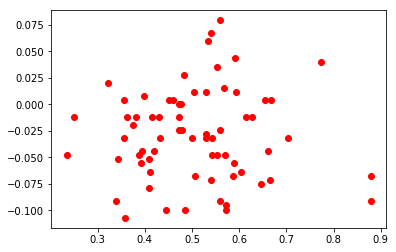

IS_RELATIVE SHARPE DIFFERENCE GREATER THAN 0 OOS_BETA


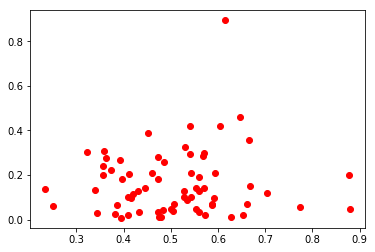

IS_RELATIVE SHARPE DIFFERENCE GREATER THAN 0 OOS_ANNUALIZED RETURN


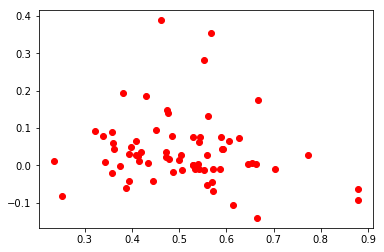

IS_RELATIVE SHARPE DIFFERENCE GREATER THAN 0 OOS_FACTOR SHARPE


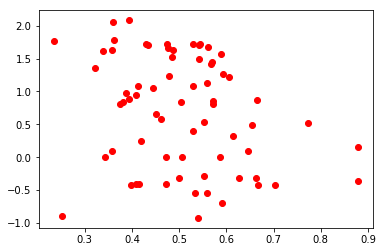

IS_RELATIVE SHARPE DIFFERENCE MIN OOS_PROFITABILITY


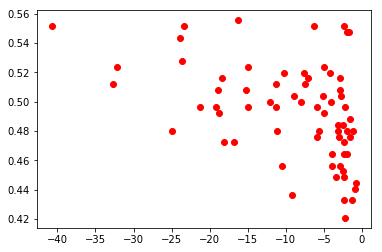

IS_RELATIVE SHARPE DIFFERENCE MIN OOS_SHARPE DIFFERENCE SLIPPAGE


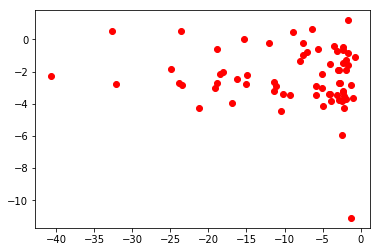

IS_RELATIVE SHARPE DIFFERENCE MIN OOS_SHARPE


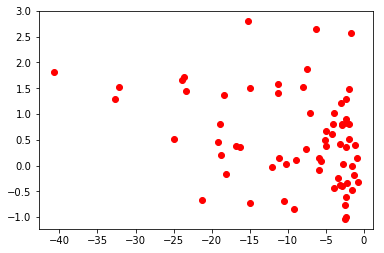

IS_RELATIVE SHARPE DIFFERENCE MIN OOS_ALPHA


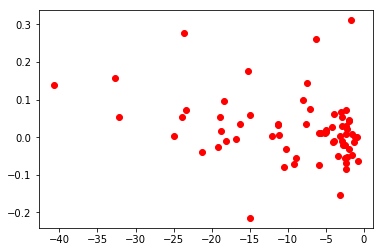

IS_RELATIVE SHARPE DIFFERENCE MIN OOS_PROFITABILITY DIFFERENCE


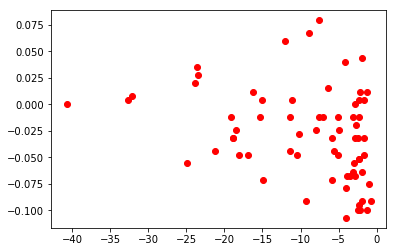

IS_RELATIVE SHARPE DIFFERENCE MIN OOS_BETA


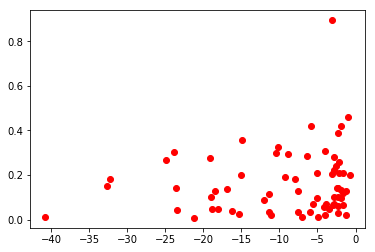

IS_RELATIVE SHARPE DIFFERENCE MIN OOS_ANNUALIZED RETURN


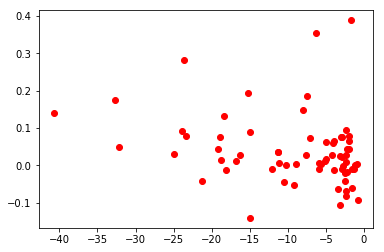

IS_RELATIVE SHARPE DIFFERENCE MIN OOS_FACTOR SHARPE


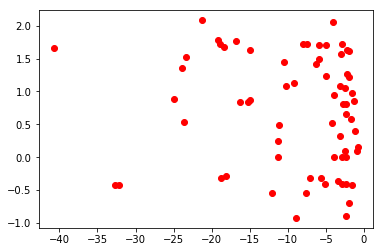

IS_RELATIVE SHARPE SLIPPAGE OOS_PROFITABILITY


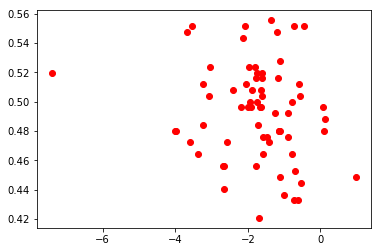

IS_RELATIVE SHARPE SLIPPAGE OOS_SHARPE DIFFERENCE SLIPPAGE


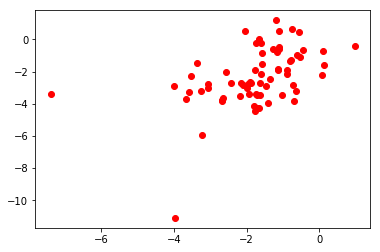

IS_RELATIVE SHARPE SLIPPAGE OOS_SHARPE


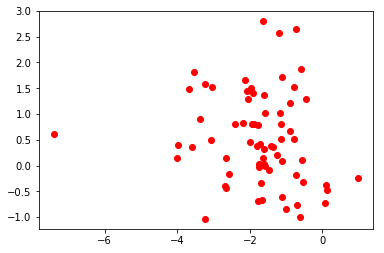

IS_RELATIVE SHARPE SLIPPAGE OOS_ALPHA


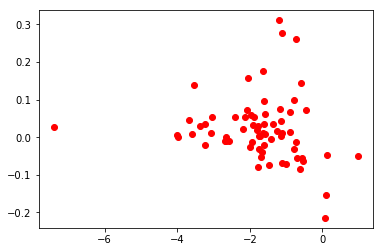

IS_RELATIVE SHARPE SLIPPAGE OOS_PROFITABILITY DIFFERENCE


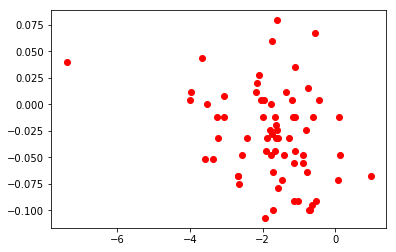

IS_RELATIVE SHARPE SLIPPAGE OOS_BETA


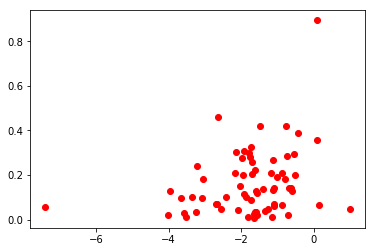

IS_RELATIVE SHARPE SLIPPAGE OOS_ANNUALIZED RETURN


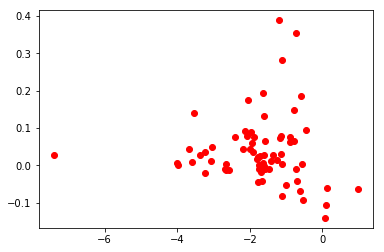

IS_RELATIVE SHARPE SLIPPAGE OOS_FACTOR SHARPE


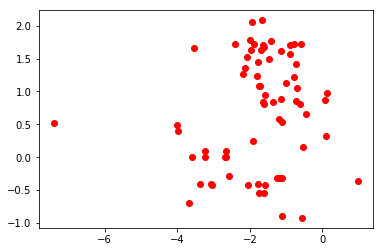

IS_ROLLING SHARPE BETA OOS_PROFITABILITY


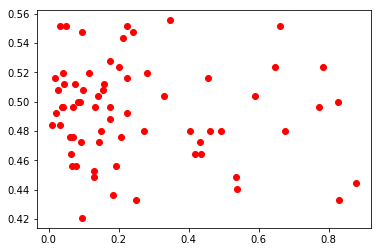

IS_ROLLING SHARPE BETA OOS_SHARPE DIFFERENCE SLIPPAGE


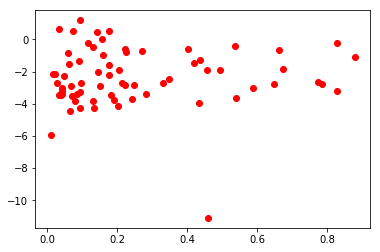

IS_ROLLING SHARPE BETA OOS_SHARPE


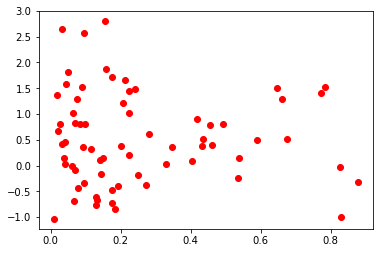

IS_ROLLING SHARPE BETA OOS_ALPHA


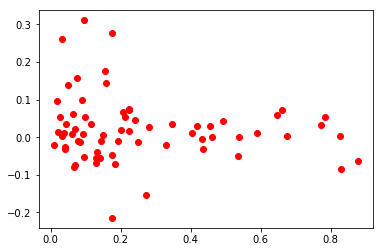

IS_ROLLING SHARPE BETA OOS_PROFITABILITY DIFFERENCE


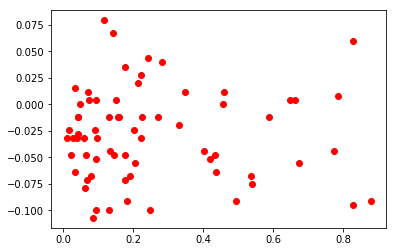

IS_ROLLING SHARPE BETA OOS_BETA


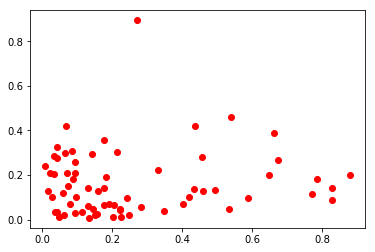

IS_ROLLING SHARPE BETA OOS_ANNUALIZED RETURN


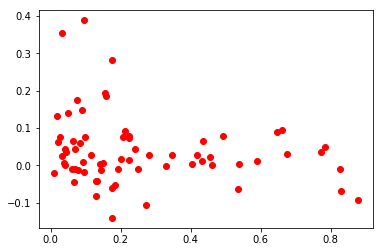

IS_ROLLING SHARPE BETA OOS_FACTOR SHARPE


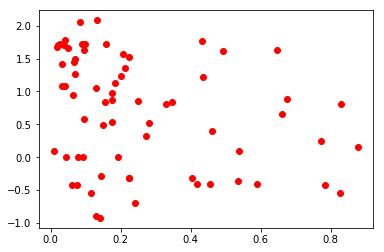

IS_ROLLING SHARPE ERROR OOS_PROFITABILITY


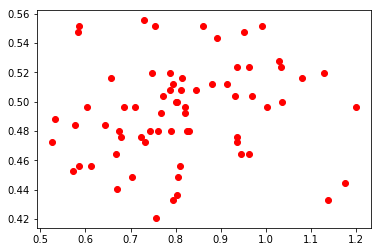

IS_ROLLING SHARPE ERROR OOS_SHARPE DIFFERENCE SLIPPAGE


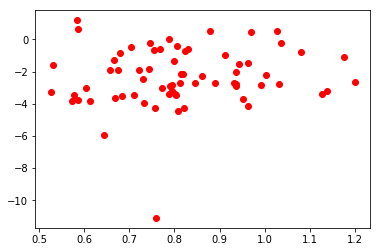

IS_ROLLING SHARPE ERROR OOS_SHARPE


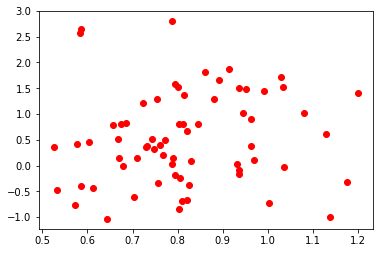

IS_ROLLING SHARPE ERROR OOS_ALPHA


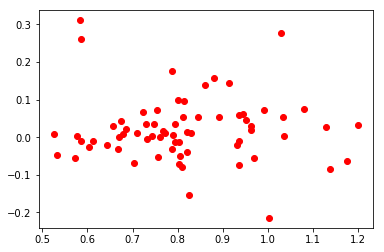

IS_ROLLING SHARPE ERROR OOS_PROFITABILITY DIFFERENCE


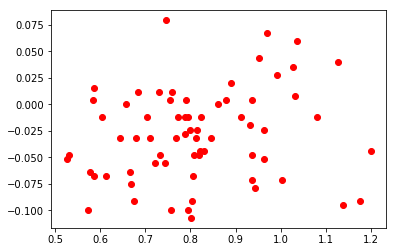

IS_ROLLING SHARPE ERROR OOS_BETA


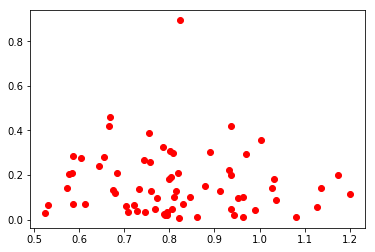

IS_ROLLING SHARPE ERROR OOS_ANNUALIZED RETURN


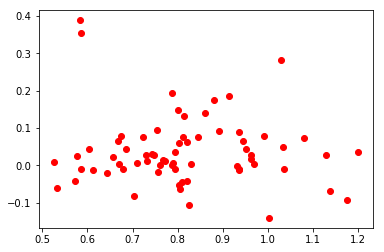

IS_ROLLING SHARPE ERROR OOS_FACTOR SHARPE


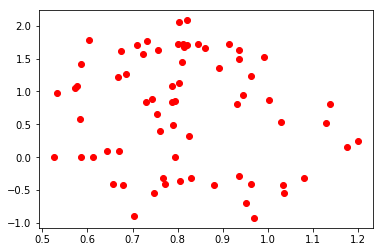

IS_ROLLING SHARPE ERROR 45 OOS_PROFITABILITY


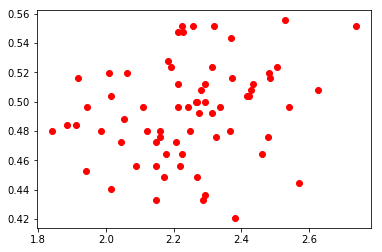

IS_ROLLING SHARPE ERROR 45 OOS_SHARPE DIFFERENCE SLIPPAGE


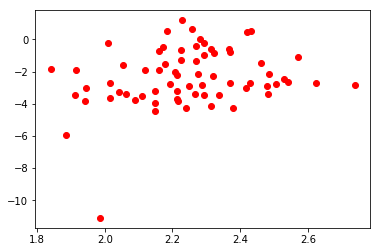

IS_ROLLING SHARPE ERROR 45 OOS_SHARPE


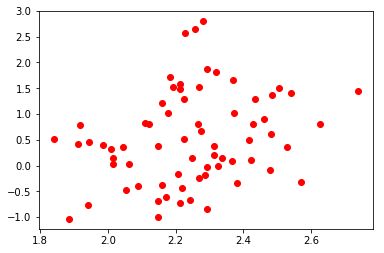

IS_ROLLING SHARPE ERROR 45 OOS_ALPHA


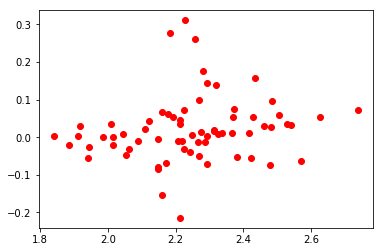

IS_ROLLING SHARPE ERROR 45 OOS_PROFITABILITY DIFFERENCE


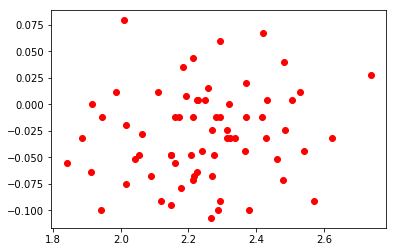

IS_ROLLING SHARPE ERROR 45 OOS_BETA


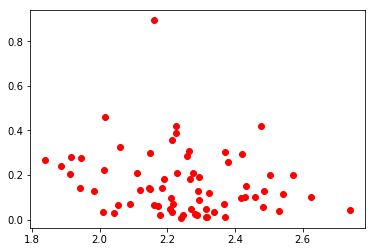

IS_ROLLING SHARPE ERROR 45 OOS_ANNUALIZED RETURN


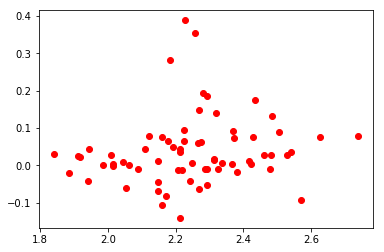

IS_ROLLING SHARPE ERROR 45 OOS_FACTOR SHARPE


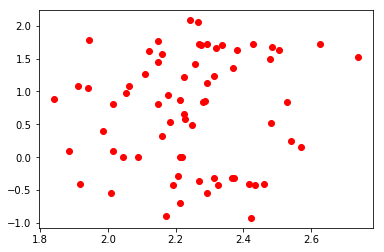

IS_ROLLING SHARPE ERROR 90 OOS_PROFITABILITY


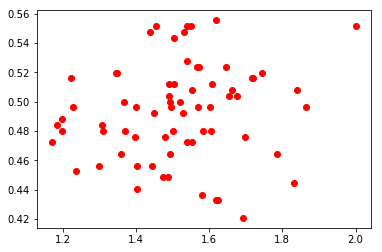

IS_ROLLING SHARPE ERROR 90 OOS_SHARPE DIFFERENCE SLIPPAGE


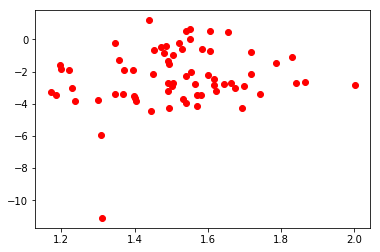

IS_ROLLING SHARPE ERROR 90 OOS_SHARPE


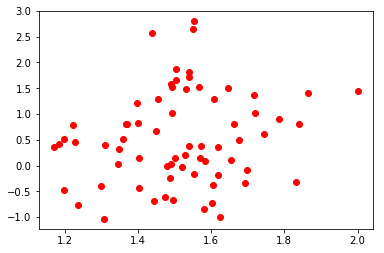

IS_ROLLING SHARPE ERROR 90 OOS_ALPHA


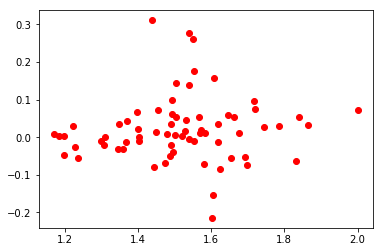

IS_ROLLING SHARPE ERROR 90 OOS_PROFITABILITY DIFFERENCE


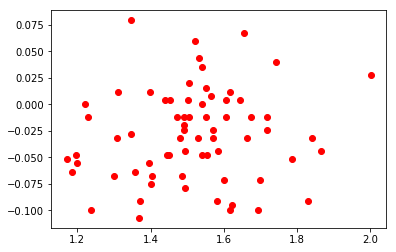

IS_ROLLING SHARPE ERROR 90 OOS_BETA


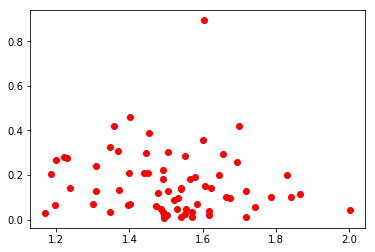

IS_ROLLING SHARPE ERROR 90 OOS_ANNUALIZED RETURN


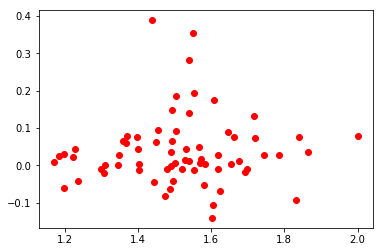

IS_ROLLING SHARPE ERROR 90 OOS_FACTOR SHARPE


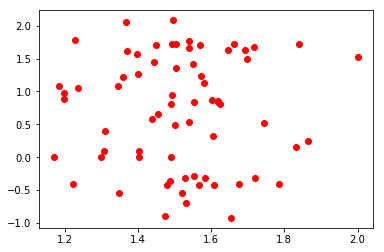

IS_ROLLING SHARPE STABILITY OOS_PROFITABILITY


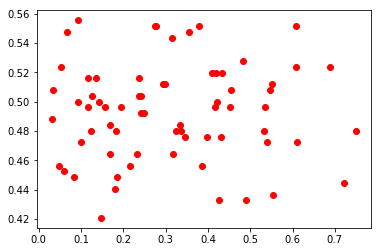

IS_ROLLING SHARPE STABILITY OOS_SHARPE DIFFERENCE SLIPPAGE


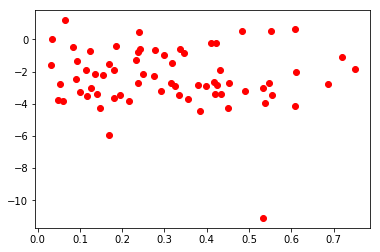

IS_ROLLING SHARPE STABILITY OOS_SHARPE


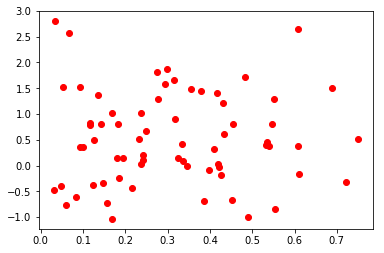

IS_ROLLING SHARPE STABILITY OOS_ALPHA


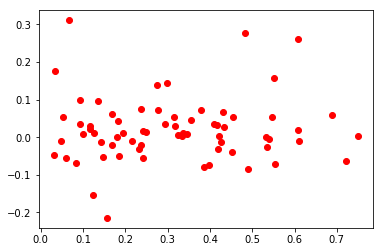

IS_ROLLING SHARPE STABILITY OOS_PROFITABILITY DIFFERENCE


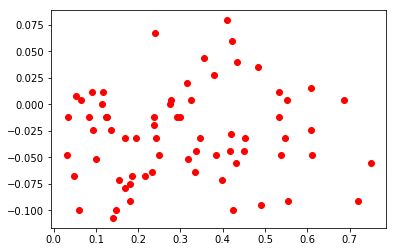

IS_ROLLING SHARPE STABILITY OOS_BETA


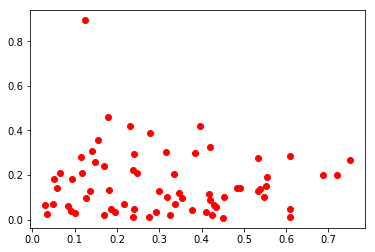

IS_ROLLING SHARPE STABILITY OOS_ANNUALIZED RETURN


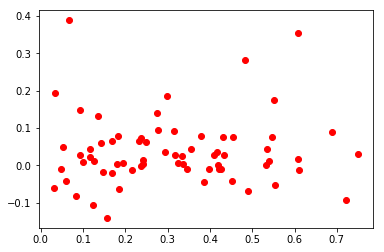

IS_ROLLING SHARPE STABILITY OOS_FACTOR SHARPE


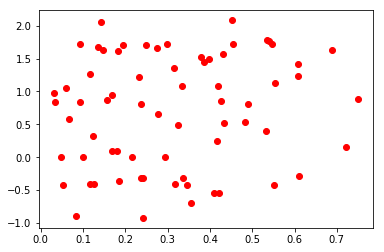

IS_SHARPE OOS_PROFITABILITY


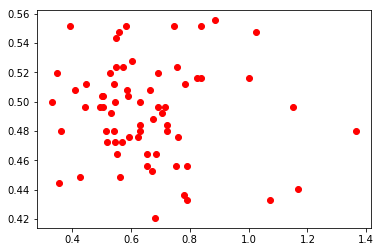

IS_SHARPE OOS_SHARPE DIFFERENCE SLIPPAGE


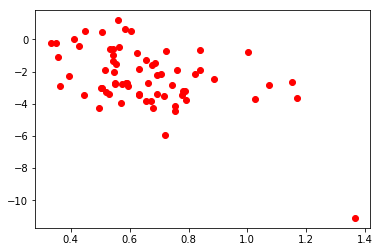

IS_SHARPE OOS_SHARPE


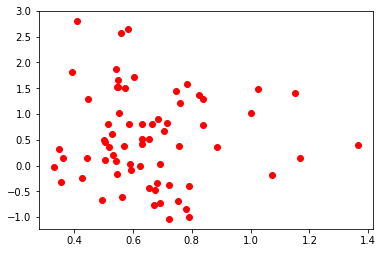

IS_SHARPE OOS_ALPHA


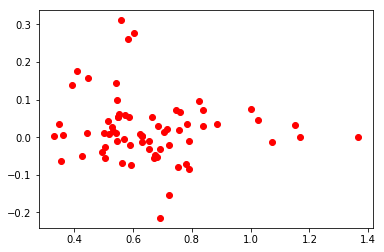

IS_SHARPE OOS_PROFITABILITY DIFFERENCE


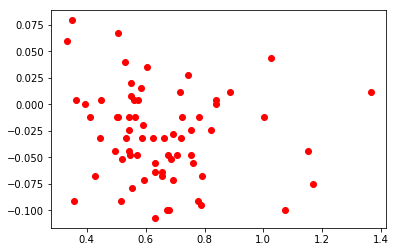

IS_SHARPE OOS_BETA


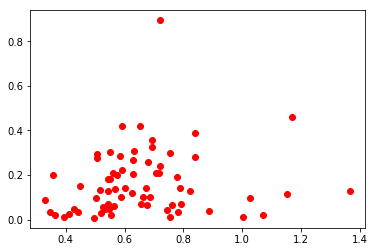

IS_SHARPE OOS_ANNUALIZED RETURN


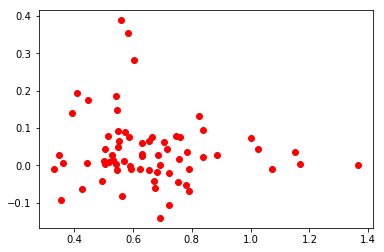

IS_SHARPE OOS_FACTOR SHARPE


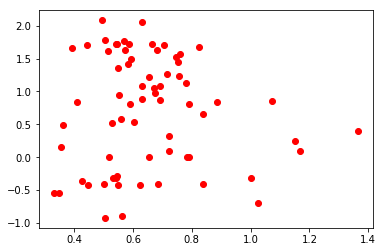

IS_SHARPE DIFFERENCE OOS_PROFITABILITY


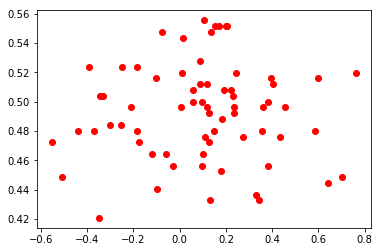

IS_SHARPE DIFFERENCE OOS_SHARPE DIFFERENCE SLIPPAGE


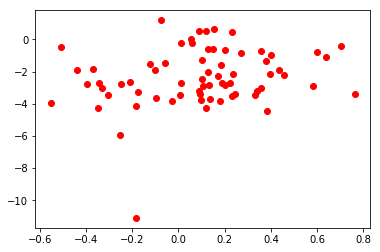

IS_SHARPE DIFFERENCE OOS_SHARPE


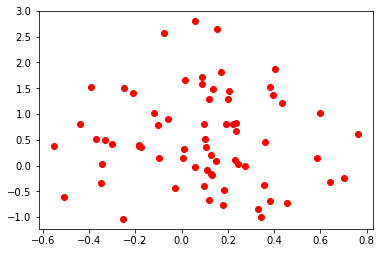

IS_SHARPE DIFFERENCE OOS_ALPHA


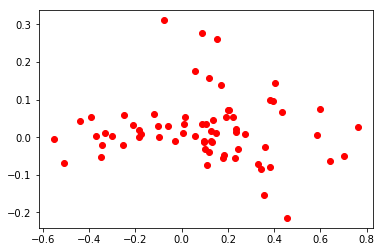

IS_SHARPE DIFFERENCE OOS_PROFITABILITY DIFFERENCE


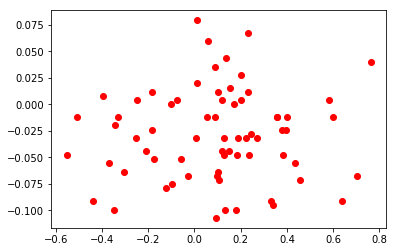

IS_SHARPE DIFFERENCE OOS_BETA


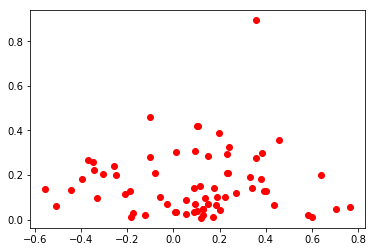

IS_SHARPE DIFFERENCE OOS_ANNUALIZED RETURN


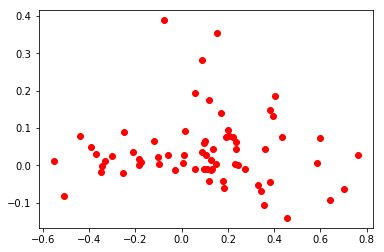

IS_SHARPE DIFFERENCE OOS_FACTOR SHARPE


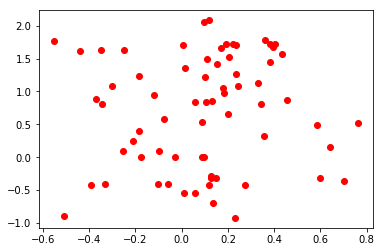

IS_SHARPE DIFFERENCE AVERAGE OOS_PROFITABILITY


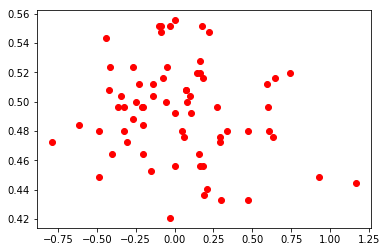

IS_SHARPE DIFFERENCE AVERAGE OOS_SHARPE DIFFERENCE SLIPPAGE


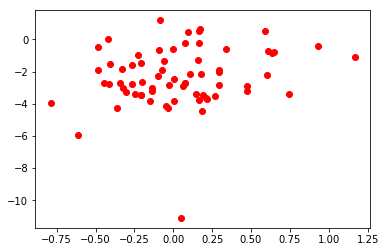

IS_SHARPE DIFFERENCE AVERAGE OOS_SHARPE


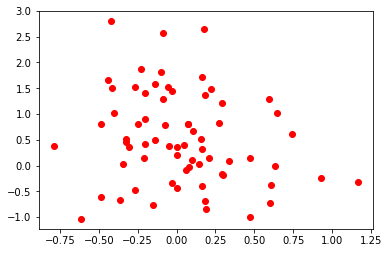

IS_SHARPE DIFFERENCE AVERAGE OOS_ALPHA


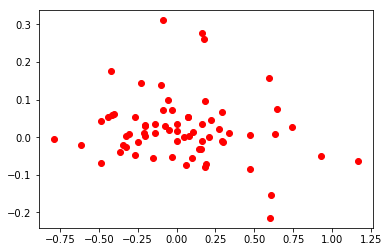

IS_SHARPE DIFFERENCE AVERAGE OOS_PROFITABILITY DIFFERENCE


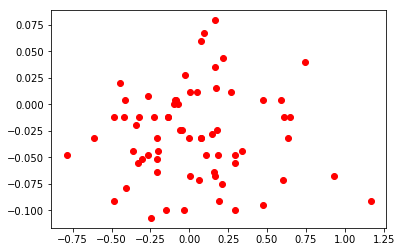

IS_SHARPE DIFFERENCE AVERAGE OOS_BETA


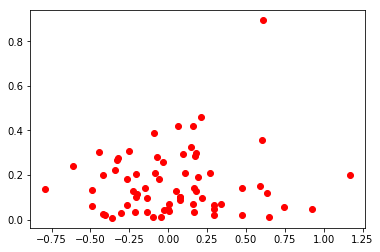

IS_SHARPE DIFFERENCE AVERAGE OOS_ANNUALIZED RETURN


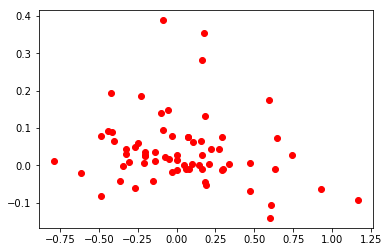

IS_SHARPE DIFFERENCE AVERAGE OOS_FACTOR SHARPE


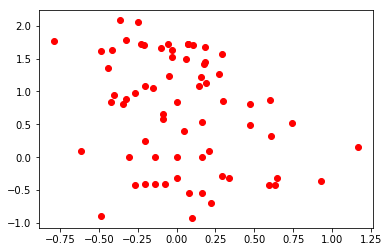

IS_SHARPE DIFFERENCE GREATER THAN 0 OOS_PROFITABILITY


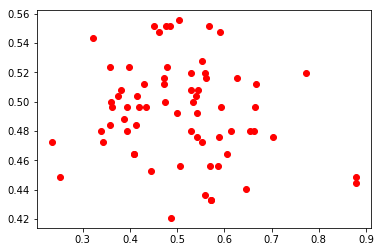

IS_SHARPE DIFFERENCE GREATER THAN 0 OOS_SHARPE DIFFERENCE SLIPPAGE


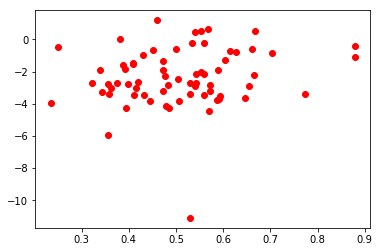

IS_SHARPE DIFFERENCE GREATER THAN 0 OOS_SHARPE


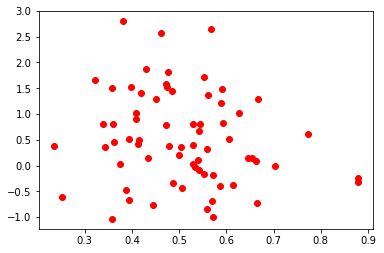

IS_SHARPE DIFFERENCE GREATER THAN 0 OOS_ALPHA


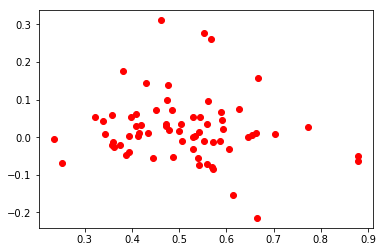

IS_SHARPE DIFFERENCE GREATER THAN 0 OOS_PROFITABILITY DIFFERENCE


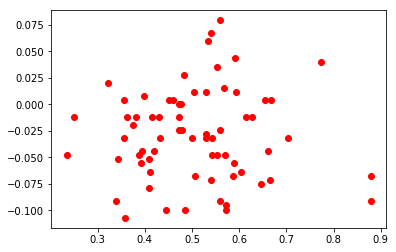

IS_SHARPE DIFFERENCE GREATER THAN 0 OOS_BETA


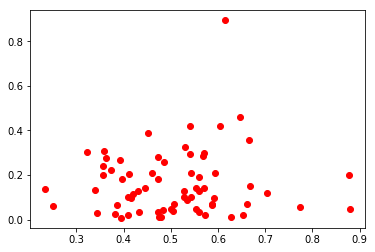

IS_SHARPE DIFFERENCE GREATER THAN 0 OOS_ANNUALIZED RETURN


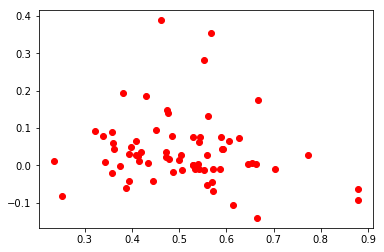

IS_SHARPE DIFFERENCE GREATER THAN 0 OOS_FACTOR SHARPE


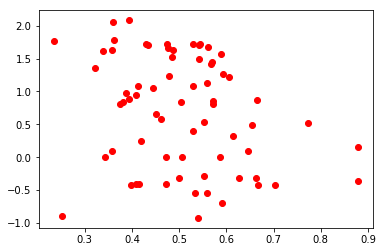

IS_SHARPE DIFFERENCE MIN OOS_PROFITABILITY


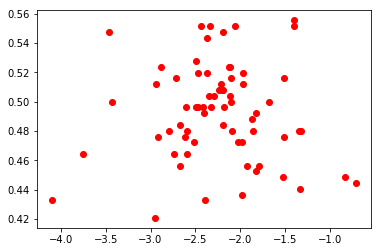

IS_SHARPE DIFFERENCE MIN OOS_SHARPE DIFFERENCE SLIPPAGE


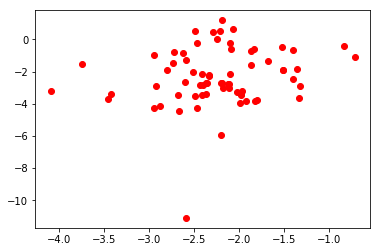

IS_SHARPE DIFFERENCE MIN OOS_SHARPE


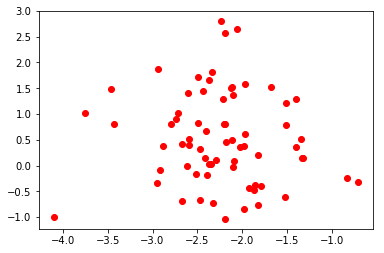

IS_SHARPE DIFFERENCE MIN OOS_ALPHA


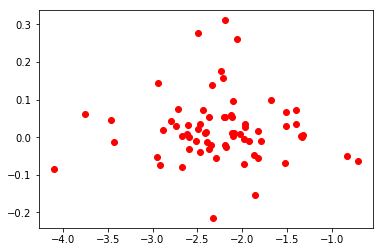

IS_SHARPE DIFFERENCE MIN OOS_PROFITABILITY DIFFERENCE


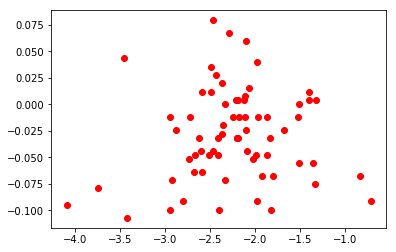

IS_SHARPE DIFFERENCE MIN OOS_BETA


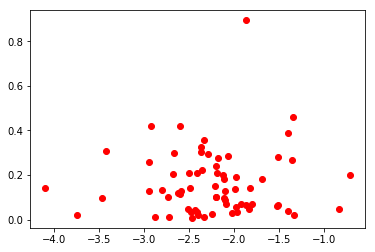

IS_SHARPE DIFFERENCE MIN OOS_ANNUALIZED RETURN


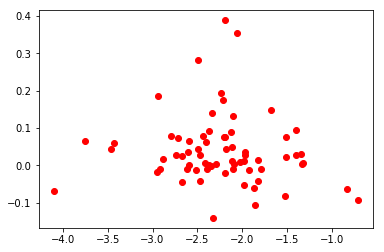

IS_SHARPE DIFFERENCE MIN OOS_FACTOR SHARPE


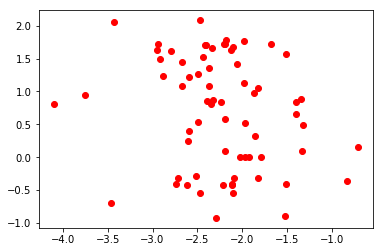

IS_SHARPE DIFFERENCE SLIPPAGE OOS_PROFITABILITY


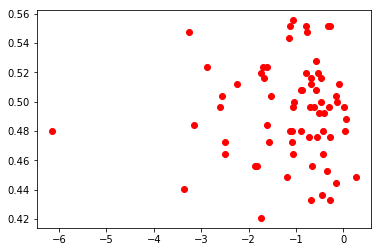

IS_SHARPE DIFFERENCE SLIPPAGE OOS_SHARPE DIFFERENCE SLIPPAGE


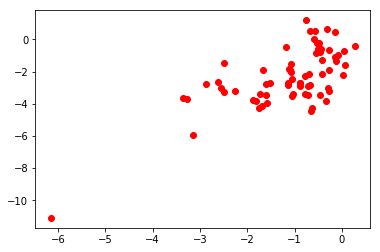

IS_SHARPE DIFFERENCE SLIPPAGE OOS_SHARPE


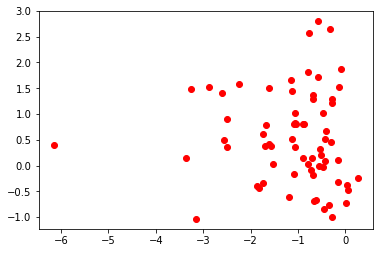

IS_SHARPE DIFFERENCE SLIPPAGE OOS_ALPHA


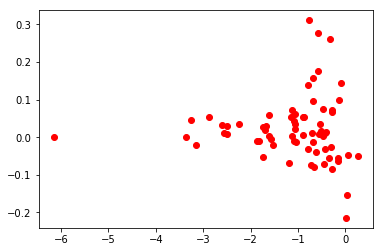

IS_SHARPE DIFFERENCE SLIPPAGE OOS_PROFITABILITY DIFFERENCE


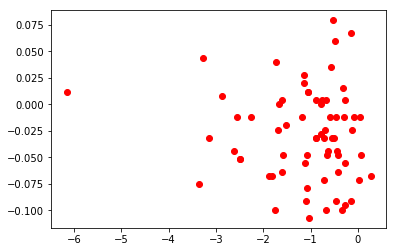

IS_SHARPE DIFFERENCE SLIPPAGE OOS_BETA


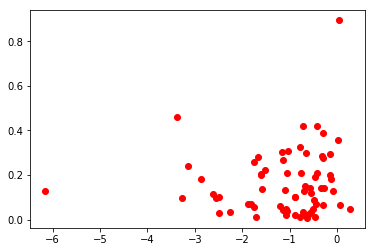

IS_SHARPE DIFFERENCE SLIPPAGE OOS_ANNUALIZED RETURN


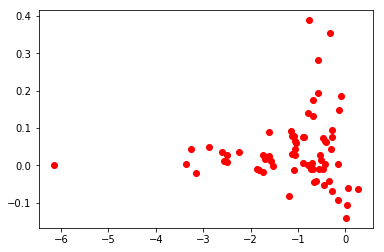

IS_SHARPE DIFFERENCE SLIPPAGE OOS_FACTOR SHARPE


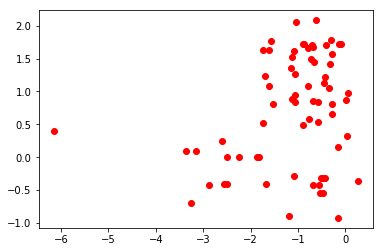

IS_SHARPE SLIPPAGE OOS_PROFITABILITY


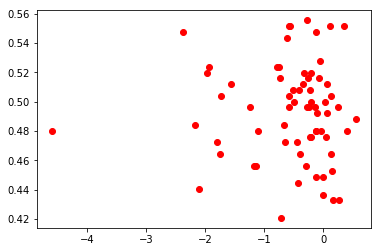

IS_SHARPE SLIPPAGE OOS_SHARPE DIFFERENCE SLIPPAGE


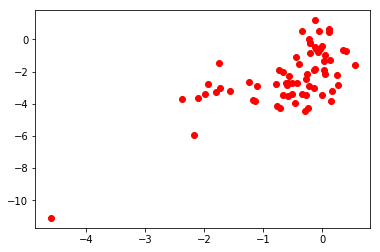

IS_SHARPE SLIPPAGE OOS_SHARPE


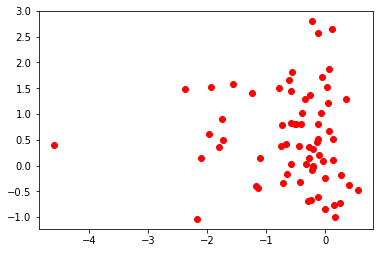

IS_SHARPE SLIPPAGE OOS_ALPHA


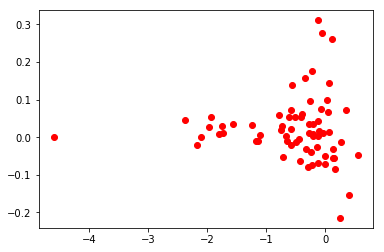

IS_SHARPE SLIPPAGE OOS_PROFITABILITY DIFFERENCE


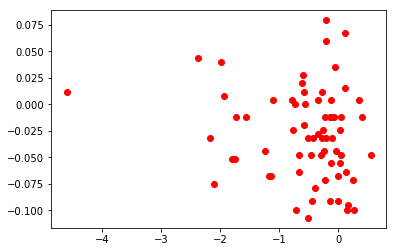

IS_SHARPE SLIPPAGE OOS_BETA


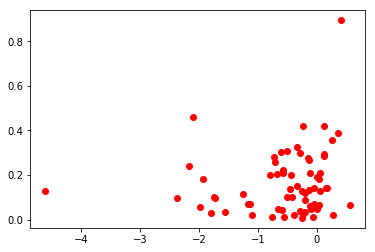

IS_SHARPE SLIPPAGE OOS_ANNUALIZED RETURN


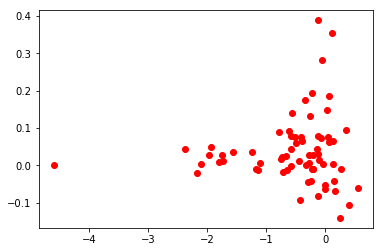

IS_SHARPE SLIPPAGE OOS_FACTOR SHARPE


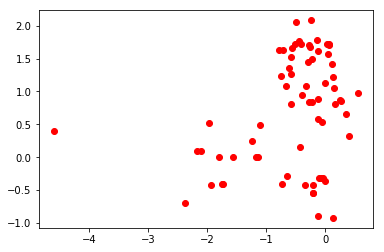

IS_SHARPE SLIPPAGE DECAY OOS_PROFITABILITY


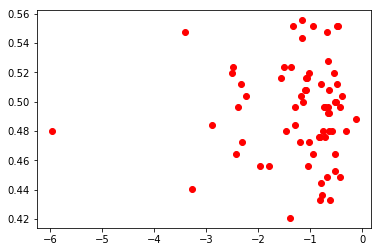

IS_SHARPE SLIPPAGE DECAY OOS_SHARPE DIFFERENCE SLIPPAGE


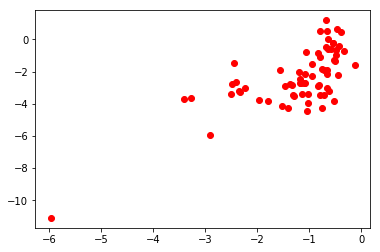

IS_SHARPE SLIPPAGE DECAY OOS_SHARPE


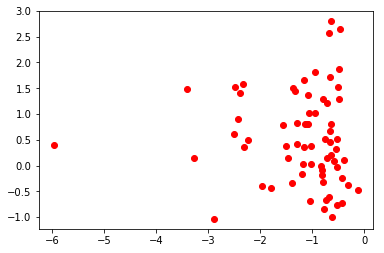

IS_SHARPE SLIPPAGE DECAY OOS_ALPHA


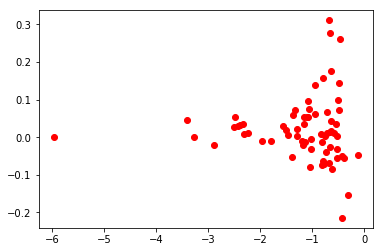

IS_SHARPE SLIPPAGE DECAY OOS_PROFITABILITY DIFFERENCE


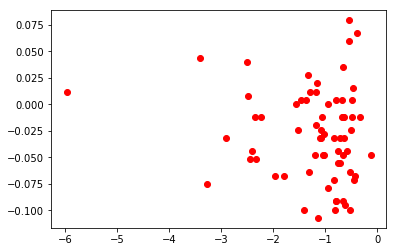

IS_SHARPE SLIPPAGE DECAY OOS_BETA


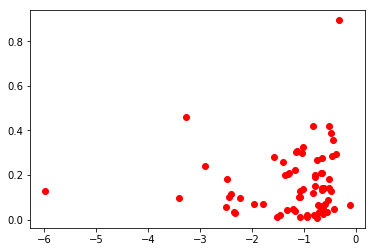

IS_SHARPE SLIPPAGE DECAY OOS_ANNUALIZED RETURN


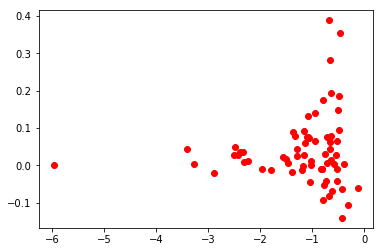

IS_SHARPE SLIPPAGE DECAY OOS_FACTOR SHARPE


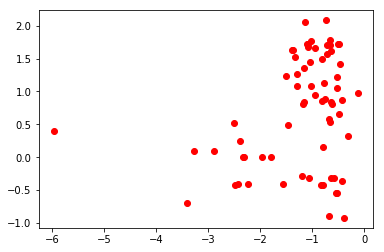

IS_SHARPE TO MIN RATIO 45 OOS_PROFITABILITY


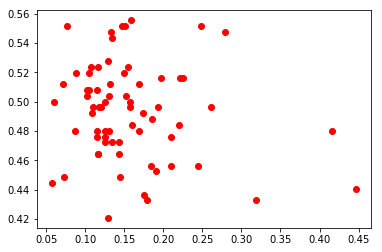

IS_SHARPE TO MIN RATIO 45 OOS_SHARPE DIFFERENCE SLIPPAGE


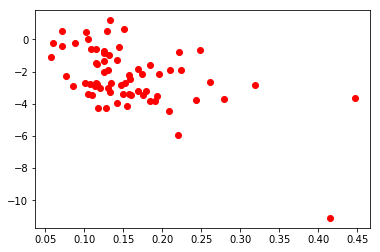

IS_SHARPE TO MIN RATIO 45 OOS_SHARPE


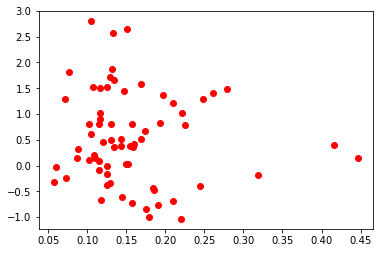

IS_SHARPE TO MIN RATIO 45 OOS_ALPHA


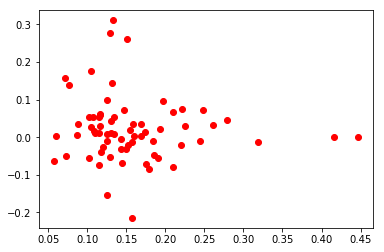

IS_SHARPE TO MIN RATIO 45 OOS_PROFITABILITY DIFFERENCE


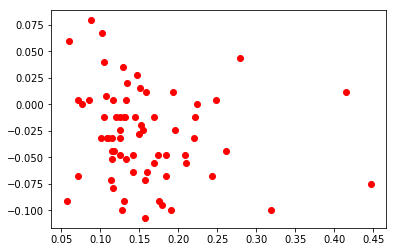

IS_SHARPE TO MIN RATIO 45 OOS_BETA


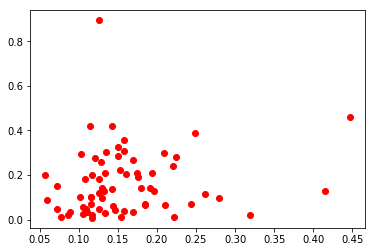

IS_SHARPE TO MIN RATIO 45 OOS_ANNUALIZED RETURN


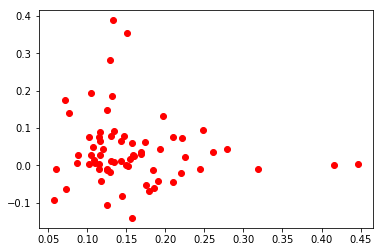

IS_SHARPE TO MIN RATIO 45 OOS_FACTOR SHARPE


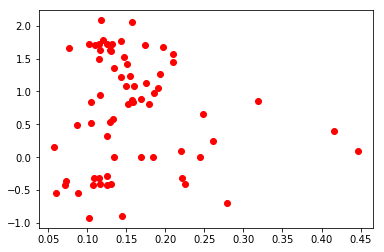

IS_SHARPE TO MIN RATIO 90 OOS_PROFITABILITY


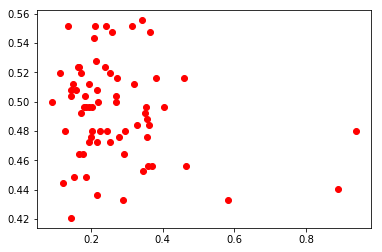

IS_SHARPE TO MIN RATIO 90 OOS_SHARPE DIFFERENCE SLIPPAGE


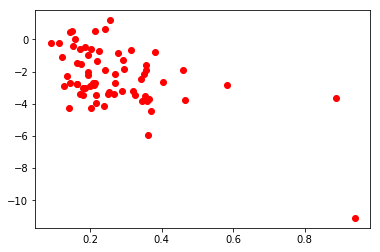

IS_SHARPE TO MIN RATIO 90 OOS_SHARPE


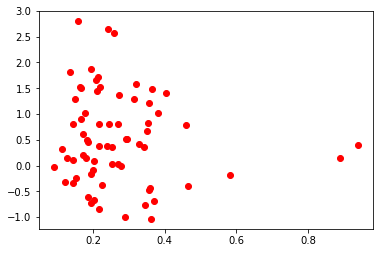

IS_SHARPE TO MIN RATIO 90 OOS_ALPHA


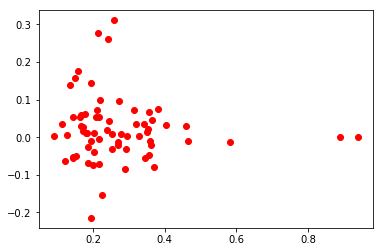

IS_SHARPE TO MIN RATIO 90 OOS_PROFITABILITY DIFFERENCE


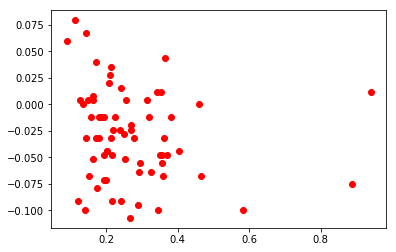

IS_SHARPE TO MIN RATIO 90 OOS_BETA


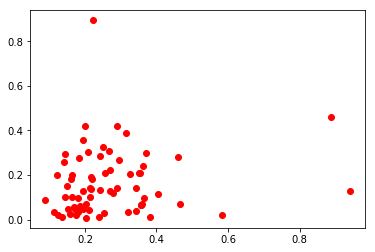

IS_SHARPE TO MIN RATIO 90 OOS_ANNUALIZED RETURN


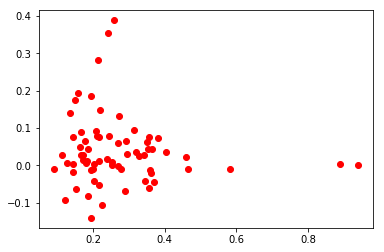

IS_SHARPE TO MIN RATIO 90 OOS_FACTOR SHARPE


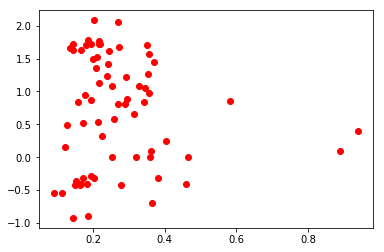

IS_SMART INFORMATION RATIO OOS_PROFITABILITY


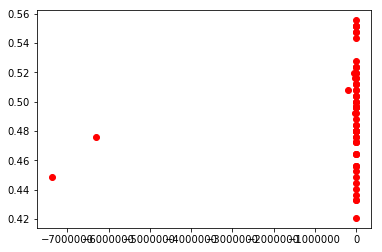

IS_SMART INFORMATION RATIO OOS_SHARPE DIFFERENCE SLIPPAGE


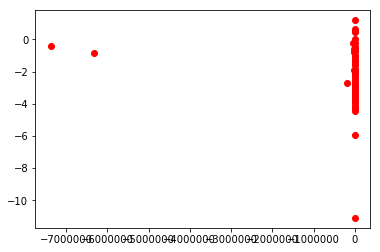

IS_SMART INFORMATION RATIO OOS_SHARPE


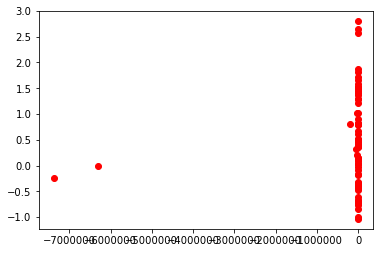

IS_SMART INFORMATION RATIO OOS_ALPHA


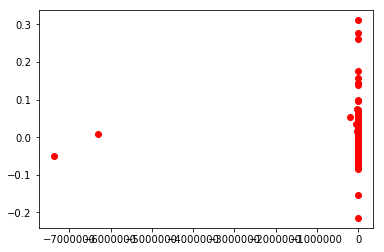

IS_SMART INFORMATION RATIO OOS_PROFITABILITY DIFFERENCE


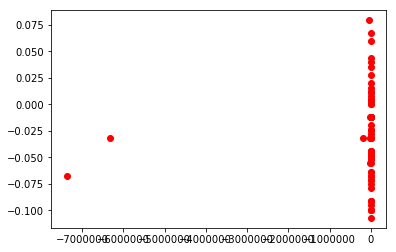

IS_SMART INFORMATION RATIO OOS_BETA


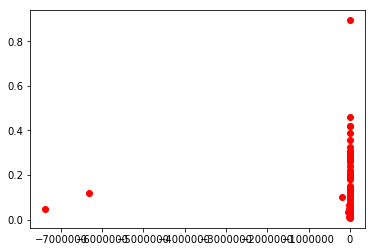

IS_SMART INFORMATION RATIO OOS_ANNUALIZED RETURN


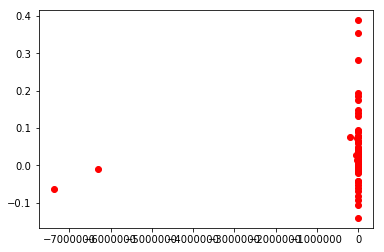

IS_SMART INFORMATION RATIO OOS_FACTOR SHARPE


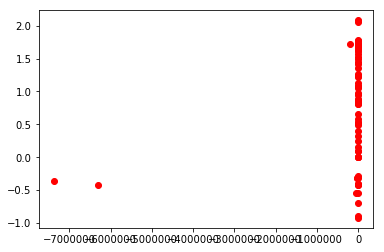

IS_STABILITY OOS_PROFITABILITY


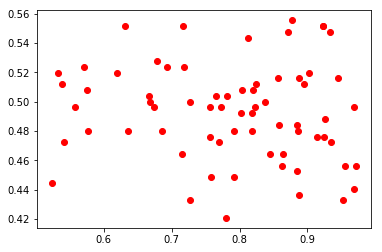

IS_STABILITY OOS_SHARPE DIFFERENCE SLIPPAGE


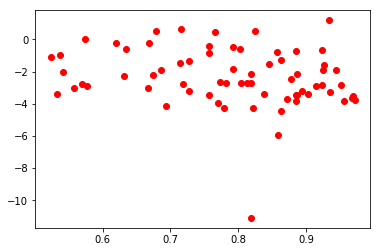

IS_STABILITY OOS_SHARPE


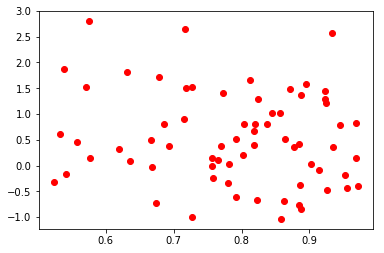

IS_STABILITY OOS_ALPHA


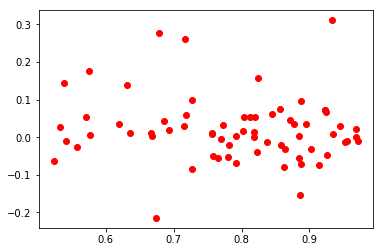

IS_STABILITY OOS_PROFITABILITY DIFFERENCE


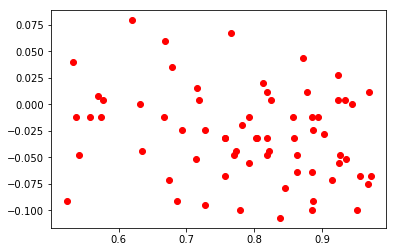

IS_STABILITY OOS_BETA


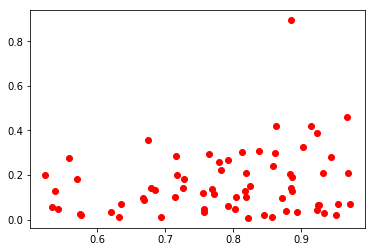

IS_STABILITY OOS_ANNUALIZED RETURN


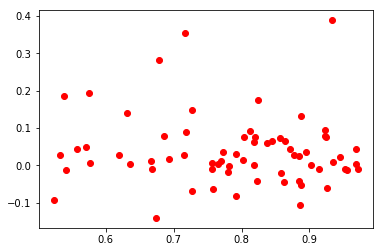

IS_STABILITY OOS_FACTOR SHARPE


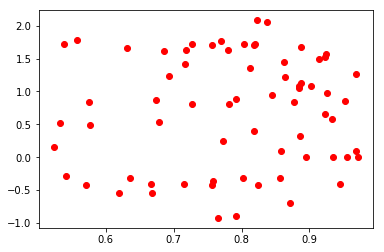

IS_TOTAL DAYS SEEN OOS_PROFITABILITY


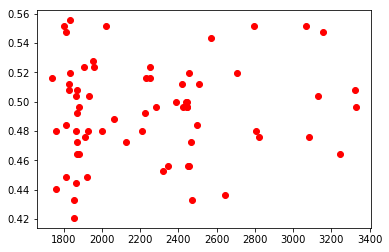

IS_TOTAL DAYS SEEN OOS_SHARPE DIFFERENCE SLIPPAGE


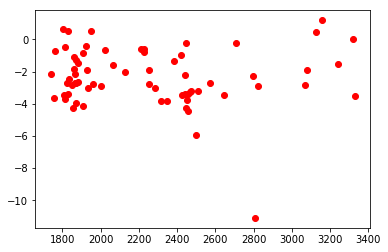

IS_TOTAL DAYS SEEN OOS_SHARPE


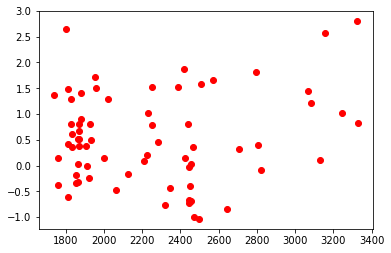

IS_TOTAL DAYS SEEN OOS_ALPHA


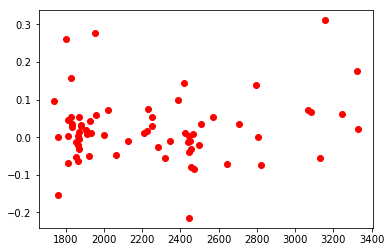

IS_TOTAL DAYS SEEN OOS_PROFITABILITY DIFFERENCE


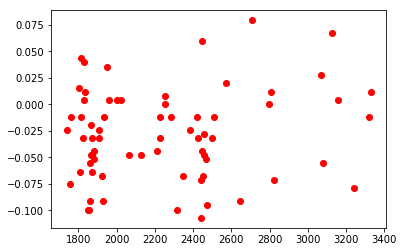

IS_TOTAL DAYS SEEN OOS_BETA


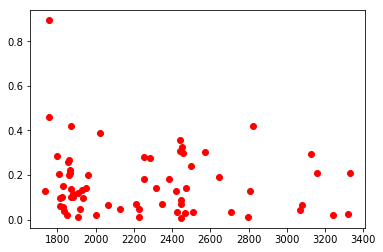

IS_TOTAL DAYS SEEN OOS_ANNUALIZED RETURN


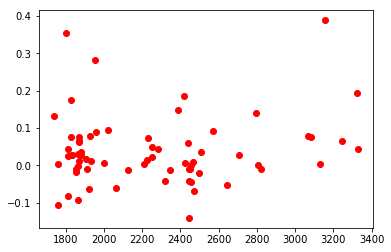

IS_TOTAL DAYS SEEN OOS_FACTOR SHARPE


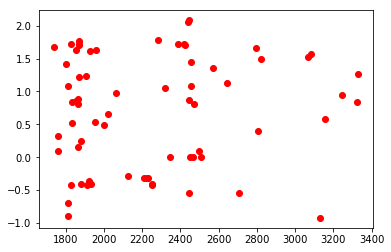

IS_TREYNOR OOS_PROFITABILITY


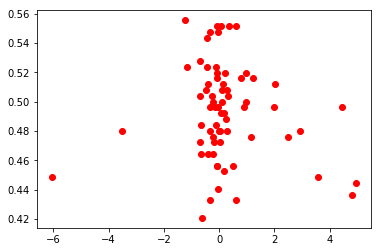

IS_TREYNOR OOS_SHARPE DIFFERENCE SLIPPAGE


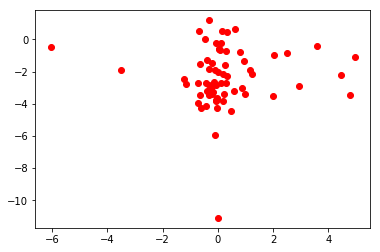

IS_TREYNOR OOS_SHARPE


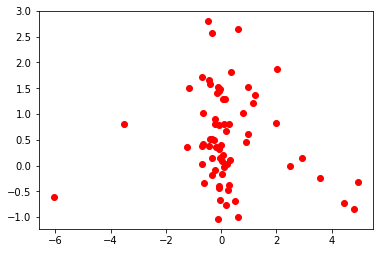

IS_TREYNOR OOS_ALPHA


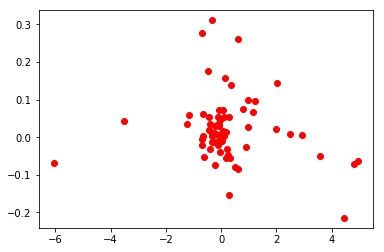

IS_TREYNOR OOS_PROFITABILITY DIFFERENCE


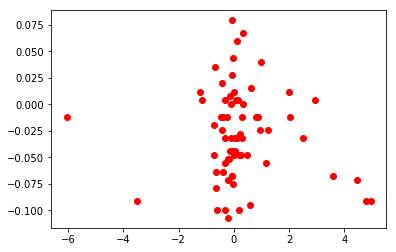

IS_TREYNOR OOS_BETA


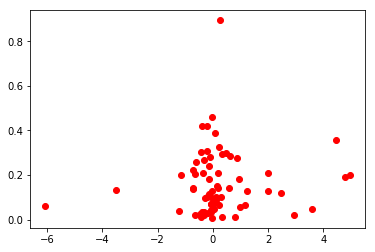

IS_TREYNOR OOS_ANNUALIZED RETURN


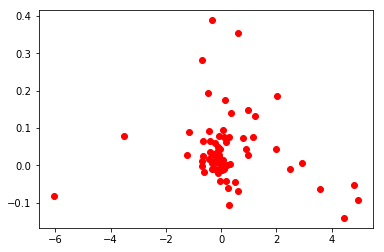

IS_TREYNOR OOS_FACTOR SHARPE


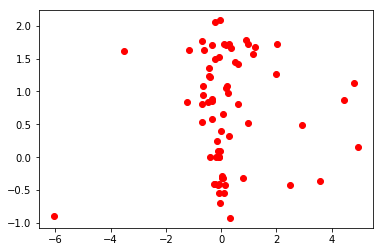

OOS_ALPHA OOS_PROFITABILITY


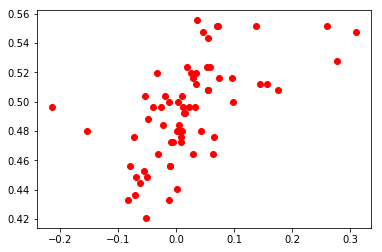

OOS_ALPHA OOS_SHARPE DIFFERENCE SLIPPAGE


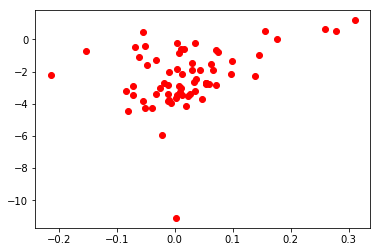

OOS_ALPHA OOS_SHARPE


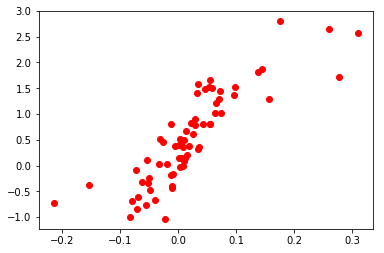

OOS_ALPHA OOS_ALPHA


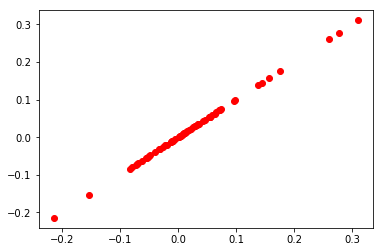

OOS_ALPHA OOS_PROFITABILITY DIFFERENCE


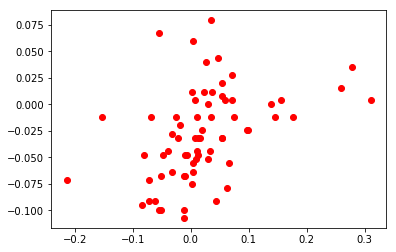

OOS_ALPHA OOS_BETA


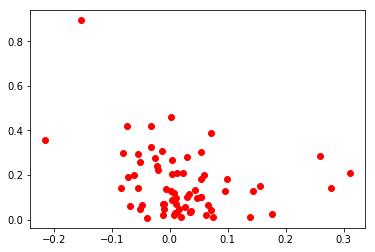

OOS_ALPHA OOS_ANNUALIZED RETURN


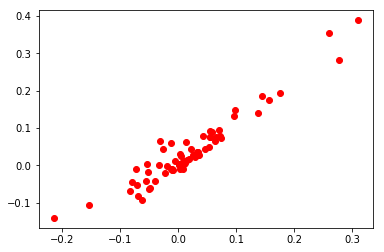

OOS_ALPHA OOS_FACTOR SHARPE


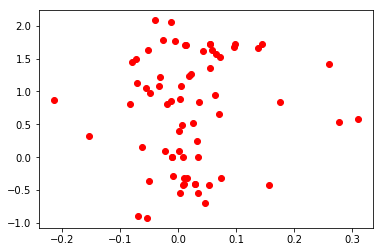

OOS_ANNUALIZED RETURN OOS_PROFITABILITY


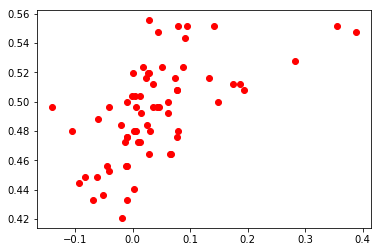

OOS_ANNUALIZED RETURN OOS_SHARPE DIFFERENCE SLIPPAGE


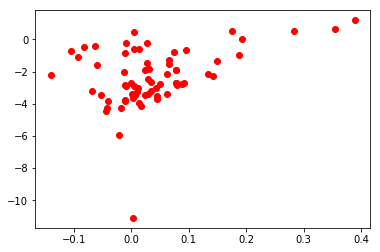

OOS_ANNUALIZED RETURN OOS_SHARPE


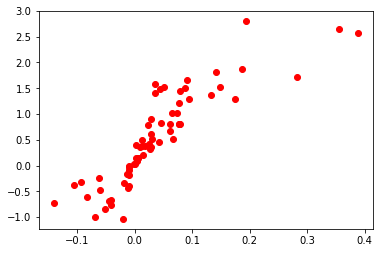

OOS_ANNUALIZED RETURN OOS_ALPHA


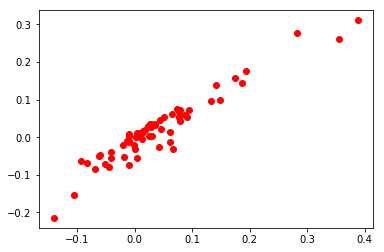

OOS_ANNUALIZED RETURN OOS_PROFITABILITY DIFFERENCE


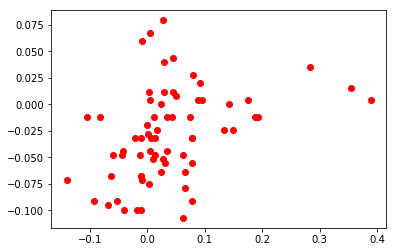

OOS_ANNUALIZED RETURN OOS_BETA


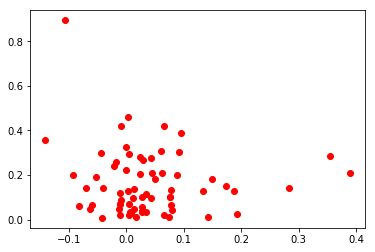

OOS_ANNUALIZED RETURN OOS_ANNUALIZED RETURN


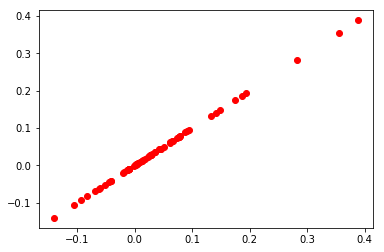

OOS_ANNUALIZED RETURN OOS_FACTOR SHARPE


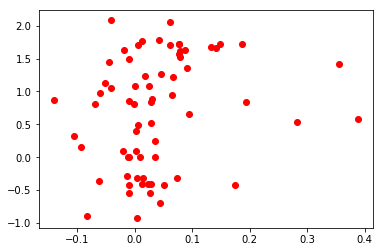

OOS_BETA OOS_PROFITABILITY


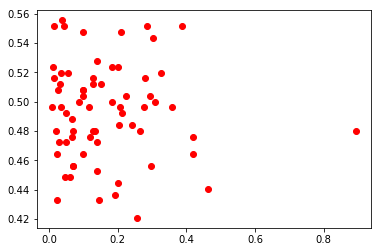

OOS_BETA OOS_SHARPE DIFFERENCE SLIPPAGE


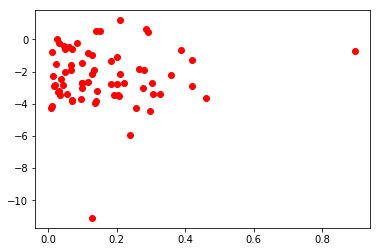

OOS_BETA OOS_SHARPE


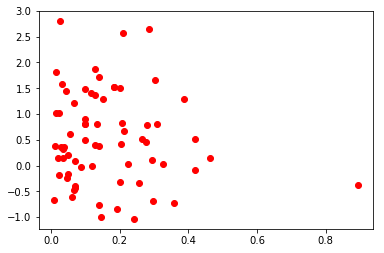

OOS_BETA OOS_ALPHA


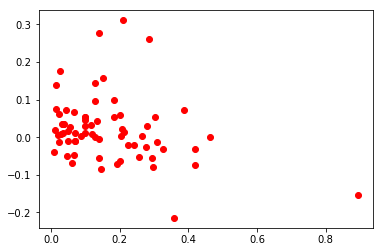

OOS_BETA OOS_PROFITABILITY DIFFERENCE


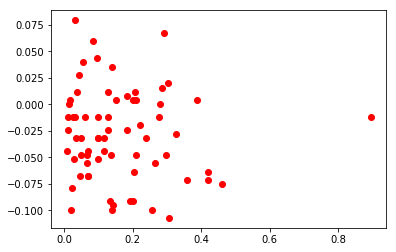

OOS_BETA OOS_BETA


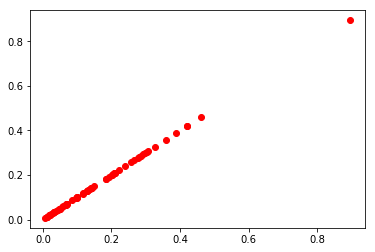

OOS_BETA OOS_ANNUALIZED RETURN


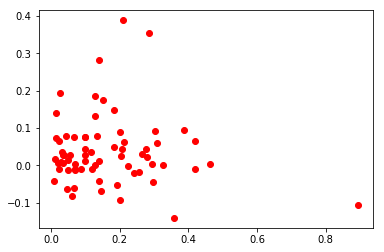

OOS_BETA OOS_FACTOR SHARPE


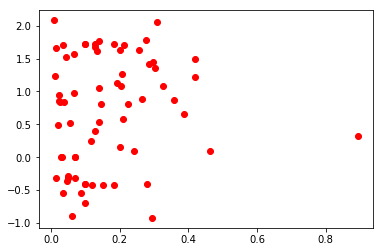

OOS_FACTOR SHARPE OOS_PROFITABILITY


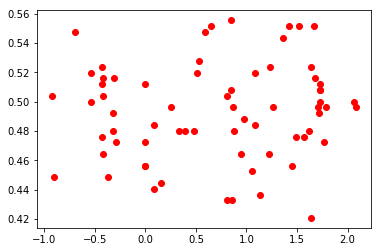

OOS_FACTOR SHARPE OOS_SHARPE DIFFERENCE SLIPPAGE


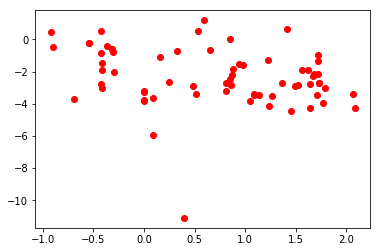

OOS_FACTOR SHARPE OOS_SHARPE


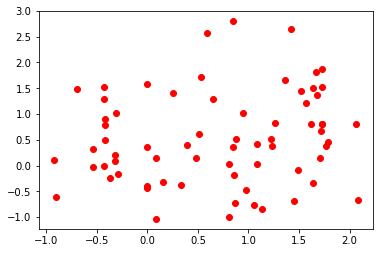

OOS_FACTOR SHARPE OOS_ALPHA


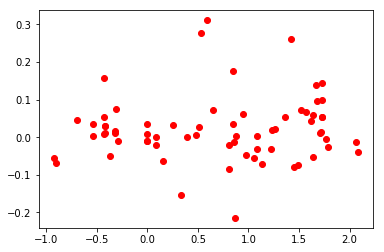

OOS_FACTOR SHARPE OOS_PROFITABILITY DIFFERENCE


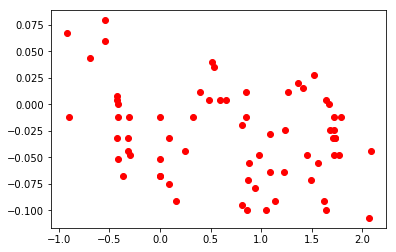

OOS_FACTOR SHARPE OOS_BETA


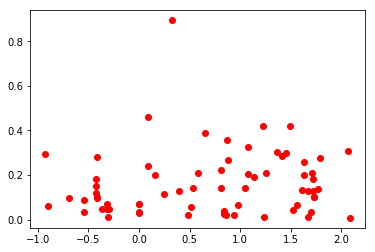

OOS_FACTOR SHARPE OOS_ANNUALIZED RETURN


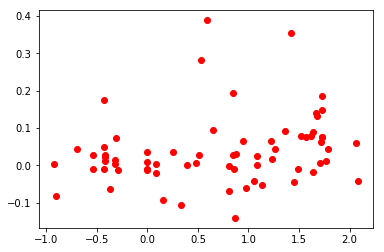

OOS_FACTOR SHARPE OOS_FACTOR SHARPE


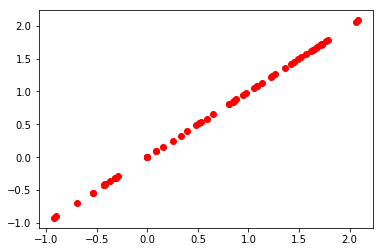

OOS_PROFITABILITY OOS_PROFITABILITY


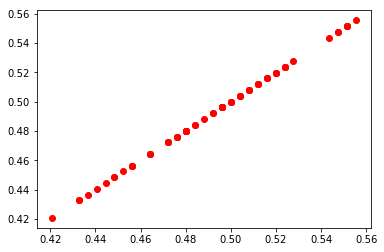

OOS_PROFITABILITY OOS_SHARPE DIFFERENCE SLIPPAGE


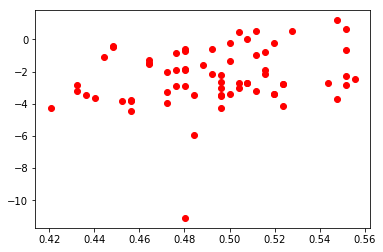

OOS_PROFITABILITY OOS_SHARPE


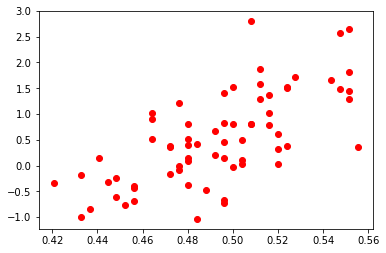

OOS_PROFITABILITY OOS_ALPHA


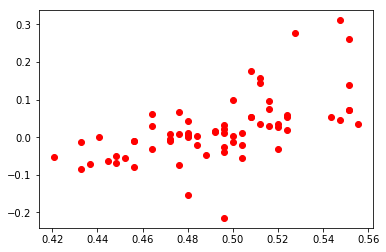

OOS_PROFITABILITY OOS_PROFITABILITY DIFFERENCE


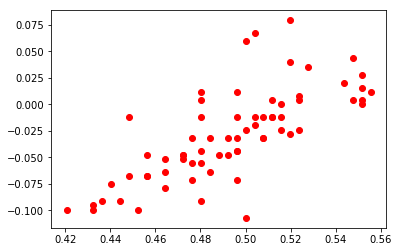

OOS_PROFITABILITY OOS_BETA


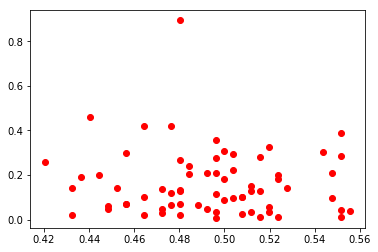

OOS_PROFITABILITY OOS_ANNUALIZED RETURN


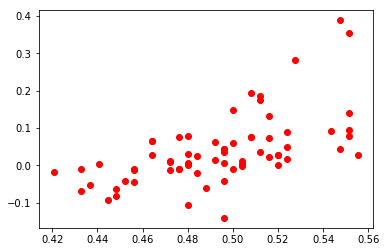

OOS_PROFITABILITY OOS_FACTOR SHARPE


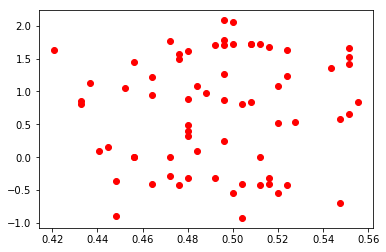

OOS_PROFITABILITY DIFFERENCE OOS_PROFITABILITY


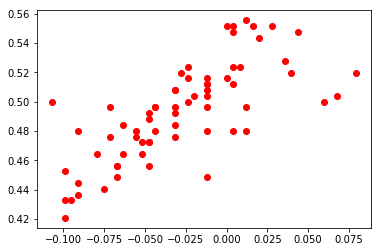

OOS_PROFITABILITY DIFFERENCE OOS_SHARPE DIFFERENCE SLIPPAGE


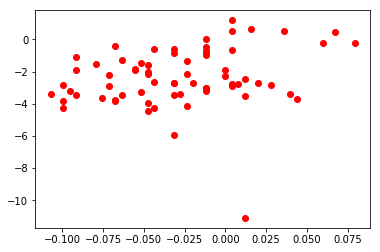

OOS_PROFITABILITY DIFFERENCE OOS_SHARPE


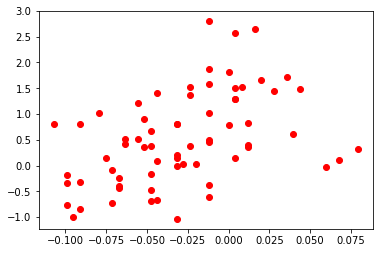

OOS_PROFITABILITY DIFFERENCE OOS_ALPHA


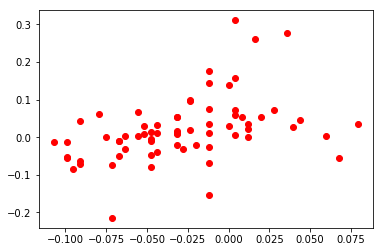

OOS_PROFITABILITY DIFFERENCE OOS_PROFITABILITY DIFFERENCE


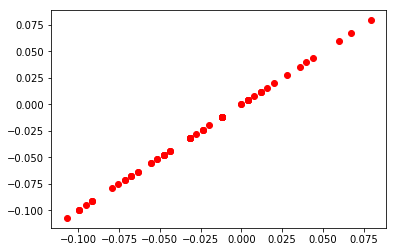

OOS_PROFITABILITY DIFFERENCE OOS_BETA


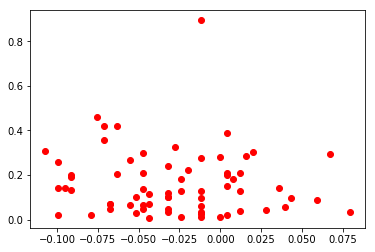

OOS_PROFITABILITY DIFFERENCE OOS_ANNUALIZED RETURN


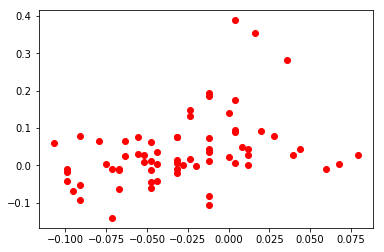

OOS_PROFITABILITY DIFFERENCE OOS_FACTOR SHARPE


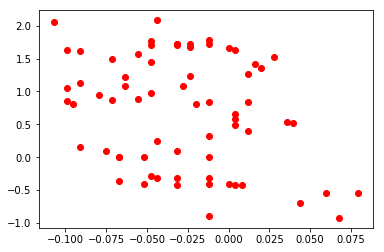

OOS_RAW BETA OOS_PROFITABILITY


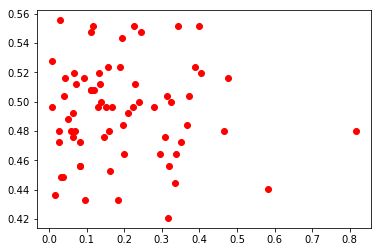

OOS_RAW BETA OOS_SHARPE DIFFERENCE SLIPPAGE


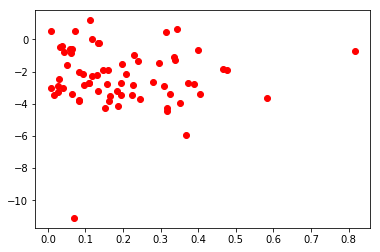

OOS_RAW BETA OOS_SHARPE


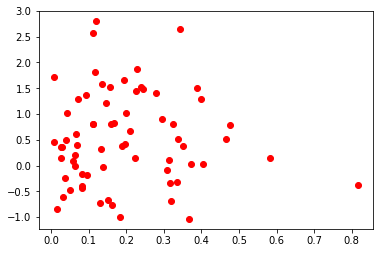

OOS_RAW BETA OOS_ALPHA


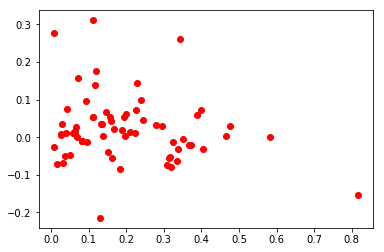

OOS_RAW BETA OOS_PROFITABILITY DIFFERENCE


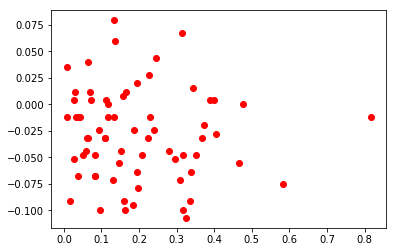

OOS_RAW BETA OOS_BETA


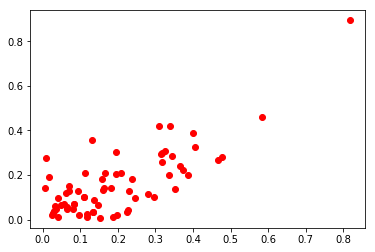

OOS_RAW BETA OOS_ANNUALIZED RETURN


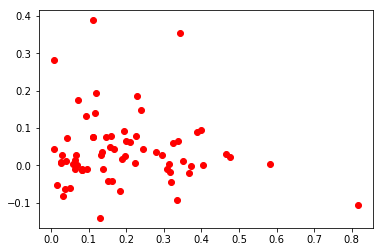

OOS_RAW BETA OOS_FACTOR SHARPE


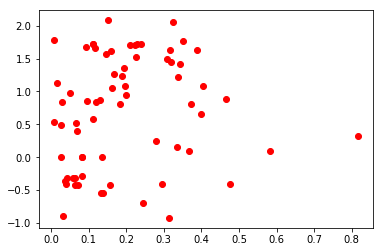

OOS_SHARPE OOS_PROFITABILITY


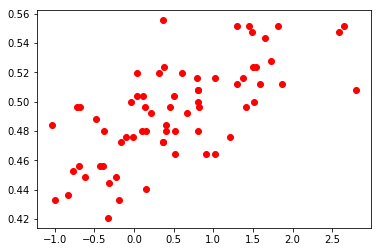

OOS_SHARPE OOS_SHARPE DIFFERENCE SLIPPAGE


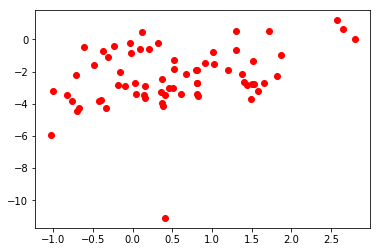

OOS_SHARPE OOS_SHARPE


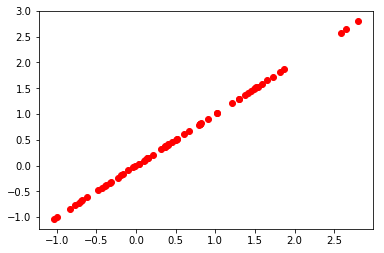

OOS_SHARPE OOS_ALPHA


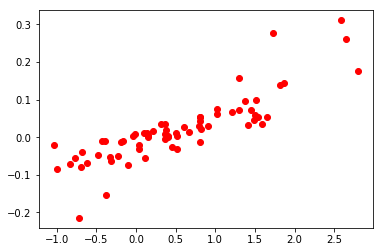

OOS_SHARPE OOS_PROFITABILITY DIFFERENCE


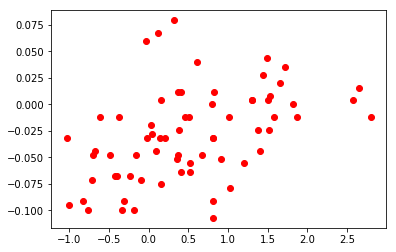

OOS_SHARPE OOS_BETA


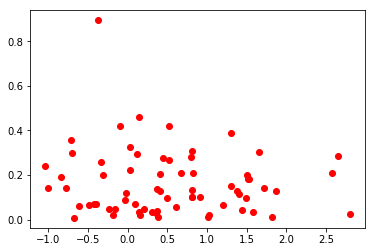

OOS_SHARPE OOS_ANNUALIZED RETURN


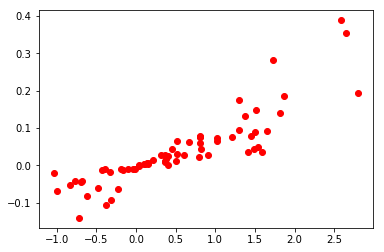

OOS_SHARPE OOS_FACTOR SHARPE


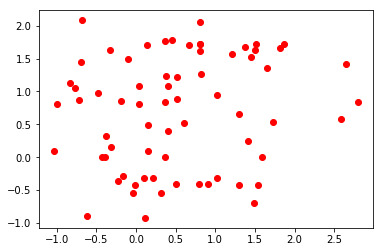

OOS_SHARPE DIFFERENCE SLIPPAGE OOS_PROFITABILITY


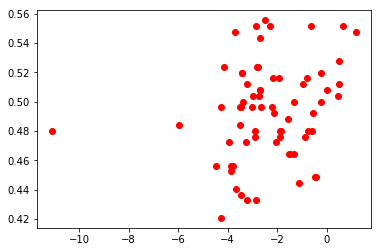

OOS_SHARPE DIFFERENCE SLIPPAGE OOS_SHARPE DIFFERENCE SLIPPAGE


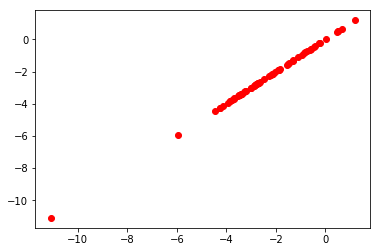

OOS_SHARPE DIFFERENCE SLIPPAGE OOS_SHARPE


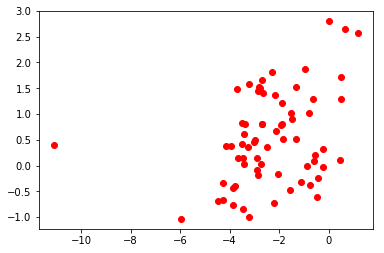

OOS_SHARPE DIFFERENCE SLIPPAGE OOS_ALPHA


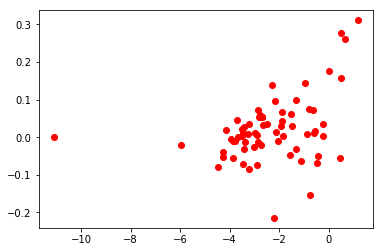

OOS_SHARPE DIFFERENCE SLIPPAGE OOS_PROFITABILITY DIFFERENCE


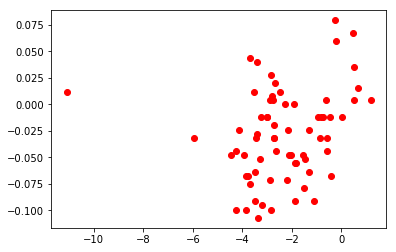

OOS_SHARPE DIFFERENCE SLIPPAGE OOS_BETA


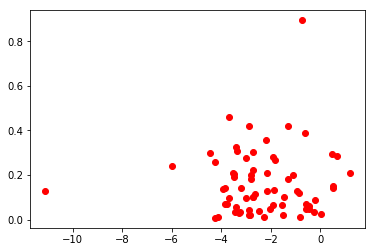

OOS_SHARPE DIFFERENCE SLIPPAGE OOS_ANNUALIZED RETURN


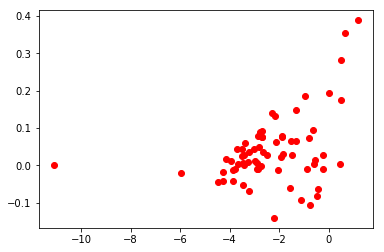

OOS_SHARPE DIFFERENCE SLIPPAGE OOS_FACTOR SHARPE


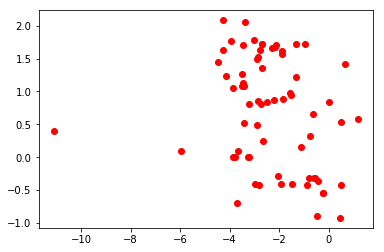

SMOOTHING
1    0.502165
2    0.493764
3    0.487395
4    0.500000
5    0.489229
Name: OOS_PROFITABILITY, dtype: float64
SMOOTHING
1   -2.556158
2   -2.223101
3   -2.080875
4   -1.810466
5   -2.797655
Name: OOS_SHARPE DIFFERENCE SLIPPAGE, dtype: float64
SMOOTHING
1    0.376997
2    0.642201
3    0.474949
4    0.732449
5    0.497746
Name: OOS_SHARPE, dtype: float64
SMOOTHING
1   -0.004552
2    0.023616
3    0.023423
4    0.031182
5    0.026530
Name: OOS_ALPHA, dtype: float64
SMOOTHING OOS_PROFITABILITY


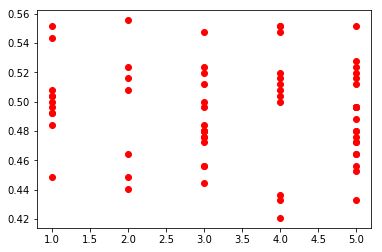

SMOOTHING OOS_SHARPE DIFFERENCE SLIPPAGE


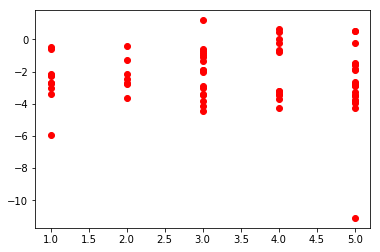

SMOOTHING OOS_SHARPE


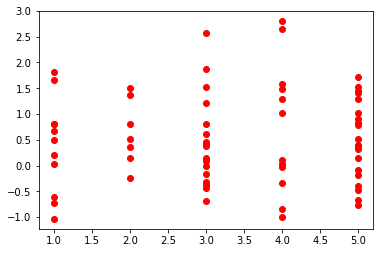

SMOOTHING OOS_ALPHA


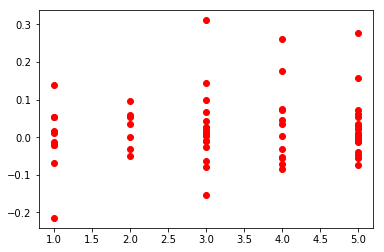

SMOOTHING OOS_PROFITABILITY DIFFERENCE


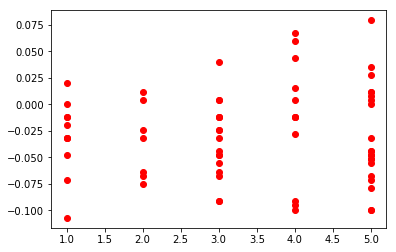

SMOOTHING OOS_BETA


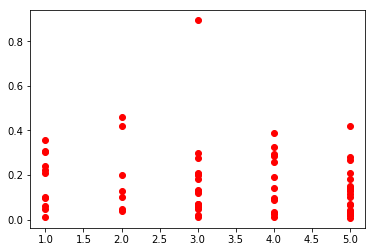

SMOOTHING OOS_ANNUALIZED RETURN


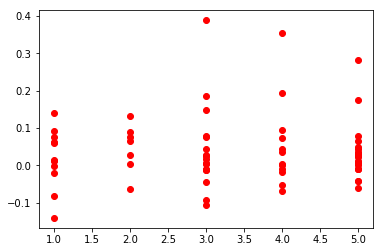

SMOOTHING OOS_FACTOR SHARPE


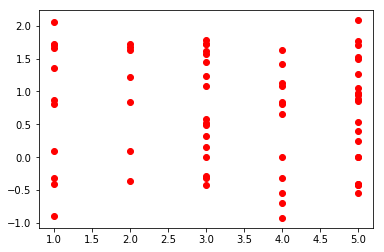

lastXDays
0      0.504762
50     0.502205
100    0.469246
150    0.488662
252    0.484488
350    0.513889
500    0.494048
600    0.480159
Name: OOS_PROFITABILITY, dtype: float64
lastXDays
0     -2.409317
50    -2.020721
100   -3.646618
150   -1.719759
252   -2.047598
350   -4.673276
500   -1.475428
600   -1.842890
Name: OOS_SHARPE DIFFERENCE SLIPPAGE, dtype: float64
lastXDays
0      0.660433
50     0.742411
100    0.125051
150    0.597121
252    0.120369
350    0.780908
500    1.064491
600    0.368569
Name: OOS_SHARPE, dtype: float64
lastXDays
0      0.018935
50     0.030481
100   -0.004551
150    0.041315
252   -0.009659
350    0.022355
500    0.099415
600    0.015821
Name: OOS_ALPHA, dtype: float64
lastXDays OOS_PROFITABILITY


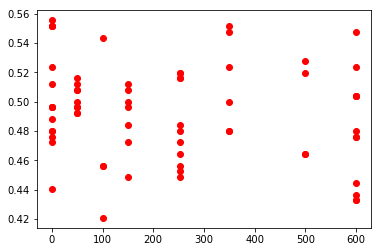

lastXDays OOS_SHARPE DIFFERENCE SLIPPAGE


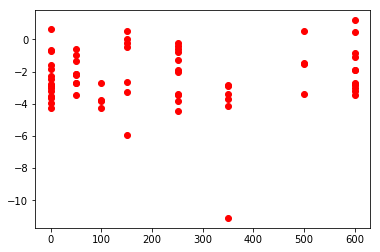

lastXDays OOS_SHARPE


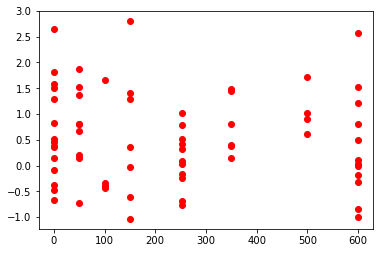

lastXDays OOS_ALPHA


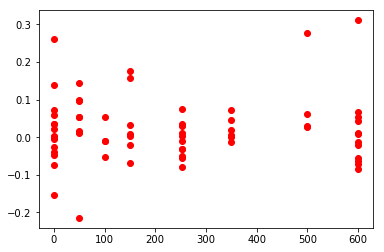

lastXDays OOS_PROFITABILITY DIFFERENCE


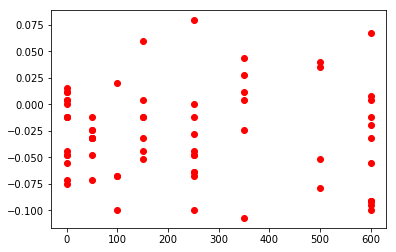

lastXDays OOS_BETA


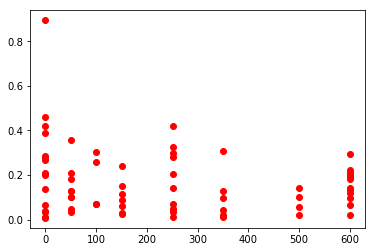

lastXDays OOS_ANNUALIZED RETURN


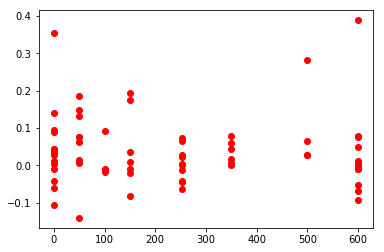

lastXDays OOS_FACTOR SHARPE


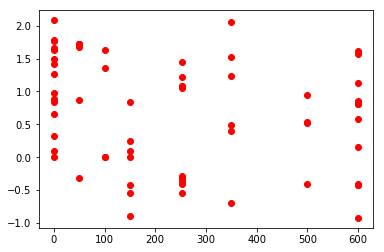

lookbackDistance
22    0.490866
44    0.501587
Name: OOS_PROFITABILITY, dtype: float64
lookbackDistance
22   -2.269265
44   -2.617308
Name: OOS_SHARPE DIFFERENCE SLIPPAGE, dtype: float64
lookbackDistance
22    0.515253
44    0.576674
Name: OOS_SHARPE, dtype: float64
lookbackDistance
22    0.021052
44    0.021933
Name: OOS_ALPHA, dtype: float64
lookbackDistance OOS_PROFITABILITY


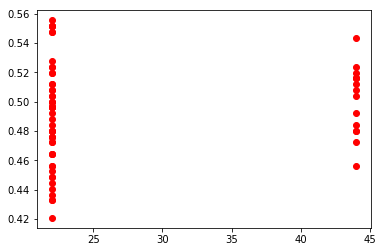

lookbackDistance OOS_SHARPE DIFFERENCE SLIPPAGE


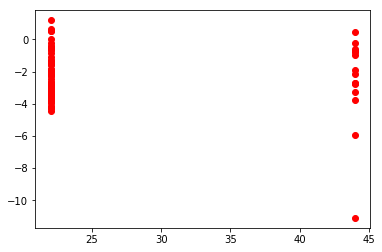

lookbackDistance OOS_SHARPE


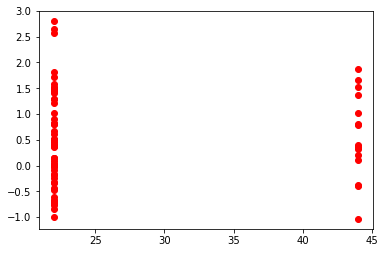

lookbackDistance OOS_ALPHA


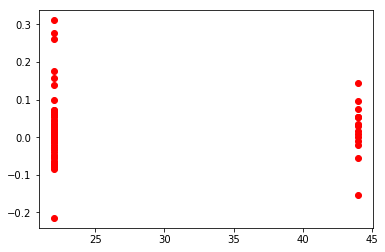

lookbackDistance OOS_PROFITABILITY DIFFERENCE


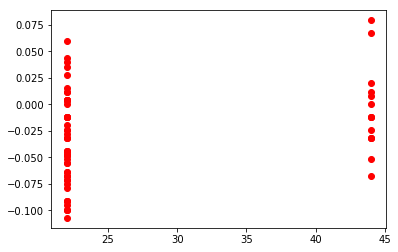

lookbackDistance OOS_BETA


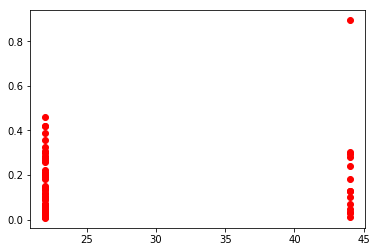

lookbackDistance OOS_ANNUALIZED RETURN


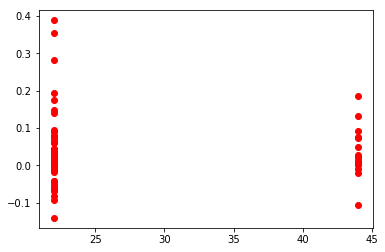

lookbackDistance OOS_FACTOR SHARPE


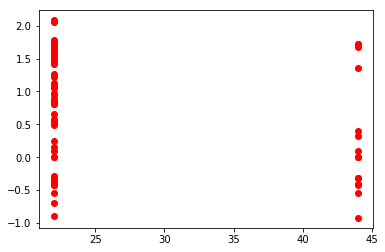

maxDistance
0.25    0.508433
0.50    0.509019
0.75    0.486874
1.00    0.487324
Name: OOS_PROFITABILITY, dtype: float64
maxDistance
0.25   -2.339395
0.50   -2.066209
0.75   -1.820923
1.00   -2.622644
Name: OOS_SHARPE DIFFERENCE SLIPPAGE, dtype: float64
maxDistance
0.25    0.877392
0.50    0.555424
0.75    0.571430
1.00    0.427810
Name: OOS_SHARPE, dtype: float64
maxDistance
0.25    0.064722
0.50    0.005238
0.75    0.012344
1.00    0.019691
Name: OOS_ALPHA, dtype: float64
maxDistance OOS_PROFITABILITY


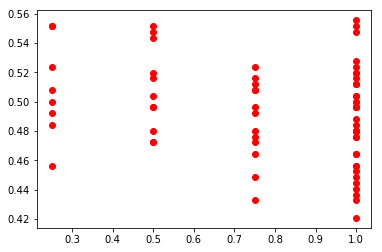

maxDistance OOS_SHARPE DIFFERENCE SLIPPAGE


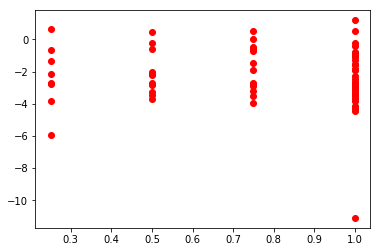

maxDistance OOS_SHARPE


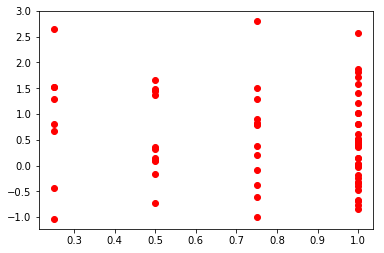

maxDistance OOS_ALPHA


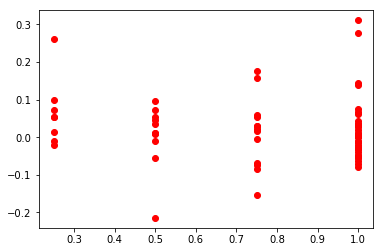

maxDistance OOS_PROFITABILITY DIFFERENCE


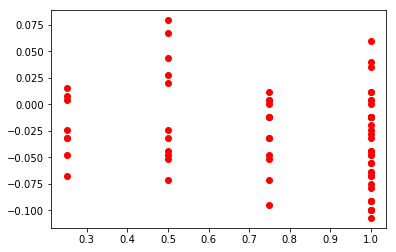

maxDistance OOS_BETA


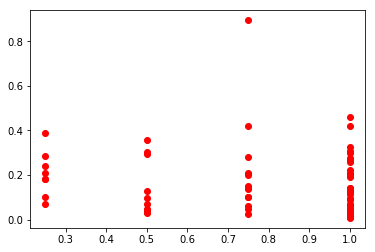

maxDistance OOS_ANNUALIZED RETURN


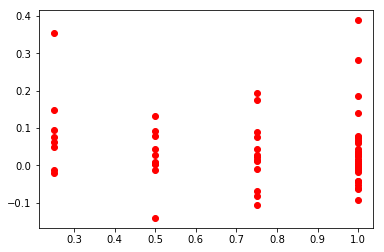

maxDistance OOS_FACTOR SHARPE


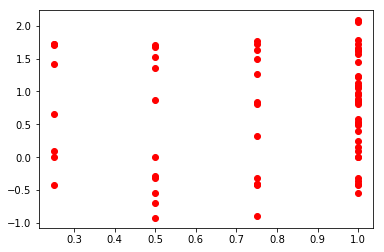

minConfidence
0.05    0.491402
0.10    0.494949
0.20    0.498557
0.30    0.488456
Name: OOS_PROFITABILITY, dtype: float64
minConfidence
0.05   -2.334867
0.10   -2.234467
0.20   -2.584279
0.30   -2.355318
Name: OOS_SHARPE DIFFERENCE SLIPPAGE, dtype: float64
minConfidence
0.05    0.535650
0.10    0.463436
0.20    0.640450
0.30    0.532946
Name: OOS_SHARPE, dtype: float64
minConfidence
0.05    0.018021
0.10    0.018573
0.20    0.033378
0.30    0.021498
Name: OOS_ALPHA, dtype: float64
minConfidence OOS_PROFITABILITY


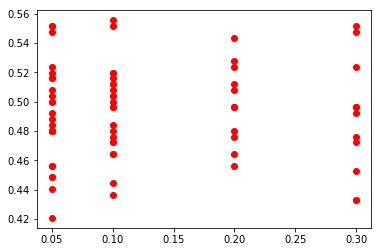

minConfidence OOS_SHARPE DIFFERENCE SLIPPAGE


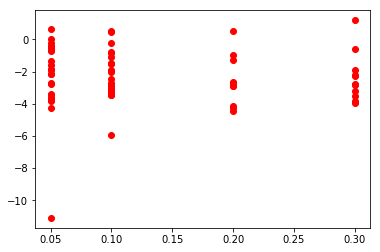

minConfidence OOS_SHARPE


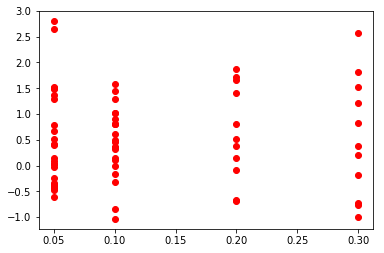

minConfidence OOS_ALPHA


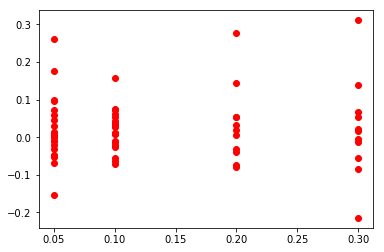

minConfidence OOS_PROFITABILITY DIFFERENCE


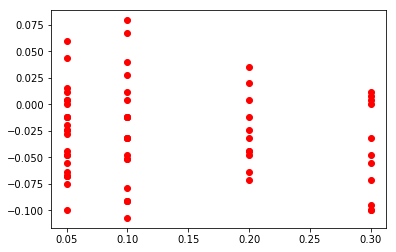

minConfidence OOS_BETA


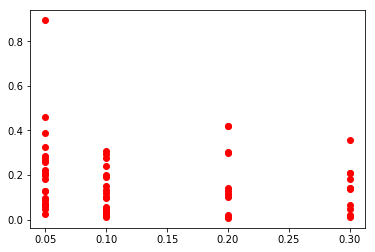

minConfidence OOS_ANNUALIZED RETURN


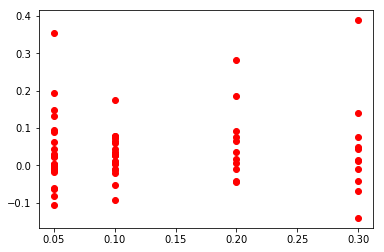

minConfidence OOS_FACTOR SHARPE


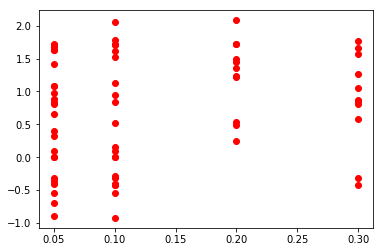

model OOS_PROFITABILITY
neighbors
1     0.491541
2     0.464286
3     0.498677
4     0.497024
5     0.511111
7     0.521825
10    0.456349
15    0.513889
20    0.480159
25    0.440476
30    0.498016
Name: OOS_PROFITABILITY, dtype: float64
neighbors
1    -2.390598
2    -2.524817
3    -1.698431
4    -1.908413
5    -1.818578
7    -0.598980
10   -3.816237
15   -2.137518
20   -1.829729
25   -3.672199
30   -6.509245
Name: OOS_SHARPE DIFFERENCE SLIPPAGE, dtype: float64
neighbors
1     0.503675
2    -0.452073
3     0.383909
4     1.291127
5     0.992371
7     0.754093
10   -0.411911
15    0.792271
20    0.520270
25    0.149089
30    0.601611
Name: OOS_SHARPE, dtype: float64
neighbors
1     0.019476
2    -0.112975
3    -0.008346
4     0.085612
5     0.100774
7     0.043496
10   -0.010597
15    0.028334
20    0.004232
25    0.001884
30    0.015421
Name: OOS_ALPHA, dtype: float64
neighbors OOS_PROFITABILITY


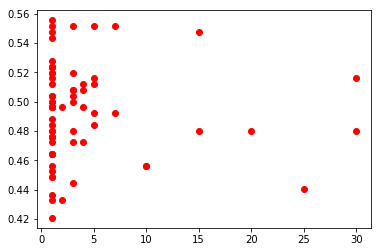

neighbors OOS_SHARPE DIFFERENCE SLIPPAGE


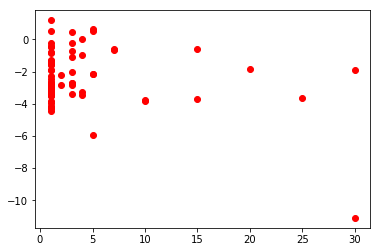

neighbors OOS_SHARPE


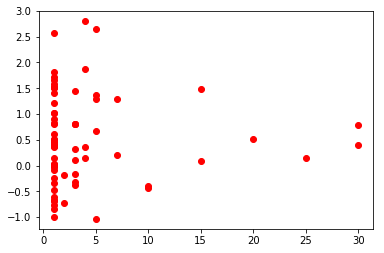

neighbors OOS_ALPHA


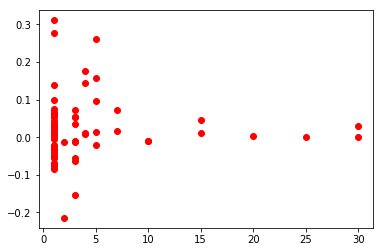

neighbors OOS_PROFITABILITY DIFFERENCE


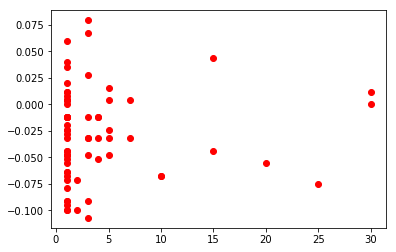

neighbors OOS_BETA


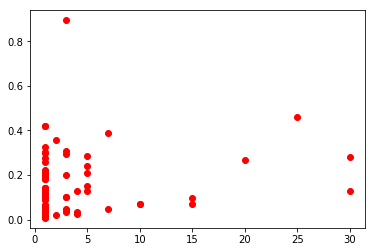

neighbors OOS_ANNUALIZED RETURN


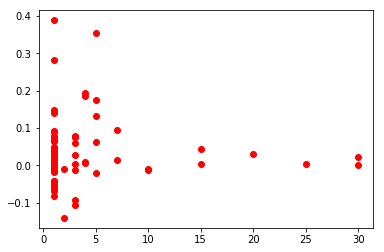

neighbors OOS_FACTOR SHARPE


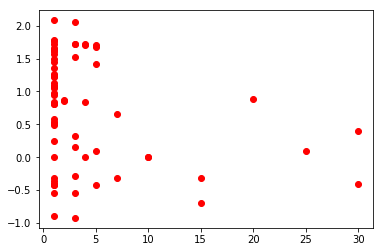

numberOfPredictors
0    0.493231
Name: OOS_PROFITABILITY, dtype: float64
numberOfPredictors
0   -2.346039
Name: OOS_SHARPE DIFFERENCE SLIPPAGE, dtype: float64
numberOfPredictors
0    0.528802
Name: OOS_SHARPE, dtype: float64
numberOfPredictors
0    0.021246
Name: OOS_ALPHA, dtype: float64
numberOfPredictors OOS_PROFITABILITY


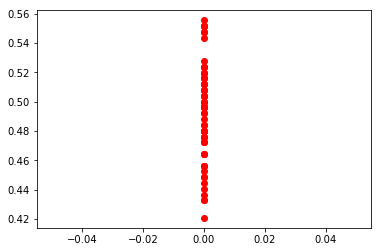

numberOfPredictors OOS_SHARPE DIFFERENCE SLIPPAGE


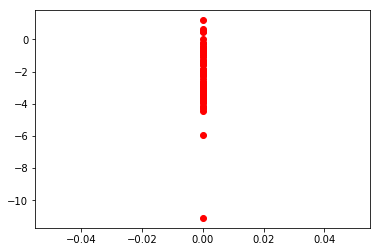

numberOfPredictors OOS_SHARPE


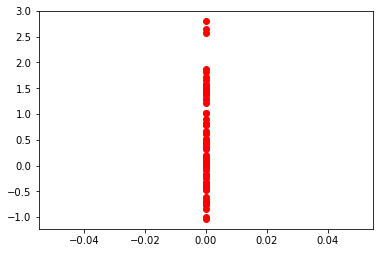

numberOfPredictors OOS_ALPHA


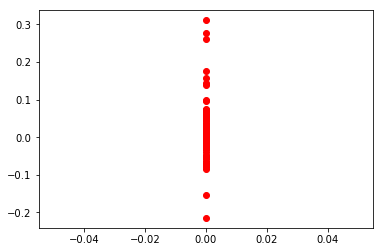

numberOfPredictors OOS_PROFITABILITY DIFFERENCE


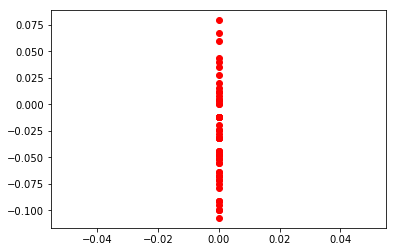

numberOfPredictors OOS_BETA


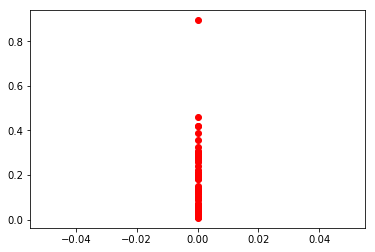

numberOfPredictors OOS_ANNUALIZED RETURN


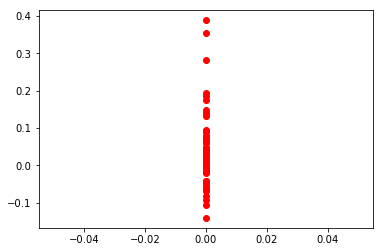

numberOfPredictors OOS_FACTOR SHARPE


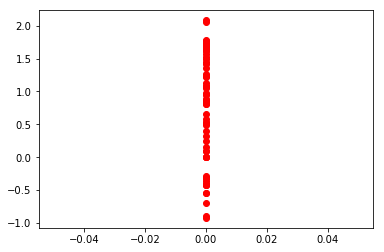

predictionLength
2    0.488095
3    0.509070
5    0.481990
Name: OOS_PROFITABILITY, dtype: float64
predictionLength
2   -1.563706
3   -2.425920
5   -2.308748
Name: OOS_SHARPE DIFFERENCE SLIPPAGE, dtype: float64
predictionLength
2   -0.483871
3    0.740284
5    0.402935
Name: OOS_SHARPE, dtype: float64
predictionLength
2   -0.047668
3    0.030814
5    0.016145
Name: OOS_ALPHA, dtype: float64
predictionLength OOS_PROFITABILITY


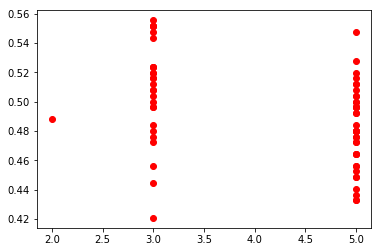

predictionLength OOS_SHARPE DIFFERENCE SLIPPAGE


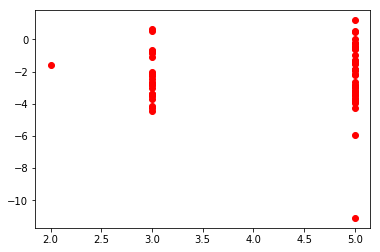

predictionLength OOS_SHARPE


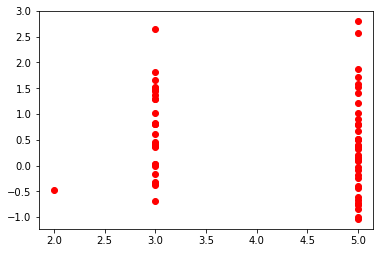

predictionLength OOS_ALPHA


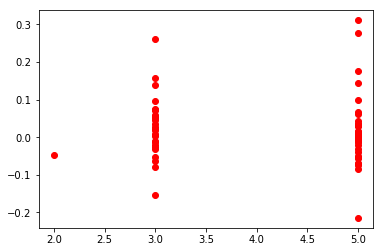

predictionLength OOS_PROFITABILITY DIFFERENCE


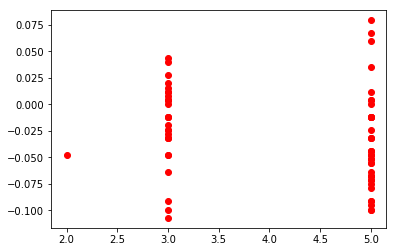

predictionLength OOS_BETA


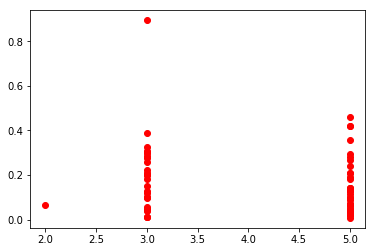

predictionLength OOS_ANNUALIZED RETURN


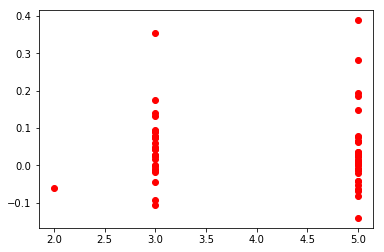

predictionLength OOS_FACTOR SHARPE


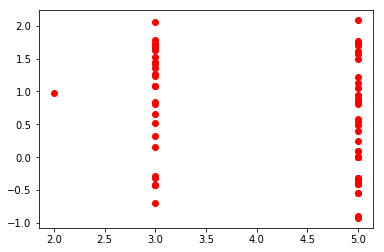

series OOS_PROFITABILITY
ticker OOS_PROFITABILITY


In [34]:
cm = pd.DataFrame(cleanedModels)
for col in cm.columns.values:
    
    try:
        import matplotlib.pyplot as plt
        groupsSharpe = cm.groupby([col])["OOS_PROFITABILITY"].mean()
        if len(groupsSharpe) < 20:
            print(groupsSharpe)
            print(cm.groupby([col])["OOS_SHARPE DIFFERENCE SLIPPAGE"].mean())
            print(cm.groupby([col])["OOS_SHARPE"].mean())
            print(cm.groupby([col])["OOS_ALPHA"].mean())
        print(col, "OOS_PROFITABILITY")
        xVals = cm[[col]].values
        yVals = cm[["OOS_PROFITABILITY"]].values
        plt.plot(xVals, yVals, 'ro')
        plt.show()
        print(col, "OOS_SHARPE DIFFERENCE SLIPPAGE")
        xVals = cm[[col]].values
        yVals = cm[["OOS_SHARPE DIFFERENCE SLIPPAGE"]].values
        plt.plot(xVals, yVals, 'ro')
        plt.show()
        
        print(col, "OOS_SHARPE")
        xVals = cm[[col]].values
        yVals = cm[["OOS_SHARPE"]].values
        plt.plot(xVals, yVals, 'ro')
        plt.show()
        
        print(col, "OOS_ALPHA")
        xVals = cm[[col]].values
        yVals = cm[["OOS_ALPHA"]].values
        plt.plot(xVals, yVals, 'ro')
        plt.show()
        
        print(col, "OOS_PROFITABILITY DIFFERENCE")
        xVals = cm[[col]].values
        yVals = cm[["OOS_PROFITABILITY DIFFERENCE"]].values
        plt.plot(xVals, yVals, 'ro')
        plt.show()
        
        print(col, "OOS_BETA")
        xVals = cm[[col]].values
        yVals = cm[["OOS_BETA"]].values
        plt.plot(xVals, yVals, 'ro')
        plt.show()
        
        print(col, "OOS_ANNUALIZED RETURN")
        xVals = cm[[col]].values
        yVals = cm[["OOS_ANNUALIZED RETURN"]].values
        plt.plot(xVals, yVals, 'ro')
        plt.show()
        
        print(col, "OOS_FACTOR SHARPE")
        xVals = cm[[col]].values
        yVals = cm[["OOS_FACTOR SHARPE"]].values
        plt.plot(xVals, yVals, 'ro')
        plt.show()
        plt.draw()
    except:
        continue
    

